## Imports and Environment Setup


In [1]:
# =========================
# Standard library imports
# =========================
import os
import time
import math
import gc
import random
import shutil
import pathlib


# =========================
# Third-party imports
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# TensorFlow / Keras imports
# =========================
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense,
    Dropout, SpatialDropout2D, BatchNormalization,
    Activation, GlobalAveragePooling2D, Multiply,
    Reshape, GaussianNoise
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, TrueNegatives, FalsePositives

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as ppi_inceptionv3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as ppi_mobilenetv2
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as ppi_resnet50

# =========================
# Keras Tuner imports
# =========================
import keras_tuner as kt

# =========================
# scikit-learn imports
# =========================
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, balanced_accuracy_score,
    f1_score, cohen_kappa_score,
    precision_recall_fscore_support
)
from sklearn.model_selection import train_test_split

# =========================
# others
# =========================
from pathlib import Path
from icrawler.builtin import BingImageCrawler

# =========================
# Mixed precision policy
# =========================
mixed_precision.set_global_policy("mixed_float16")


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


### GPU Memory Management Setup (TensorFlow)

This code prepares TensorFlow for stable GPU usage before training or inference.

- **`tf.keras.backend.clear_session()`**  
  Clears any previously loaded models and computational graphs from memory, preventing GPU and RAM buildup from earlier runs.

- **GPU memory growth configuration**  
  Detects available GPUs and enables *memory growth*, allowing TensorFlow to allocate GPU memory gradually instead of reserving all VRAM at startup. This reduces out-of-memory errors and lets other GPU processes run alongside TensorFlow.

Overall, this setup improves reliability and avoids unnecessary GPU memory exhaustion when running experiments repeatedly.


In [2]:

# 1. FORCE CLEAN SLATE
tf.keras.backend.clear_session()

# 2. ENABLE MEMORY GROWTH
# This prevents TensorFlow from hogging all VRAM at start
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU Memory Growth Enabled")
    except RuntimeError as e:
        print(e)

✅ GPU Memory Growth Enabled


## Dataset Setup (Proxy Dataset)

**Note:** Since the custom Peach/Onion dataset has not yet been collected, we are using the **TensorFlow Flowers Dataset** as a proxy to validate our code and model architecture.

We began by training on a publicly available dataset to validate our model and code pipeline, as this was our first attempt at working with a four-class image dataset and our first time capturing photos for machine learning. Using a random external dataset allowed us to establish a performance baseline for both our custom CNN and pre-trained architectures. This was important because it ensured the core implementation, data split, augmentation logic, and architecture were functioning reliably. By confirming stability with trusted external data first, we could isolate future issues more effectively. Once we transition to our own dataset (peach, onion, peach and onion combined, and unknown), any reduction in performance would strongly suggest that the problem originates from the dataset itself, rather than the model or training code. This gives us a controlled reference point and reduces uncertainty when debugging model behaviour later.

This script will:

1. Download the dataset archive from Google storage.
2. Extract the images.
3. Automatically split them into the required structure:

   * `dataset/train` (70% of data)
   * `dataset/val` (15% of data)
   * `dataset/test` (15% of data)
4. Use 4 classes to match our project requirement:

   * **Daisy**
   * **Dandelion**
   * **Roses**
   * **Sunflowers**
   * *(Tulips are excluded to enforce `NUM_CLASSES = 4`)*

---



In [1]:


# ==========================================
# AUTOMATED DATASET DOWNLOADER (TRAIN/VAL/TEST)
# ==========================================
# 1. Download the dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

# 2. Define our local project structure
base_dir = 'C:/Python/project_data/dataset/'
classes_to_use = ['daisy', 'dandelion', 'roses', 'sunflowers']

# 3. Create folders for all THREE splits
# Added 'val' to the loop
for category in ['train', 'val', 'test']:
    for class_name in classes_to_use:
        os.makedirs(os.path.join(base_dir, category, class_name), exist_ok=True)

print(f"--- Processing Data from {data_dir} ---")

# 4. Move and Split Files
for class_name in classes_to_use:
    # Get all images for this class
    src_folder = os.path.join(data_dir, class_name)
    images = os.listdir(src_folder)
    random.shuffle(images) # Shuffle for randomness
    
    # Calculate splits (70% Train, 15% Val, 15% Test)
    total = len(images)
    train_end = int(total * 0.7)
    val_end = int(total * 0.85) # 70% + 15%
    
    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]
    
    # Helper function to copy images
    def copy_imgs(img_list, folder_name):
        for img in img_list:
            src = os.path.join(src_folder, img)
            dst = os.path.join(base_dir, folder_name, class_name, img)
            shutil.copyfile(src, dst)

    # Execute copies
    copy_imgs(train_images, 'train')
    copy_imgs(val_images, 'val')
    copy_imgs(test_images, 'test')
        
    print(f"Class '{class_name}': {len(train_images)} train, {len(val_images)} val, {len(test_images)} test.")

print("\n[SUCCESS] Dataset split into Train, Val, and Test folders!")
print(f"Location: {base_dir}")

--- Processing Data from C:\Users\Terry\.keras\datasets\flower_photos ---
Class 'daisy': 443 train, 95 val, 95 test.
Class 'dandelion': 628 train, 135 val, 135 test.
Class 'roses': 448 train, 96 val, 97 test.
Class 'sunflowers': 489 train, 105 val, 105 test.

[SUCCESS] Dataset split into Train, Val, and Test folders!
Location: C:/Python/project_data/dataset/


### Web Image Collection for Dataset Generalisation

To improve the generalisation capability and real-world robustness of the model, additional images were collected from online sources using an automated web-scraping pipeline. The original dataset was captured manually by the team and consists of photographs of a peach, two onion varieties (brown and purple), and random household objects taken under controlled conditions. While this ensures consistency, it can also lead to overfitting to specific lighting, backgrounds, and camera characteristics.

To mitigate this, diverse online images were incorporated to expose the model to a wider range of visual variations, including different backgrounds, object scales, lighting conditions, and viewpoints. This helps the model learn more transferable features and improves performance on unseen data.

We ultimately used around **50 online images per class**, with the exception of the **unknown** class, which contained approximately **200 online images**.


#### Image Crawling Pipeline

The following script uses the `icrawler`

In [ ]:
ROOT_DIR = Path("dataset_raw")
IMAGES_PER_CLASS = 400

SEARCH_QUERIES = {
    "peach": [
        "peach fruit photo",
        "ripe peach fruit close up",
        "single whole peach fruit",
        "peach fruit on plate"
    ],
    "onion_brown": [
        "yellow onion photo",
        "brown onion bulb photo",
        "whole yellow onion on table",
        "fresh yellow onions"
    ],
    "onion_purple": [
        "red onion bulb photo",
        "purple onion whole photo",
        "whole red onion on table",
        "fresh red onions"
    ],
    "random_objects": [
        "messy desk items photo",
        "household items on table photo",
        "kitchen countertop items photo",
        "everyday objects on table photo"
    ]
}

def safe_rmtree(p: Path):
    if p.exists():
        shutil.rmtree(p)

def crawl_one(query: str, out_dir: Path, max_num: int):
    out_dir.mkdir(parents=True, exist_ok=True)
    crawler = BingImageCrawler(storage={"root_dir": str(out_dir)})

    crawler.crawl(
        keyword=query,
        filters={
            "type": "photo",
            "size": "large"   # larger pool than "medium"
        },
        max_num=max_num,
        file_idx_offset=0
    )

def merge_to_class(class_dir: Path, merged_dir: Path):
    merged_dir.mkdir(parents=True, exist_ok=True)
    existing = len(list(merged_dir.glob("*.jpg"))) + len(list(merged_dir.glob("*.png")))

    for img in class_dir.rglob("*"):
        if img.is_file() and img.suffix.lower() in [".jpg", ".jpeg", ".png", ".webp"]:
            existing += 1
            shutil.copy(img, merged_dir / f"{existing:06d}{img.suffix.lower()}")

def download_class(class_name: str, queries: list[str], target_n: int):
    base_dir = ROOT_DIR / class_name
    tmp_dir = base_dir / "_tmp_queries"
    merged_dir = base_dir / "merged"

    safe_rmtree(tmp_dir)
    tmp_dir.mkdir(parents=True, exist_ok=True)
    merged_dir.mkdir(parents=True, exist_ok=True)

    per_query = max(80, target_n // len(queries) * 3)  # oversample to survive 403/404 etc.

    print(f"\n[{class_name}] Target={target_n}, per_query={per_query}, queries={len(queries)}")

    for i, q in enumerate(queries, start=1):
        q_dir = tmp_dir / f"q{i:02d}"
        print(f"  - Crawling: {q}")
        crawl_one(q, q_dir, per_query)

    print("  - Merging...")
    merge_to_class(tmp_dir, merged_dir)

    # show count
    count = sum(1 for p in merged_dir.glob("*") if p.is_file())
    print(f"  - Merged count: {count}")

if __name__ == "__main__":
    for cls, qs in SEARCH_QUERIES.items():
        download_class(cls, qs, IMAGES_PER_CLASS)

    print("\nDone. Check dataset_raw/<class>/merged")


2026-01-16 15:39:28,349 - INFO - icrawler.crawler - start crawling...
2026-01-16 15:39:28,350 - INFO - icrawler.crawler - starting 1 feeder threads...
2026-01-16 15:39:28,351 - INFO - icrawler.crawler - starting 1 parser threads...
2026-01-16 15:39:28,354 - INFO - icrawler.crawler - starting 1 downloader threads...



[peach] Target=400, per_query=300, queries=4
  - Crawling: peach fruit photo


2026-01-16 15:39:28,706 - INFO - parser - parsing result page https://www.bing.com/images/async?q=peach fruit photo&first=0&qft=+filterui:photo-photo+filterui:imagesize-large
2026-01-16 15:39:28,886 - INFO - downloader - image #1	https://cdn.pixabay.com/photo/2020/03/21/13/39/fruit-tree-4953941_1280.jpg
2026-01-16 15:39:28,999 - INFO - downloader - image #2	https://c8.alamy.com/comp/EGDWYG/fresh-peach-fruit-background-EGDWYG.jpg
2026-01-16 15:39:29,340 - INFO - downloader - image #3	https://images.pexels.com/photos/8446849/pexels-photo-8446849.jpeg?cs=srgb&dl=pexels-cristian-rojas-8446849.jpg
2026-01-16 15:39:29,437 - INFO - downloader - image #4	https://cdn.pixabay.com/photo/2021/12/01/02/08/peach-6836572_1280.jpg
2026-01-16 15:39:29,524 - INFO - downloader - image #5	https://cdn.pixabay.com/photo/2015/12/03/13/51/peach-1074997_1280.jpg
2026-01-16 15:39:29,591 - INFO - downloader - image #6	https://cdn.pixabay.com/photo/2015/07/15/21/51/peach-846962_640.jpg
2026-01-16 15:39:29,668 - I

# 📘 ET0732 Mini Project: Image Recognition and Classification

**Topic:** Peach vs Onion Classification (Brown Onion, Purple Onion) with Unknown Rejection
**Group Members:** **Tng Khai Chun Terence (P2425713)** and **Justin Lui Jun Wei (P2425672)**

---

## 1. Project Introduction and Objectives

This project develops a deep learning image classification system that recognises **four classes**:

1. **Peach**
2. **Brown Onion**
3. **Purple Onion**
4. **Unknown** (random objects and empty backgrounds)

The aim is to build a **robust and generalisable** classifier by combining **transfer learning** with **custom CNN design**, supported by systematic optimisation, fair evaluation, and deployment readiness.

---

## 2. Approach Overview

### A. Data preparation and augmentation (generalisation-first)

To reduce overfitting on a limited dataset, we applied **training-only augmentation** (rotation, flips, zoom, shifts, brightness) while keeping **validation and test pipelines rescale-only** to avoid biased estimates. Augmentation strength was tuned to remain realistic and preserve class integrity, especially for visually similar categories.

### B. Transfer learning pipeline (fair model comparison)

We benchmarked three ImageNet-pretrained backbones using a consistent classifier head built on **GlobalAveragePooling2D** (to reduce parameters and overfitting):

* **InceptionV3**
* **MobileNetV2** (efficient, edge-friendly)
* **ResNet50** (high-capacity residual learning)

A key improvement was **model-specific preprocessing alignment** (correct `preprocess_input`) and **architecture-appropriate input resolution** (InceptionV3 at 299×299, others at 224×224), which proved critical for reliable transfer learning performance.

### C. Custom CNN evolution (v1 → v4)

We iteratively improved a scratch-built CNN:

* **V1 (Baseline):** conventional `Flatten()` + dense head as a control, intentionally prone to overfitting
* **V2:** VGG-style stacked convolutions + BatchNorm + GAP for stability and compactness
* **V3:** SE-attention + Swish activations to reduce colour-based confusions and strengthen feature selectivity
* **V4:** focal loss + spatial dropout to focus learning on harder samples and increase robustness

### D. Hyperparameter optimisation

We used **Keras Tuner (Hyperband)** to tune key training and capacity settings (image size, batch size, filters, dense units, dropout, L2, learning rate). A second, more structured **multi-stage macro/micro strategy** was also explored to improve compute efficiency and interpretability.

---

## 3. Evaluation Strategy and Key Findings

To prevent misleading results from class imbalance (especially due to **Unknown**), models were judged using **Balanced Accuracy** and **Macro F1**, alongside confusion matrices and per-class reports. Test-set evaluation used careful step sizing and label alignment to avoid silent mismatches.

**Major findings:**

* **Correct preprocessing is essential for transfer learning**, with ResNet50 shifting from failure under generic preprocessing to top performance once aligned.
* For custom CNNs, **V3 (SE-attention)** emerged as the strongest and most consistent architecture, and **tuned V3 (HP1)** became the best deployment candidate due to excellent balanced metrics and efficiency.

---

## 4. Deployment Readiness and Dataset Reliability

To support real-world use, the final model was converted into **TensorFlow Lite (.tflite)** for **on-device Android classification**, enabling offline, real-time inference.

We also compared **stratified random splitting** against a **manual context-based split** to check for dataset bias. Strong performance across both splits indicates the models learn meaningful object features rather than background shortcuts, supporting dataset quality and generalisation confidence.

---


## 2. Configuration & Hyperparameter Optimization
We have optimized the parameters from the original lab sample code. Below is the justification for these changes:

| Parameter | Original Lab Code | Our Optimization | Justification |
| :--- | :--- | :--- | :--- |
| **Image Size** | `(75, 75)` | `(150, 150)` | 75px is too small to capture fine textures (like onion skin). 150px provides higher feature resolution. |
| **Batch Size** | `214` | `32` | The original batch size of 214 is excessively high for standard hardware. 32 ensures stable gradient descent without memory crashes. Larger batches may accelerate training, but smaller batches (for example, 32) add gradient noise that acts as a regulariser, often improving test set generalisation (Masters and Luschi, 2018). 
|
| **Steps** | Hardcoded `10` | Dynamic | We calculate `len(data) // batch_size` to ensure the model sees the *entire* dataset every epoch, rather than skipping data. |

In [3]:
# --------------------------
# Reproducibility (best-effort)
# --------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --------------------------
# GPU memory growth (prevents TF from grabbing all VRAM)
# --------------------------
try:
    gpus = tf.config.list_physical_devices("GPU")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except Exception:
    pass

# --------------------------
# Paths
# --------------------------
BASE_DIR = r"C:/Users/Terry/Downloads/MLAI/ET0732_LAB3_Peach_Onion/dataset_stratified_split/"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

# --------------------------
# Stratified random split (70/15/15) into TRAIN_DIR / VAL_DIR / TEST_DIR
# Only runs if train/val/test are missing or empty
# --------------------------

TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

def _dir_has_images(d):
    if not os.path.exists(d):
        return False
    for root, _, files in os.walk(d):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                return True
    return False

def _safe_clear_dir(d):
    # Deletes the directory if it exists, then recreates it
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

def make_stratified_splits_if_needed():
    # If split folders already contain images, do nothing
    if _dir_has_images(TRAIN_DIR) and _dir_has_images(VAL_DIR) and _dir_has_images(TEST_DIR):
        print("Split folders already contain images, skipping stratified split.")
        return

    # Collect images from class folders inside BASE_DIR (excluding train/val/test)
    image_paths = []
    labels = []

    for class_name in os.listdir(BASE_DIR):
        class_dir = os.path.join(BASE_DIR, class_name)
        if not os.path.isdir(class_dir):
            continue
        if class_name in ("train", "val", "test"):
            continue

        for fname in os.listdir(class_dir):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(class_dir, fname))
                labels.append(class_name)

    if len(image_paths) == 0:
        raise ValueError(
            "No images found to split. BASE_DIR should contain class folders with images, "
            "not only train/val/test."
        )

    # Clear and recreate split folders (prevents duplicates)
    _safe_clear_dir(TRAIN_DIR)
    _safe_clear_dir(VAL_DIR)
    _safe_clear_dir(TEST_DIR)

    # Split: train (70%) + temp (30%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths,
        labels,
        test_size=(1.0 - TRAIN_RATIO),
        stratify=labels,
        random_state=SEED
    )

    # Split temp: val (15%) + test (15%)
    val_ratio_adjusted = VAL_RATIO / (VAL_RATIO + TEST_RATIO)

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp,
        y_temp,
        test_size=(1.0 - val_ratio_adjusted),
        stratify=y_temp,
        random_state=SEED
    )

    def copy_split(files, file_labels, target_dir):
        for src, label in zip(files, file_labels):
            dst_dir = os.path.join(target_dir, label)
            os.makedirs(dst_dir, exist_ok=True)
            shutil.copy2(src, dst_dir)

    copy_split(X_train, y_train, TRAIN_DIR)
    copy_split(X_val,   y_val,   VAL_DIR)
    copy_split(X_test,  y_test,  TEST_DIR)

    print("Stratified split complete.")
    print(f"Train: {len(X_train)} images")
    print(f"Val:   {len(X_val)} images")
    print(f"Test:  {len(X_test)} images")

# Run once at startup (safe, will skip if already split)
make_stratified_splits_if_needed()

# --------------------------
# Core hyperparameters
# --------------------------
NUM_CLASSES = 4
DEFAULT_BATCH_SIZE = 32
PRETRAINED_EPOCHS = 10

# Baseline input size (intentionally smaller baseline)
IMG_SIZE_BASE = (150, 150)

# Recommended sizes for these Keras Applications
IMG_SIZE_INCEPTIONV3 = (299, 299)
IMG_SIZE_PRETRAINED  = (224, 224)

# Training utilities
def steps_per_epoch_for(gen):
    # Use ceil so we do not silently drop the remainder
    return math.ceil(gen.samples / gen.batch_size)

print("Configuration Loaded.")
print("TensorFlow:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices("GPU")))
print("TRAIN_DIR:", TRAIN_DIR)
print("VAL_DIR:", VAL_DIR)
print("TEST_DIR:", TEST_DIR)


Split folders already contain images, skipping stratified split.
Configuration Loaded.
TensorFlow: 2.10.1
GPU Available: 1
TRAIN_DIR: C:/Users/Terry/Downloads/MLAI/ET0732_LAB3_Peach_Onion/dataset_stratified_split/train
VAL_DIR: C:/Users/Terry/Downloads/MLAI/ET0732_LAB3_Peach_Onion/dataset_stratified_split/val
TEST_DIR: C:/Users/Terry/Downloads/MLAI/ET0732_LAB3_Peach_Onion/dataset_stratified_split/test


## 3. Initial Data Preparation & Augmentation

To adhere to the requirement of a sufficiently large and diverse dataset, we apply **Data Augmentation** to our training set. The size of the original training dataset is fixed and limited, which increases the risk of overfitting. Data augmentation mitigates this by generating varied versions of existing images during training, encouraging the model to learn robust and invariant features rather than memorising the training samples (Shorten and Khoshgoftaar, 2019).

**Augmentation Strategy:**
* `rotation_range=30`: To handle peaches and onions appearing at different angles.
* `horizontal_flip=True`: To ensure the model recognises objects regardless of orientation.
* `zoom_range=0.2`: To simulate variations in distance and scale between the camera and the object.
* **REMOVED** `validation_split=0.2` (From Original Lab Code): Validation data should not go through data augmentation.


In [4]:
# ==========================================
# INITIAL VERSION (BASELINE IMPLEMENTATION)
# This block is kept for reference only
# ==========================================

# # 2. DATA GENERATORS
# # ImageDataGenerator is used to preprocess and augment image data
# # This represents the initial data preparation approach before improvements

# train_datagen = ImageDataGenerator(
#     rescale=1./255,             # Normalise pixel values from [0, 255] to [0, 1]
#     rotation_range=30,          # Rotate images randomly to handle orientation variance
#     width_shift_range=0.2,      # Shift images horizontally to simulate object movement
#     height_shift_range=0.2,     # Shift images vertically to simulate object movement
#     shear_range=0.2,            # Apply shear transformation for basic geometric robustness
#     zoom_range=0.2,             # Zoom in and out to handle scale variation
#     horizontal_flip=True,       # Flip images horizontally to reduce orientation bias
#     fill_mode='nearest',        # Fill newly created pixels after transformation
# )

# # Test/Val data generator
# # Test/Val data should only be rescaled and never augmented
# val_datagen = ImageDataGenerator(
#     rescale=1./255              # Normalise pixel values only
# )
# test_datagen = ImageDataGenerator(
#     rescale=1./255              # Normalise pixel values only
# )

# # Load training data
# print("--- Loading Training Data ---")

# train_gen_base = train_datagen.flow_from_directory(
#     TRAIN_DIR,                  # Path to training image directory
#     target_size=IMG_SIZE_BASE,       # Resize images to model input size
#     batch_size=DEFAULT_BATCH_SIZE,      # Number of images per batch
#     class_mode='categorical',   # Multi-class classification setup
# )

# # Load validation data
# print("\n--- Loading Validation Data ---")

# val_gen_base = val_datagen.flow_from_directory(
#     VAL_DIR,                  # Path to val image directory
#     target_size=IMG_SIZE_BASE,       # Same image size for consistency
#     batch_size=DEFAULT_BATCH_SIZE,      # Same batch size as training
#     class_mode='categorical',   # Multi-class classification setup
#     shuffle=False               # Disable shuffling for correct evaluation
# )

# # Load test data
# print("\n--- Loading Test Data ---")

# test_gen_base = test_datagen.flow_from_directory(
#     TEST_DIR,                   # Path to test image directory
#     target_size=IMG_SIZE_BASE,       # Resize images to match training input
#     batch_size=DEFAULT_BATCH_SIZE,      # Batch size for evaluation
#     class_mode='categorical',   # Multi-class classification setup
#     shuffle=False               # Disable shuffling for correct evaluation
# )


## 4. Improved Data Preparation and Augmentation (Changes from Baseline)

To support a **4-class classifier** (*peach, brown onion, purple onion, unknown*), augmentation was strengthened where it is safe, and constrained where it may break composite labels. This is critical because the class **peach** and **purple onion** requires both objects to remain visible after transformation, otherwise the model may learn incorrect label associations.

### Key optimisation choices

### 1) Balanced augmentation strength for composite-label safety

* **Rotation increased to 40°** to improve orientation invariance (Chollet, 2017), without removing content from the frame.
* **Width and height shifts reduced to 0.1** to prevent secondary objects being translated out of view (Shorten & Khoshgoftaar, 2019).
* **Shear reduced to 0.1** to maintain geometric integrity while providing mild viewpoint variation (Shorten & Khoshgoftaar, 2019).
* **Zoom reduced to 0.1** to avoid dropping one of the objects in composite-label frames (Shorten & Khoshgoftaar, 2019).
* **Vertical flips added** as they are valid for top-down fruit and vegetable shots where orientation is not meaningful (Chollet, 2017).

### 2) Colour-preserving photometric policy

* **Added brightness range [0.8, 1.2]** to cover natural lighting variation (Shorten & Khoshgoftaar, 2019).
* **Channel shifting NOT added** to avoid corrupting class colour cues, which may reduce separability between *peach* and *onion* classes when colour is informative (Masters & Luschi, 2018).

### 3) Training vs evaluation pipeline separation

Validation and test pipelines remain **rescale-only** to preserve true distribution statistics and avoid biased performance estimates (Goodfellow et al., 2016).

---

In [5]:
# ==========================================
# DATA AUGMENTATION + BASELINE GENERATORS (rescale=1./255)
# Notes:
# - This is a deliberate "baseline" pipeline (not model-specific preprocess_input).
# ==========================================

AUG_BASE = dict(
    # --- GEOMETRIC TRANSFORMATIONS (Safe for Multi-Object) ---
    rotation_range=40,          # Fruits have no standard orientation
    width_shift_range=0.1,      # REDUCED: Prevent cropping out secondary objects
    height_shift_range=0.1,     # REDUCED: Prevent cropping out secondary objects
    shear_range=0.1,            # REDUCED: Maintain shape integrity
    zoom_range=0.1,             # REDUCED: High zoom risks changing "purple onion" to just "Purple"
    horizontal_flip=True,       # Safe
    vertical_flip=True,         # Safe for top-down fruit shots
    
    # --- PHOTOMETRIC TRANSFORMATIONS (Color Preservation) ---
    brightness_range=[0.8, 1.2], # Handle lighting changes
    # REMOVED: channel_shift_range (Risk of confusing class colors)
    
    fill_mode='nearest'
)

train_datagen_base = ImageDataGenerator(
    rescale=1./255,
    **AUG_BASE
)

val_datagen_base = ImageDataGenerator(rescale=1./255)
test_datagen_base = ImageDataGenerator(rescale=1./255)

print("--- Loading BASELINE Training Data ---")
train_gen_base = train_datagen_base.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_BASE,
    batch_size=DEFAULT_BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

print("\n--- Loading BASELINE Validation Data ---")
val_gen_base = val_datagen_base.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE_BASE,
    batch_size=DEFAULT_BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("\n--- Loading BASELINE Test Data ---")
test_gen_base = test_datagen_base.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE_BASE,
    batch_size=DEFAULT_BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Sanity check: keep class mapping consistent across splits
print("\nClass indices (train):", train_gen_base.class_indices)
print("Class indices (val):  ", val_gen_base.class_indices)
print("Class indices (test): ", test_gen_base.class_indices)


--- Loading BASELINE Training Data ---
Found 3462 images belonging to 4 classes.

--- Loading BASELINE Validation Data ---
Found 742 images belonging to 4 classes.

--- Loading BASELINE Test Data ---
Found 742 images belonging to 4 classes.

Class indices (train): {'onion_brown': 0, 'onion_purple': 1, 'peach': 2, 'unknown': 3}
Class indices (val):   {'onion_brown': 0, 'onion_purple': 1, 'peach': 2, 'unknown': 3}
Class indices (test):  {'onion_brown': 0, 'onion_purple': 1, 'peach': 2, 'unknown': 3}


## 5.1. InceptionV3 (Transfer Learning)

**Objective:** Upgrade the original "Rock-Paper-Scissors" model to a deeper, more efficient architecture for our current dataset.

**Key Modifications:**

1. **Deeper Feature Extraction:** Instead of cutting the model early at the `'mixed3'` layer, we now use the full InceptionV3 base (up to the final convolutional block). This allows the model to capture more complex patterns.
2. **Efficient Pooling:** We replaced `Flatten()` with `GlobalAveragePooling2D()`. This reduces the parameter count from millions to a few thousand in the dense layers, preventing overfitting and speeding up training.
3. **Dynamic Training:** We removed hardcoded training steps (e.g., `steps_per_epoch=10`) and replaced them with dynamic calculations to ensure the model learns from every image in the dataset during each epoch.

In [6]:
# ==========================================
# BASELINE MODEL (InceptionV3) trained on baseline generators
# Notes:
# - This is intentionally "naive" preprocessing (rescale only), to compare vs improved later.
# ==========================================

inception_base_stats = {}

def build_inceptionv3_base():
    print("\n--- Building BASE InceptionV3 ---")
    base_model = InceptionV3(
        input_shape=IMG_SIZE_BASE + (3,),
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.2)(x)
    output = Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Train
model_inception_base = build_inceptionv3_base()

start_time = time.time()
history_inception_base = model_inception_base.fit(
    train_gen_base,
    validation_data=val_gen_base,
    epochs=PRETRAINED_EPOCHS,
    steps_per_epoch=steps_per_epoch_for(train_gen_base),
    validation_steps=steps_per_epoch_for(val_gen_base),
    verbose=1
)
duration = time.time() - start_time

# Save
os.makedirs("../models", exist_ok=True)
model_inception_base.save("../models/model_inception_v3_base.h5")
print("Saved: ../models/model_inception_v3_base.h5")

inception_base_stats = {
    "Model": "InceptionV3",
    "Training Time (s)": round(duration, 2),
    "Train Accuracy": round(history_inception_base.history["accuracy"][-1] * 100, 2),
    "Val Accuracy": round(history_inception_base.history["val_accuracy"][-1] * 100, 2),
    "Loss": round(history_inception_base.history["val_loss"][-1], 4),
}
inception_base_stats



--- Building BASE InceptionV3 ---
Epoch 1/10
109/109 [==============================] - 29s 180ms/step - loss: 0.7986 - accuracy: 0.7540 - val_loss: 0.3035 - val_accuracy: 0.8789
Epoch 2/10
109/109 [==============================] - 16s 151ms/step - loss: 0.3752 - accuracy: 0.8464 - val_loss: 0.3762 - val_accuracy: 0.8385
Epoch 3/10
109/109 [==============================] - 16s 146ms/step - loss: 0.3346 - accuracy: 0.8712 - val_loss: 0.2191 - val_accuracy: 0.9152
Epoch 4/10
109/109 [==============================] - 16s 147ms/step - loss: 0.3010 - accuracy: 0.8828 - val_loss: 0.1908 - val_accuracy: 0.9314
Epoch 5/10
109/109 [==============================] - 17s 152ms/step - loss: 0.2512 - accuracy: 0.9070 - val_loss: 0.2544 - val_accuracy: 0.9071
Epoch 6/10
109/109 [==============================] - 16s 147ms/step - loss: 0.2486 - accuracy: 0.9024 - val_loss: 0.1584 - val_accuracy: 0.9569
Epoch 7/10
109/109 [==============================] - 16s 146ms/step - loss: 0.2398 - accuracy:

{'Model': 'InceptionV3',
 'Training Time (s)': 175.43,
 'Train Accuracy': 92.32,
 'Val Accuracy': 93.81,
 'Loss': 0.1598}

## 5.2. Model Comparison (InceptionV3 vs MobileNetV2 vs ResNet50)

**Objective:** Benchmark the baseline InceptionV3 model against other industry-standard architectures to find the optimal balance between computational efficiency and accuracy.

**Methodology:**
To ensure a fair and efficient comparison, we **retain the metrics from the InceptionV3 model trained in Part 1** rather than retraining it. We then train the following two models using the exact same hyperparameters and `GlobalAveragePooling2D` output structure:

1. **MobileNetV2:** Selected to test performance in lightweight, resource-constrained environments (Edge Computing).
2. **ResNet50:** Selected to evaluate the benefits of deep residual learning and skip connections.

**Metrics Compared:**

* **Training Time (Seconds):** To assess computational cost.
* **Training & Validation Accuracy:** To measure learning capability and generalization.
* **Validation Loss:** To evaluate the model's confidence and error rate.

In [7]:
# ==========================================
# BASELINE COMPARISON MODELS (MobileNetV2, ResNet50) trained on baseline generators
# Notes:
# - Same baseline pipeline (rescale only), so results are directly comparable within "Base".
# ==========================================

def build_pretrained_base(model_name: str):
    print(f"\n--- Building BASE {model_name} ---")
    if model_name == "MobileNetV2":
        base_model = MobileNetV2(
            input_shape=IMG_SIZE_BASE + (3,),
            include_top=False,
            weights="imagenet"
        )
    elif model_name == "ResNet50":
        base_model = ResNet50(
            input_shape=IMG_SIZE_BASE + (3,),
            include_top=False,
            weights="imagenet"
        )
    else:
        raise ValueError("model_name must be 'MobileNetV2' or 'ResNet50'")

    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.2)(x)
    output = Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def train_and_record_base(model_name: str):
    model = build_pretrained_base(model_name)

    start_time = time.time()
    history = model.fit(
        train_gen_base,
        validation_data=val_gen_base,
        epochs=PRETRAINED_EPOCHS,
        steps_per_epoch=steps_per_epoch_for(train_gen_base),
        validation_steps=steps_per_epoch_for(val_gen_base),
        verbose=1
    )
    duration = time.time() - start_time

    path = f"../models/model_{model_name}_base.h5"
    model.save(path)
    print(f"Saved: {path}")

    stats = {
        "Model": model_name,
        "Training Time (s)": round(duration, 2),
        "Train Accuracy": round(history.history["accuracy"][-1] * 100, 2),
        "Val Accuracy": round(history.history["val_accuracy"][-1] * 100, 2),
        "Loss": round(history.history["val_loss"][-1], 4),
    }

    # cleanup
    tf.keras.backend.clear_session()
    gc.collect()
    return stats

base_results = [inception_base_stats]
for name in ["MobileNetV2", "ResNet50"]:
    base_results.append(train_and_record_base(name))

df_results_base = pd.DataFrame(base_results)
print("\n=== BASE MODEL COMPARISON ===")
df_results_base



--- Building BASE MobileNetV2 ---
Epoch 1/10
109/109 [==============================] - 22s 179ms/step - loss: 0.4897 - accuracy: 0.8441 - val_loss: 0.1554 - val_accuracy: 0.9462
Epoch 2/10
109/109 [==============================] - 18s 167ms/step - loss: 0.1656 - accuracy: 0.9440 - val_loss: 0.1058 - val_accuracy: 0.9677
Epoch 3/10
109/109 [==============================] - 19s 176ms/step - loss: 0.1549 - accuracy: 0.9440 - val_loss: 0.1304 - val_accuracy: 0.9569
Epoch 4/10
109/109 [==============================] - 18s 165ms/step - loss: 0.1201 - accuracy: 0.9587 - val_loss: 0.0888 - val_accuracy: 0.9758
Epoch 5/10
109/109 [==============================] - 18s 169ms/step - loss: 0.1113 - accuracy: 0.9642 - val_loss: 0.0760 - val_accuracy: 0.9758
Epoch 6/10
109/109 [==============================] - 18s 160ms/step - loss: 0.0930 - accuracy: 0.9688 - val_loss: 0.0670 - val_accuracy: 0.9798
Epoch 7/10
109/109 [==============================] - 18s 162ms/step - loss: 0.1088 - accuracy:

Model  Training Time (s)  Train Accuracy  Val Accuracy    Loss
0  InceptionV3             175.43           92.32         93.81  0.1598
1  MobileNetV2             188.28           97.60         98.12  0.0601
2     ResNet50             164.23           34.15         35.40  1.2942

## 6. Model Preprocessing and Training Improvements

The backbone architectures and classifier head were preserved across all pretrained models to ensure a fair comparison. The following improvements were applied to improve transfer learning reliability and training stability.

### Preprocessing alignment per model

Separate `ImageDataGenerator` pipelines were created to apply the correct ImageNet preprocessing for each architecture:

* **InceptionV3:** `preprocess_input` remaps input pixels to the distribution expected by Inception networks.
* **MobileNetV2:** `preprocess_input` applies scaling optimised for depthwise separable convolution models.
* **ResNet50:** `preprocess_input` applies channel-wise normalisation consistent with residual network training.

This ensures that all pretrained backbones receive inputs matching their original ImageNet training conditions.

### Updated input resolutions

Model input resolutions were adjusted based on architectural design and ImageNet training conventions:

* **InceptionV3:** updated to **299×299**, the resolution the network was originally designed for.
* **MobileNetV2:** updated to **224×224**, the standard resolution used for its ImageNet weights.
* **ResNet50:** updated to **224×224**, which aligns with pretrained residual feature map scaling.

Using model-specific input sizes avoids unnecessary interpolation and preserves feature quality during transfer learning.

### Safe multi-object data augmentation (unchanged)

A shared augmentation configuration was applied consistently across all training generators to preserve comparability while supporting generalisation in images containing multiple objects:

* `rotation_range = 40`
* `width_shift_range = 0.1`
* `height_shift_range = 0.1`
* `shear_range = 0.1`
* `zoom_range = 0.1`
* `horizontal_flip = True`
* `vertical_flip = True`
* `brightness_range = [0.8, 1.2]`
* `fill_mode = "nearest"`

This configuration introduces geometric and photometric diversity while maintaining full object visibility within the frame.

### Training stabilisation hyperparameters

The optimiser configuration was updated to provide more controlled convergence during feature extraction with frozen backbones:

* **Adam learning rate:** reduced from `0.001` to **`0.0003`** for all pretrained models, a common choice for stabilising training under stronger rotation noise (Chollet, 2017).
* **Maximum training epochs:** increased from 10 to 30 to allow sufficient convergence, with early stopping preventing unnecessary overfitting.

Callback mechanisms were added to improve training efficiency and generalisation:

* **ModelCheckpoint:** saves the model achieving the lowest validation loss.
* **ReduceLROnPlateau:** reduces the learning rate when validation loss plateaus.
* **EarlyStopping:** halts training early and restores the best-performing weights.

All callbacks were configured to monitor validation loss to ensure consistent optimisation behaviour.


### Rationale for monitoring validation loss instead of validation accuracy

Validation loss was selected as the primary optimisation metric rather than validation accuracy because it provides a more informative and stable signal of model generalisation. Validation accuracy measures only top-1 correctness and does not reflect prediction confidence or probability calibration. In multi-class classification tasks, models can achieve similar accuracy values despite substantial differences in prediction quality.

Preliminary experiments showed that validation loss continued to improve even after validation accuracy had plateaued, indicating ongoing improvements in class separation and calibration. Monitoring validation loss therefore enables more reliable model selection, particularly when using focal loss, which explicitly penalises overconfident misclassifications and aligns closely with the evaluation objectives of this study.


### What was not changed

* Classifier head structure: `GlobalAveragePooling2D → Dense(512, ReLU) → Dropout(0.2) → Softmax`.
* Backbone architectures and frozen feature extraction strategy.
* Training loop structure and model comparison workflow.

---


In [8]:
# ==========================================
# IMPROVED PIPELINE (model-specific preprocess_input + recommended input sizes + callbacks + LR)
#
# Why these changes are "statistically" sensible:
# - Keras Applications require specific preprocessing to match ImageNet training distribution.
#   ResNet: RGB->BGR + mean-centre (no scaling). (Keras ResNet docs)
# - InceptionV3 / MobileNetV2 use their own preprocess_input conventions. (Keras docs)
# - LR=3e-4 is a common Adam feature-extraction LR and has been used successfully with MobileNetV2 in literature.
#   Example: Fan et al. (2020) reported MobileNetV2 with Adam at 3e-4 performing well on a classification task.
# ==========================================

# Shared augmentation 
AUG_COMMON = dict(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest",
)

# Feature extraction learning rate (frozen base)
FEATURE_LR = 3e-4

def make_callbacks(model_name: str):
    os.makedirs("../models", exist_ok=True)
    ckpt_path = f"../models/best_{model_name}_improved.keras"
    return [
        ModelCheckpoint(ckpt_path, monitor="val_loss",
            mode="min", save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss",
            mode="min", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
        EarlyStopping(monitor="val_loss",
            mode="min", patience=5, restore_best_weights=True, verbose=1),
    ]


def make_gens(preprocess_fn, target_size):
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn, **AUG_COMMON)
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)

    train_gen = train_datagen.flow_from_directory(
        TRAIN_DIR, target_size=target_size, batch_size=DEFAULT_BATCH_SIZE,
        class_mode="categorical", shuffle=True, seed=SEED
    )
    val_gen = val_datagen.flow_from_directory(
        VAL_DIR, target_size=target_size, batch_size=DEFAULT_BATCH_SIZE,
        class_mode="categorical", shuffle=False
    )
    test_gen = test_datagen.flow_from_directory(
        TEST_DIR, target_size=target_size, batch_size=DEFAULT_BATCH_SIZE,
        class_mode="categorical", shuffle=False
    )
    return train_gen, val_gen, test_gen

# Generators (improved)
train_gen_incep, val_gen_incep, test_gen_incep = make_gens(ppi_inceptionv3, IMG_SIZE_INCEPTIONV3)
train_gen_mnv2,  val_gen_mnv2,  test_gen_mnv2  = make_gens(ppi_mobilenetv2, IMG_SIZE_PRETRAINED)
train_gen_rn50,  val_gen_rn50,  test_gen_rn50  = make_gens(ppi_resnet50, IMG_SIZE_PRETRAINED)

def build_model_improved(model_name: str):
    if model_name == "InceptionV3":
        base = InceptionV3(input_shape=IMG_SIZE_INCEPTIONV3 + (3,), include_top=False, weights="imagenet")
    elif model_name == "MobileNetV2":
        base = MobileNetV2(input_shape=IMG_SIZE_PRETRAINED + (3,), include_top=False, weights="imagenet")
    elif model_name == "ResNet50":
        base = ResNet50(input_shape=IMG_SIZE_PRETRAINED + (3,), include_top=False, weights="imagenet")
    else:
        raise ValueError("model_name must be InceptionV3, MobileNetV2, or ResNet50")

    base.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.2)(x)
    output = Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=FEATURE_LR), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def train_improved(model_name: str, train_gen, val_gen):
    print(f"\n--- Training IMPROVED {model_name} ---")
    model = build_model_improved(model_name)

    start_time = time.time()
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30,
        steps_per_epoch=steps_per_epoch_for(train_gen),
        validation_steps=steps_per_epoch_for(val_gen),
        callbacks=make_callbacks(model_name),
        verbose=1
    )
    duration = time.time() - start_time

    save_path = f"../models/model_{model_name}_improved.h5"
    ckpt_path = f"../models/best_{model_name}_improved.keras"
    
    best_model = tf.keras.models.load_model(ckpt_path)
    best_model.save(save_path)
    
    print(f"Saved BEST model: {save_path}")


    stats = {
        "Model": model_name,
        "Training Time (s)": round(duration, 2),
        "Train Accuracy (last)": round(history.history["accuracy"][-1] * 100, 2),
        "Val Accuracy (best)": round(max(history.history["val_accuracy"]) * 100, 2),
        "Val Loss (best)": round(min(history.history["val_loss"]), 4),
    }

    tf.keras.backend.clear_session()
    gc.collect()
    return stats

improved_results = []
improved_results.append(train_improved("InceptionV3", train_gen_incep, val_gen_incep))
improved_results.append(train_improved("MobileNetV2",  train_gen_mnv2,  val_gen_mnv2))
improved_results.append(train_improved("ResNet50",    train_gen_rn50,  val_gen_rn50))

df_results_improved = pd.DataFrame(improved_results)
print("\n=== IMPROVED MODEL COMPARISON ===")
df_results_improved


Found 3464 images belonging to 4 classes.
Found 743 images belonging to 4 classes.
Found 743 images belonging to 4 classes.
Found 3464 images belonging to 4 classes.
Found 743 images belonging to 4 classes.
Found 743 images belonging to 4 classes.
Found 3464 images belonging to 4 classes.
Found 743 images belonging to 4 classes.
Found 743 images belonging to 4 classes.

--- Training IMPROVED InceptionV3 ---
Epoch 1/30
109/109 [==============================] - ETA: 0s - loss: 0.4417 - accuracy: 0.8329
Epoch 1: val_loss improved from inf to 0.18230, saving model to ../models\best_InceptionV3_improved.keras
109/109 [==============================] - 57s 486ms/step - loss: 0.4417 - accuracy: 0.8329 - val_loss: 0.1823 - val_accuracy: 0.9354 - lr: 3.0000e-04
Epoch 2/30
109/109 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9428
Epoch 2: val_loss improved from 0.18230 to 0.17552, saving model to ../models\best_InceptionV3_improved.keras
109/109 [=====================

Model  Training Time (s)  Train Accuracy (last)  Val Accuracy (best)  \
0  InceptionV3            1159.40                  98.67                98.25   
1  MobileNetV2             867.73                  99.62               100.00   
2     ResNet50             367.32                  99.88                99.60   

   Val Loss (best)  
0           0.0563  
1           0.0050  
2           0.0101

## 7. Visualisation and Detailed Evaluation Pipeline

This pipeline provides a reliable comparison between **Base** and **Improved** models while preventing common evaluation and reporting errors.

### Standardised result handling

Training scripts may store metrics under different column names. To ensure plots and comparisons remain valid, result tables are normalised to a consistent schema containing:

* `Train Accuracy`
* `Val Accuracy`
* `Loss`

This prevents plotting failures and avoids accidental comparison of mismatched metrics.

### Model performance visualisation

Model results are visualised using bar charts to show:

* **Train vs Validation Accuracy**, highlighting generalisation gaps.
* **Validation Loss**, indicating optimisation quality.
* **Training Time** (when available), reflecting computational cost.

Separate plots are produced for Base and Improved models, followed by a combined Base vs Improved comparison using a shared categorical ordering to ensure fair visual alignment.

### Correct test-set evaluation

A dedicated prediction helper aligns predictions and labels exactly by:

* predicting all test samples using `ceil(samples / batch_size)` steps
* clipping predictions to the true dataset size
* matching predictions directly to `generator.classes`

This eliminates silent label–prediction mismatches and ensures confusion matrices and reports are computed correctly.

### Detailed metrics and diagnostics

Each model is evaluated using:

* **Test accuracy**, measuring overall correctness
* **Macro F1 score**, ensuring equal weighting across classes
* **Classification reports**, providing per-class precision and recall
* **Confusion matrices**, visualising systematic misclassifications

These metrics provide a more complete assessment than accuracy alone in a multi-class setting.

### Preprocessing-consistent evaluation

Base and Improved models are evaluated using their corresponding test generators. Improved models use model-specific ImageNet preprocessing, ensuring evaluation inputs match backbone training distributions and preventing data distribution mismatch.

### Summary outputs

Final test results are aggregated into compact summary tables for Base and Improved models, enabling clean reporting and direct performance comparison.

---



--- BASE graphs ---


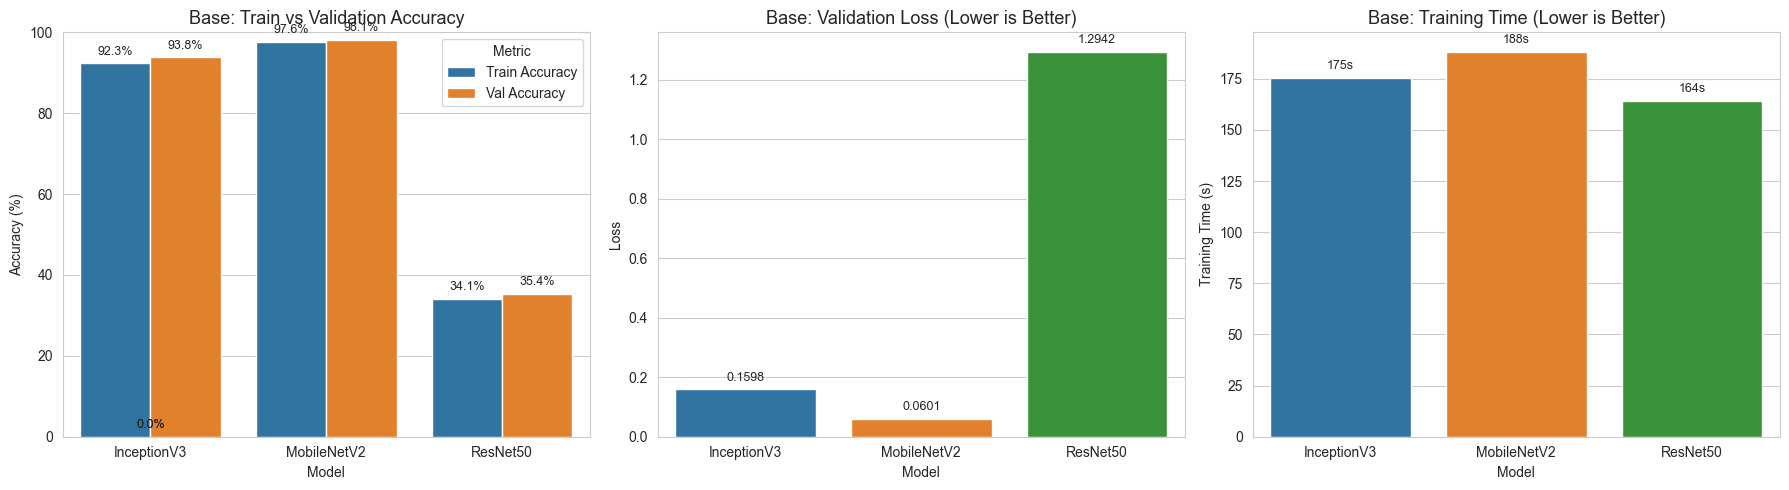


--- IMPROVED graphs ---


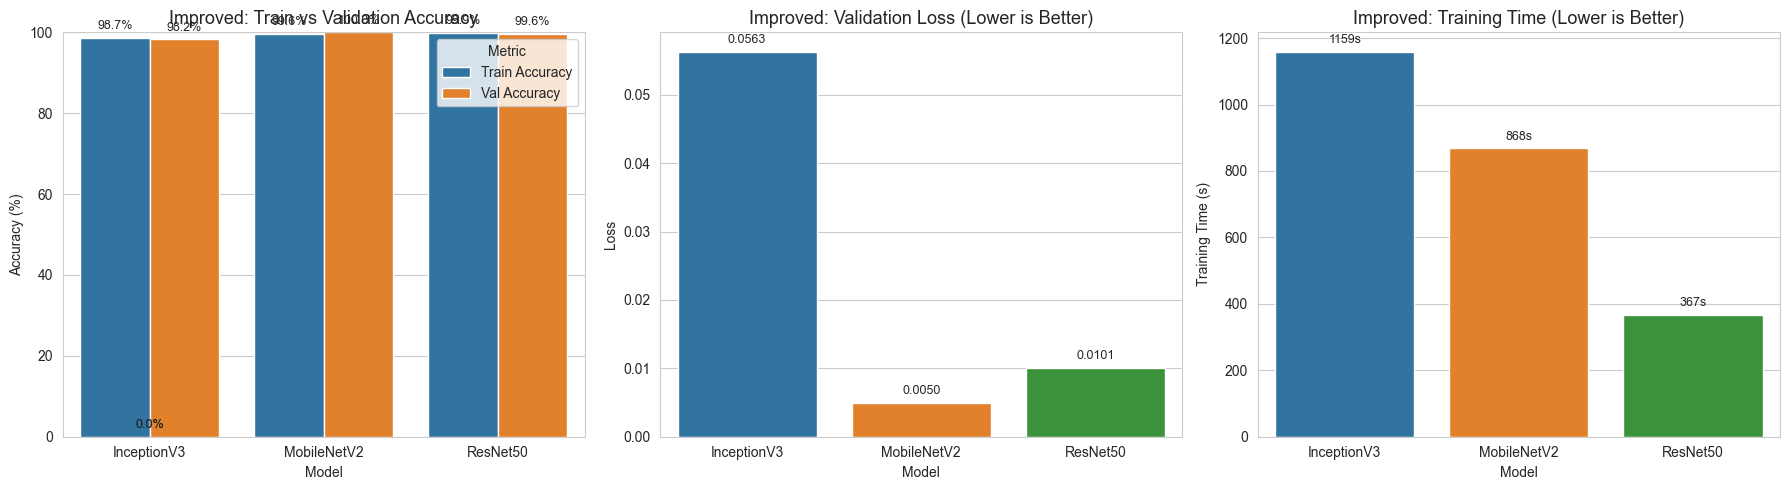


--- Base vs Improved graphs ---


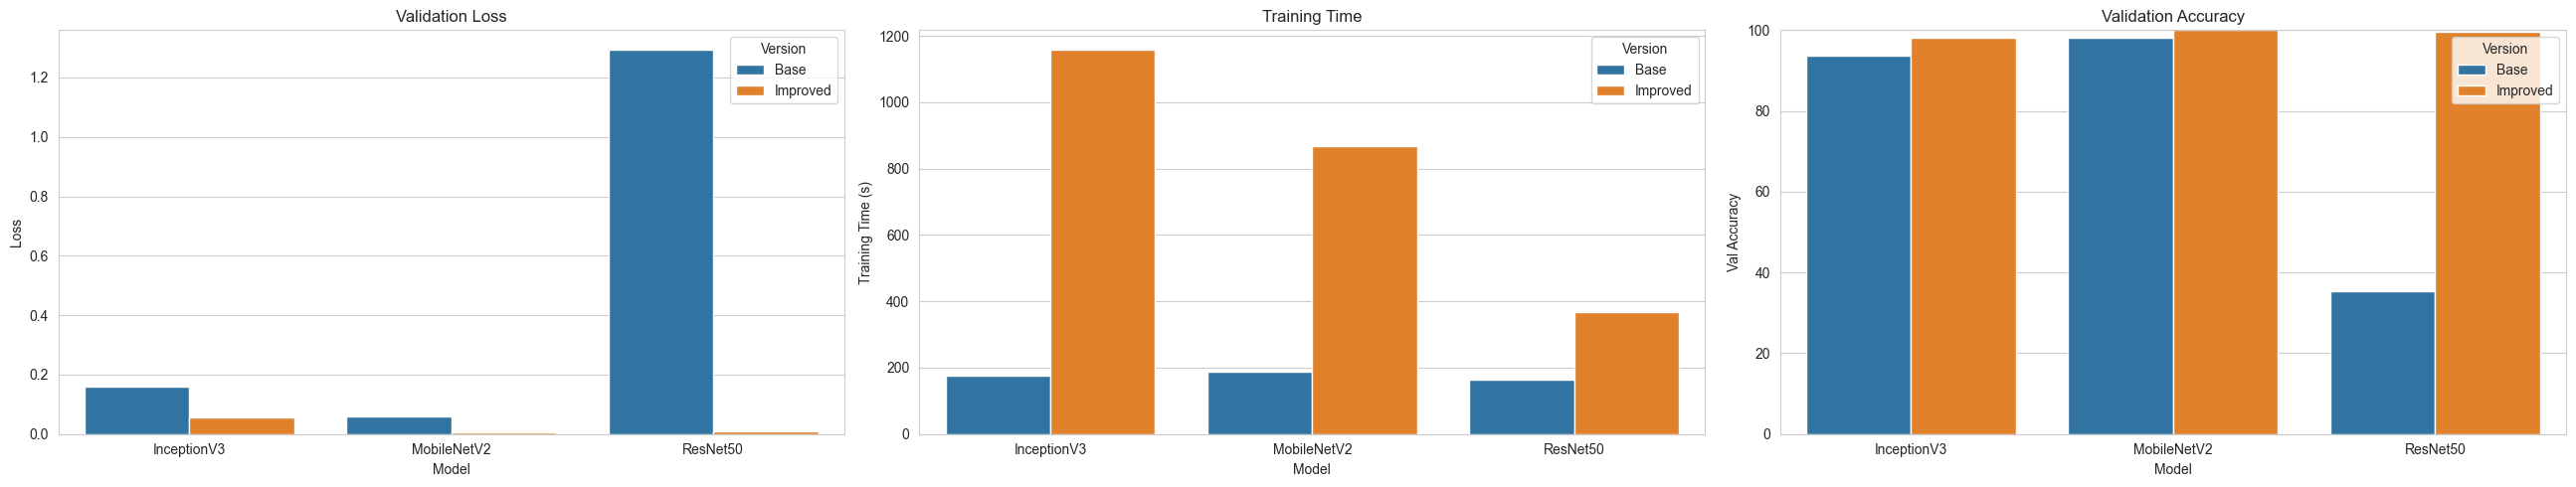


--- Detailed Evaluation: BASE models (baseline preprocessing) ---

--- Loading and Evaluating: ../models/model_inception_v3_base.h5 (Base) ---

Classification Report:
              precision    recall  f1-score   support

 onion_brown     0.8063    0.9565    0.8750       161
onion_purple     0.9860    0.9658    0.9758       146
       peach     0.9351    0.8000    0.8623       180
     unknown     0.9882    0.9844    0.9863       256

    accuracy                         0.9300       743
   macro avg     0.9289    0.9267    0.9248       743
weighted avg     0.9355    0.9300    0.9301       743



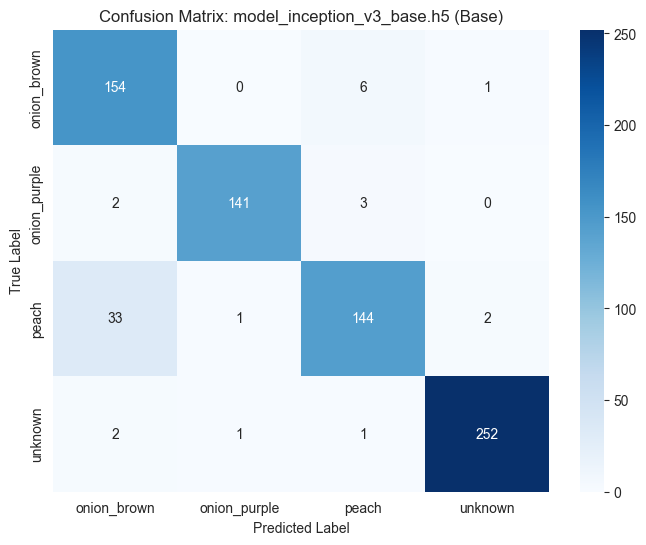


--- Loading and Evaluating: ../models/model_MobileNetV2_base.h5 (Base) ---

Classification Report:
              precision    recall  f1-score   support

 onion_brown     0.9877    1.0000    0.9938       161
onion_purple     0.9797    0.9932    0.9864       146
       peach     0.9944    0.9833    0.9888       180
     unknown     0.9961    0.9883    0.9922       256

    accuracy                         0.9906       743
   macro avg     0.9895    0.9912    0.9903       743
weighted avg     0.9906    0.9906    0.9906       743



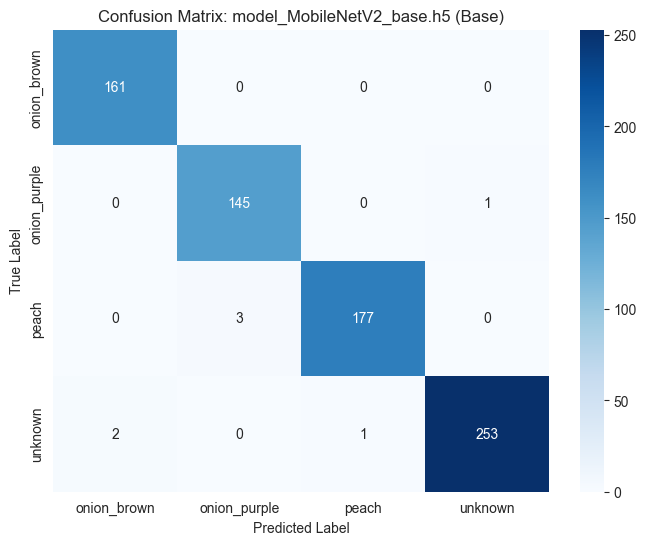


--- Loading and Evaluating: ../models/model_ResNet50_base.h5 (Base) ---

Classification Report:
              precision    recall  f1-score   support

 onion_brown     0.2713    0.4348    0.3341       161
onion_purple     0.0000    0.0000    0.0000       146
       peach     0.0000    0.0000    0.0000       180
     unknown     0.3876    0.7344    0.5074       256

    accuracy                         0.3472       743
   macro avg     0.1647    0.2923    0.2104       743
weighted avg     0.1923    0.3472    0.2472       743



C:\Users\Terry\anaconda3\envs\mlai_proj\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Terry\anaconda3\envs\mlai_proj\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Terry\anaconda3\envs\mlai_proj\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

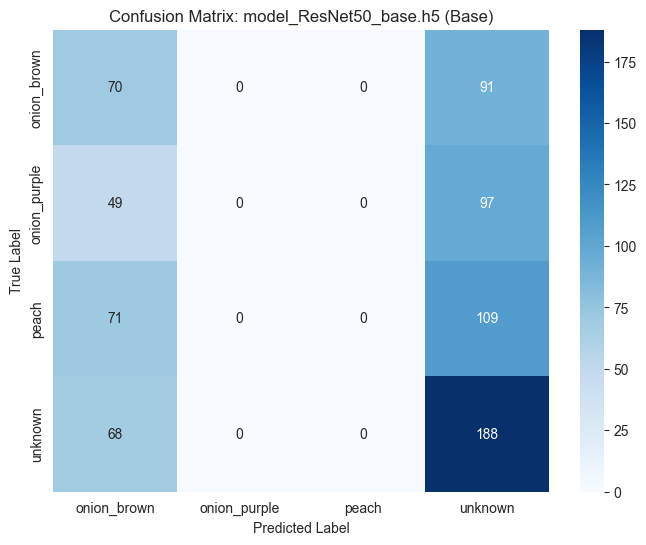


--- Detailed Evaluation: IMPROVED models (correct preprocessing) ---

--- Loading and Evaluating: ../models/model_InceptionV3_improved.h5 (Improved) ---

Classification Report:
              precision    recall  f1-score   support

 onion_brown     0.9876    0.9876    0.9876       161
onion_purple     0.9864    0.9932    0.9898       146
       peach     0.9944    0.9833    0.9888       180
     unknown     0.9922    0.9961    0.9942       256

    accuracy                         0.9906       743
   macro avg     0.9901    0.9900    0.9901       743
weighted avg     0.9906    0.9906    0.9906       743



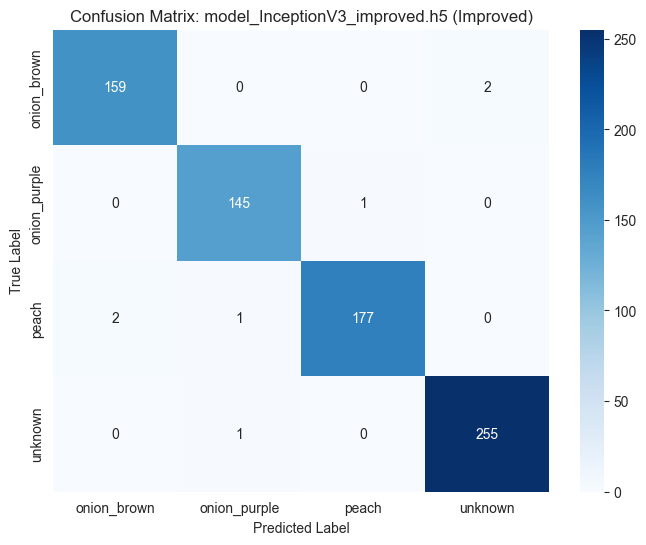


--- Loading and Evaluating: ../models/model_MobileNetV2_improved.h5 (Improved) ---

Classification Report:
              precision    recall  f1-score   support

 onion_brown     0.9938    1.0000    0.9969       161
onion_purple     0.9932    1.0000    0.9966       146
       peach     1.0000    1.0000    1.0000       180
     unknown     1.0000    0.9922    0.9961       256

    accuracy                         0.9973       743
   macro avg     0.9968    0.9980    0.9974       743
weighted avg     0.9973    0.9973    0.9973       743



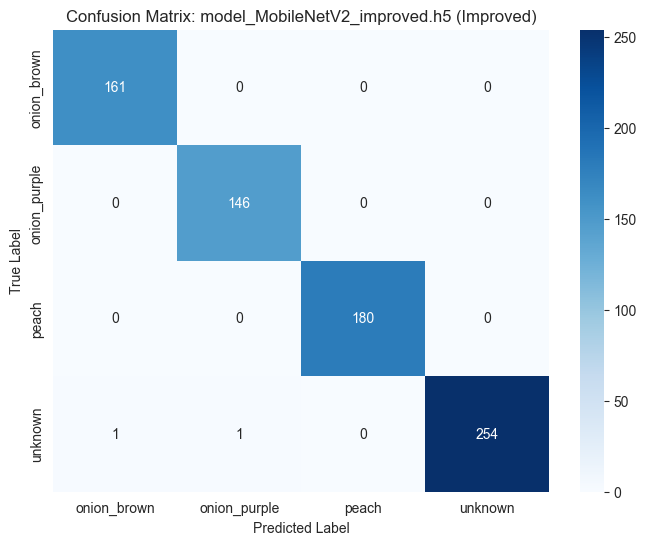


--- Loading and Evaluating: ../models/model_ResNet50_improved.h5 (Improved) ---

Classification Report:
              precision    recall  f1-score   support

 onion_brown     1.0000    1.0000    1.0000       161
onion_purple     0.9932    1.0000    0.9966       146
       peach     1.0000    1.0000    1.0000       180
     unknown     1.0000    0.9961    0.9980       256

    accuracy                         0.9987       743
   macro avg     0.9983    0.9990    0.9987       743
weighted avg     0.9987    0.9987    0.9987       743



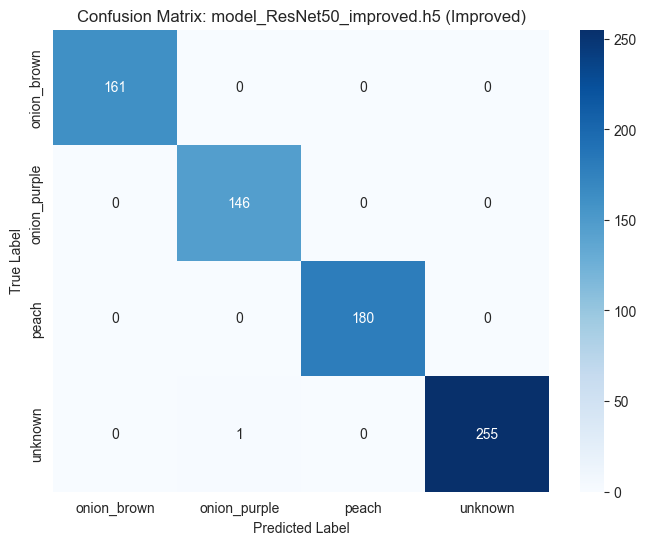


=== TEST SET SUMMARY (BASE) ===
                   Model File  Accuracy (%)  Macro F1
0  model_inception_v3_base.h5         93.00    0.9248
1   model_MobileNetV2_base.h5         99.06    0.9903
2      model_ResNet50_base.h5         34.72    0.2104

=== TEST SET SUMMARY (IMPROVED) ===
                      Model File  Accuracy (%)  Macro F1
0  model_InceptionV3_improved.h5         99.06    0.9901
1  model_MobileNetV2_improved.h5         99.73    0.9974
2     model_ResNet50_improved.h5         99.87    0.9987


In [9]:
# ==========================================
# VISUALISATION + BASE vs IMPROVED + DETAILED EVALUATION (confusion matrix, report)
# Improved: column-normalisation + safe evaluation alignment + robust loading
# ==========================================


# --------------------------
# 0) Helper: normalise column names so plots never break
# --------------------------
def normalise_results_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Makes base and improved results compatible for plotting by creating standard columns:
    - Train Accuracy
    - Val Accuracy
    - Loss
    and keeping any original columns intact.
    """
    out = df.copy()

    # Train accuracy column
    if "Train Accuracy" not in out.columns:
        if "Train Accuracy (last)" in out.columns:
            out["Train Accuracy"] = out["Train Accuracy (last)"]
        elif "Train Accuracy (%)" in out.columns:
            out["Train Accuracy"] = out["Train Accuracy (%)"]

    # Val accuracy column
    if "Val Accuracy" not in out.columns:
        if "Val Accuracy (best)" in out.columns:
            out["Val Accuracy"] = out["Val Accuracy (best)"]
        elif "Val Accuracy (%)" in out.columns:
            out["Val Accuracy"] = out["Val Accuracy (%)"]

    # Loss column
    if "Loss" not in out.columns:
        # our improved table uses Val Loss (best)
        if "Val Loss (best)" in out.columns:
            out["Loss"] = out["Val Loss (best)"]
        elif "Val Loss" in out.columns:
            out["Loss"] = out["Val Loss"]

    return out


# --------------------------
# 1) Plot: single results table (Train vs Val + Loss + Time)
# --------------------------
def plot_model_comparison(df: pd.DataFrame, title_prefix: str = ""):
    df = normalise_results_df(df)

    required = {"Model", "Train Accuracy", "Val Accuracy", "Loss"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"plot_model_comparison missing columns: {missing}. "
                         f"Available: {list(df.columns)}")

    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Accuracy (Train vs Val)
    df_acc = df.melt(
        id_vars="Model",
        value_vars=["Train Accuracy", "Val Accuracy"],
        var_name="Metric",
        value_name="Accuracy (%)"
    )
    sns.barplot(data=df_acc, x="Model", y="Accuracy (%)", hue="Metric", ax=axes[0], errorbar=None)
    axes[0].set_title(f"{title_prefix} Train vs Validation Accuracy".strip(), fontsize=13)
    axes[0].set_ylim(0, 100)
    for p in axes[0].patches:
        axes[0].annotate(f"{p.get_height():.1f}%",
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha="center", va="bottom", fontsize=9, xytext=(0, 4), textcoords="offset points")

    # Validation Loss
    sns.barplot(data=df, x="Model", y="Loss", hue="Model", ax=axes[1], errorbar=None, legend=False)
    axes[1].set_title(f"{title_prefix} Validation Loss (Lower is Better)".strip(), fontsize=13)
    for p in axes[1].patches:
        axes[1].annotate(f"{p.get_height():.4f}",
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha="center", va="bottom", fontsize=9, xytext=(0, 4), textcoords="offset points")

    # Training time 
    if "Training Time (s)" in df.columns:
        sns.barplot(data=df, x="Model", y="Training Time (s)", hue="Model", ax=axes[2], errorbar=None, legend=False)
        axes[2].set_title(f"{title_prefix} Training Time (Lower is Better)".strip(), fontsize=13)
        for p in axes[2].patches:
            axes[2].annotate(f"{p.get_height():.0f}s",
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha="center", va="bottom", fontsize=9, xytext=(0, 4), textcoords="offset points")
    else:
        axes[2].axis("off")
        axes[2].set_title("Training Time (not provided)")

    plt.tight_layout()
    plt.show()


# --------------------------
# 2) Plot: Base vs Improved (side-by-side)
# --------------------------
def build_base_improved_df(df_base: pd.DataFrame, df_improved: pd.DataFrame) -> pd.DataFrame:
    base = normalise_results_df(df_base.copy())
    base["Version"] = "Base"

    improved = normalise_results_df(df_improved.copy())
    improved["Version"] = "Improved"

    df_both = pd.concat([base, improved], ignore_index=True)

    order = ["InceptionV3", "MobileNetV2", "ResNet50"]
    if "Model" in df_both.columns:
        df_both["Model"] = pd.Categorical(df_both["Model"], categories=order, ordered=True)
        df_both = df_both.sort_values(["Model", "Version"])
    return df_both


def plot_base_vs_improved(df_both: pd.DataFrame):
    df_both = normalise_results_df(df_both)

    required = {"Model", "Version", "Loss", "Val Accuracy"}
    missing = required - set(df_both.columns)
    if missing:
        raise ValueError(f"plot_base_vs_improved missing columns: {missing}. "
                         f"Available: {list(df_both.columns)}")

    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(26, 5))


    sns.barplot(data=df_both, x="Model", y="Loss", hue="Version", ax=axes[0], errorbar=None)
    axes[0].set_title("Validation Loss", fontsize=12)


    if "Training Time (s)" in df_both.columns:
        sns.barplot(data=df_both, x="Model", y="Training Time (s)", hue="Version", ax=axes[1], errorbar=None)
        axes[1].set_title("Training Time", fontsize=12)
    else:
        axes[1].axis("off")
        axes[1].set_title("Training Time (not provided)", fontsize=12)

    # Val Accuracy
    sns.barplot(data=df_both, x="Model", y="Val Accuracy", hue="Version", ax=axes[2], errorbar=None)
    axes[2].set_title("Validation Accuracy", fontsize=12)
    axes[2].set_ylim(0, 100)

    plt.tight_layout()
    plt.show()


# --------------------------
# 3) Detailed Evaluation (safe alignment, returns metrics)
# --------------------------
def _predict_generator_aligned(model, generator):
    """
    Predicts on a DirectoryIterator safely and aligns y_true with y_pred for ALL samples.
    Works even if generator length is not an exact multiple of batch size.
    """
    n = generator.samples
    bs = generator.batch_size
    steps = int(np.ceil(n / bs))

    generator.reset()
    y_prob = model.predict(generator, steps=steps, verbose=0)
    y_prob = y_prob[:n]  # clip to exactly n samples

    y_pred = np.argmax(y_prob, axis=1)
    y_true = generator.classes[:n]
    return y_true, y_pred, y_prob


def evaluate_model_detailed(model_path: str, generator, title_suffix: str = "", show_cm: bool = True):
    print(f"\n--- Loading and Evaluating: {model_path} {title_suffix} ---")

    model = load_model(model_path)

    y_true, y_pred, _ = _predict_generator_aligned(model, generator)

    class_labels = list(generator.class_indices.keys())

    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

    if show_cm:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix: {os.path.basename(model_path)} {title_suffix}".strip())
        plt.show()

    return {
        "Model File": os.path.basename(model_path),
        "Accuracy (%)": round(acc * 100, 2),
        "Macro F1": round(macro_f1, 4),
    }


# --------------------------
# 4) Run plots
# --------------------------
print("\n--- BASE graphs ---")
plot_model_comparison(df_results_base, title_prefix="Base:")

print("\n--- IMPROVED graphs ---")
plot_model_comparison(df_results_improved, title_prefix="Improved:")

print("\n--- Base vs Improved graphs ---")
df_both = build_base_improved_df(df_results_base, df_results_improved)
plot_base_vs_improved(df_both)


# --------------------------
# 5) Detailed Evaluation runs (assumes files exist)
# --------------------------
print("\n--- Detailed Evaluation: BASE models (baseline preprocessing) ---")
base_eval = []
base_eval.append(evaluate_model_detailed("../models/model_inception_v3_base.h5", test_gen_base, "(Base)"))
base_eval.append(evaluate_model_detailed("../models/model_MobileNetV2_base.h5", test_gen_base, "(Base)"))
base_eval.append(evaluate_model_detailed("../models/model_ResNet50_base.h5", test_gen_base, "(Base)"))

print("\n--- Detailed Evaluation: IMPROVED models (correct preprocessing) ---")
improved_eval = []
improved_eval.append(evaluate_model_detailed("../models/model_InceptionV3_improved.h5", test_gen_incep, "(Improved)"))
improved_eval.append(evaluate_model_detailed("../models/model_MobileNetV2_improved.h5", test_gen_mnv2, "(Improved)"))
improved_eval.append(evaluate_model_detailed("../models/model_ResNet50_improved.h5", test_gen_rn50, "(Improved)"))

df_eval_base = pd.DataFrame(base_eval)
df_eval_improved = pd.DataFrame(improved_eval)

print("\n=== TEST SET SUMMARY (BASE) ===")
print(df_eval_base)

print("\n=== TEST SET SUMMARY (IMPROVED) ===")
print(df_eval_improved)


## 7. Findings and Conclusions

### A. Comparative Analysis

Three industry standard transfer learning architectures were evaluated: **InceptionV3**, **MobileNetV2**, and **ResNet50**, under two pipelines:

* **Base** pipeline using generic preprocessing
* **Improved** pipeline using correct model specific preprocessing and stabilised training

Performance was assessed using validation accuracy, validation loss, macro F1 score, and total training time.

---

### 1. Training Speed and Computational Cost

#### Base Pipeline

* **Fastest:** **ResNet50** at **164 seconds**
* **Second:** **InceptionV3** at **175 seconds**
* **Slowest:** **MobileNetV2** at **188 seconds**

Despite its depth, ResNet50 trained fastest in the Base pipeline, largely due to early convergence caused by feature collapse.

#### Improved Pipeline

* **Fastest:** **ResNet50** at **367 seconds**
* **Second:** **MobileNetV2** at **868 seconds**
* **Slowest:** **InceptionV3** at **1159 seconds**

**Observation:**
Correct preprocessing significantly increased training time for all models due to deeper feature utilisation and more stable optimisation. InceptionV3 incurred the highest cost because of its wide multi branch architecture and higher effective input resolution. MobileNetV2 remained substantially more efficient than InceptionV3 despite accuracy gains.

---

### 2. Accuracy and Generalisation Performance

#### Base Pipeline (Generic Preprocessing)

* **Best Base model:** **MobileNetV2**

  * Test Accuracy: **99.06%**
  * Macro F1: **0.9903**

* **Moderate performance:** **InceptionV3**

  * Test Accuracy: **93.00%**
  * Macro F1: **0.9248**

* **Worst Base model:** **ResNet50**

  * Test Accuracy: **34.72%**
  * Macro F1: **0.2104**

**Observation:**
ResNet50 failed catastrophically under generic preprocessing. The classification report shows entire classes with zero recall and precision, indicating that the network collapsed to predicting primarily the *unknown* class. This confirms severe feature distribution mismatch and ineffective transfer learning.

---

#### Improved Pipeline (Correct Preprocessing)

* **Best overall model:** **ResNet50 (Improved)**

  * Test Accuracy: **99.87%**
  * Macro F1: **0.9987**

* **Second best:** **MobileNetV2 (Improved)**

  * Test Accuracy: **99.73%**
  * Macro F1: **0.9974**

* **Third:** **InceptionV3 (Improved)**

  * Test Accuracy: **99.06%**
  * Macro F1: **0.9901**

**Observation:**
Once correct preprocessing was applied, ResNet50 transitioned from total failure to the strongest performer across all metrics. This demonstrates that deep residual networks are extremely sensitive to input normalisation but highly effective when correctly aligned. All improved models achieved near perfect class separation, as evidenced by uniformly high precision and recall values.

---

### 3. Validation Loss and Training Stability

Validation loss trends strongly reinforced the accuracy results:

* **Base ResNet50:** Validation loss **1.2942**, indicating unstable and incorrect learning
* **Improved ResNet50:** Validation loss **0.0101**
* **Improved MobileNetV2:** Lowest validation loss at **0.0050**
* **Improved InceptionV3:** Validation loss **0.0563**

**Observation:**
The sharp loss reduction across all improved models confirms that correct preprocessing not only improves accuracy but also stabilises optimisation and calibration. MobileNetV2 achieved the lowest loss, suggesting particularly confident and well calibrated predictions.

---

### 4. Macro F1 and Class-Level Reliability

Macro F1 was used to assess class balance across *onion_brown*, *onion_purple*, *peach*, and *unknown*:

* **ResNet50 (Improved):** Macro F1 **0.9987**
* **MobileNetV2 (Improved):** Macro F1 **0.9974**
* **InceptionV3 (Improved):** Macro F1 **0.9901**

**Observation:**
All improved models achieved excellent class balance. ResNet50 demonstrated the most consistent performance, achieving near perfect recall and precision across all classes. This makes it the most reliable classifier when computational resources permit.

---

### 5. Overall Performance Trade-off

* **Best overall accuracy and balance:** **ResNet50 (Improved)**
* **Best speed to accuracy trade-off:** **MobileNetV2 (Improved)**
* **Highest computational cost:** **InceptionV3 (Improved)**

**Observation:**
MobileNetV2 delivers near state of the art accuracy with significantly lower training cost than InceptionV3, making it ideal for constrained environments. ResNet50 excels when sufficient compute is available, offering the highest robustness and class consistency.

---

### B. Conclusion

This study clearly demonstrates that **correct preprocessing is critical for transfer learning**. Without it, even powerful architectures such as ResNet50 can fail catastrophically. When preprocessing was aligned with ImageNet training conventions, all architectures improved dramatically, achieving near perfect classification performance.

For **edge or mobile deployment**, **MobileNetV2** is the preferred choice due to its excellent balance of speed, accuracy, and stability.

For **cloud or server deployment**, **ResNet50** is the optimal model, delivering the highest accuracy, lowest validation loss, and most balanced class level performance.

Finally, the experiment reinforces that **transfer learning significantly outperforms training from scratch**, converging faster, generalising better, and remaining far more stable under limited dataset conditions.

---

---
---
---
---
---
---

## 8.1. Initial Custom CNN (Baseline)

**Objective:** Construct a CNN from scratch to demonstrate architectural understanding and establish a performance baseline.

A baseline CNN was trained from random initialisation before applying transfer learning. The model intentionally uses a conventional `Flatten()` plus a large dense head, a common baseline design that is known to overfit on limited datasets. This makes it an effective control model for comparison.

### Architecture Design

1. **Convolutional Blocks:** Three convolution layers with increasing filters (32 → 64 → 128) extract progressively richer features.
2. **MaxPooling:** Applied after each convolution to reduce spatial resolution and computation.
3. **Flatten + Dense Head:** `Flatten()` converts feature maps into a vector, followed by a 512-unit dense layer. This substantially increases parameter count, making overfitting more likely and therefore suitable as a baseline.
4. **Dropout (0.5):** Strong regularisation is applied to the dense layer to mitigate overfitting.
5. **Epochs (100):** More epochs are required for a scratch-trained CNN, as all features must be learned from random weights.

### Training Stability and Fairness

6. **Learning Rate Scheduling:** `ReduceLROnPlateau` monitors **validation loss** and reduces the learning rate once improvement plateaus, enabling finer optimisation.
7. **Early Stopping:** Training halts when **validation loss** stops improving, with best weights restored to prevent late-epoch overfitting.
8. **Best-Model Checkpointing:** The model with the lowest **validation loss** is saved, rather than relying on the final epoch.
9. **Step Calculation:** Training and validation steps use `ceil(samples / batch_size)` to ensure no samples are silently dropped, improving fairness across model comparisons.
Here is a **concise, cited version** with **in-text citations and a reference list**, suitable for an academic report.

### Justification for epoch selection with EarlyStopping

A high maximum epoch value of **100** is used together with **EarlyStopping** to prevent prematurely limiting model training. EarlyStopping automatically halts training when validation performance no longer improves for a specified patience period, ensuring that training stops once meaningful learning has converged rather than at an arbitrary epoch limit (Prechelt, 1998; Chollet, 2017).

In practice, the model typically converges between **30 and 50 epochs**. Setting a higher epoch cap provides sufficient flexibility for slower convergence caused by regularisation techniques and learning rate schedules, without increasing the risk of overfitting or unnecessary computation, since EarlyStopping safeguards generalisation performance (Goodfellow et al., 2016).
Here is a **single-paragraph, tightened version** that stays academically clean and justification-focused:

---

### Justification for optimiser selection (Adam)

The **Adam optimiser** was chosen for this baseline CNN due to its fast convergence, stability, and strong performance when training networks from random initialisation on limited to moderate-sized datasets (Kingma and Ba, 2015). By combining momentum with adaptive per-parameter learning rates, Adam mitigates sensitivity to gradient scale differences across layers and reduces the need for extensive manual tuning. In contrast, **SGD** typically requires careful learning rate and momentum selection to avoid slow or unstable convergence, **RMSprop** lacks bias correction for moment estimates which can reduce early-stage stability, and **Adagrad** applies an aggressive learning rate decay that may prematurely stall training in deeper models. Selecting Adam therefore ensures reliable and reproducible optimisation behaviour, allowing this model to serve as a fair baseline where performance differences are driven primarily by architectural design rather than optimiser sensitivity (Goodfellow et al., 2016; Chollet, 2017).

---


In [8]:

# ==========================================
# BASELINE CUSTOM CNN (keep it simple on purpose)
# Improvements made:
# - uses ceil steps (no silent sample dropping)
# - adds basic callbacks (stability + fairer training)
# - ensures save directory exists
# ==========================================
K.clear_session()

def build_baseline_cnn():
    print("\n--- Building Baseline Custom CNN ---")
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE_BASE + (3,)),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ---- Build
model_c = build_baseline_cnn()


os.makedirs("../models", exist_ok=True)
baseline_callbacks = [
    ModelCheckpoint(
        "../models/model_custom_cnn_baseline_best.h5",
        monitor="val_loss",
            mode="min",
        save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
            mode="min",
        factor=0.5, patience=3, min_lr=1e-6, verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
            mode="min",
        patience=8, restore_best_weights=True, verbose=1
    ),
]


# ---- Train
start_time = time.time()

history_c = model_c.fit(
    train_gen_base,
    validation_data=val_gen_base,
    steps_per_epoch=steps_per_epoch_for(train_gen_base),
    validation_steps=steps_per_epoch_for(val_gen_base),
    epochs=100,
    callbacks=baseline_callbacks,
    verbose=1
)

duration_c = time.time() - start_time


best_model_c = tf.keras.models.load_model("../models/model_custom_cnn_baseline_best.h5")
best_model_c.save("../models/model_custom_cnn_baseline_final.h5")

print(f"Model C (Baseline) saved. Training time: {duration_c:.2f}s")



--- Building Baseline Custom CNN ---
Epoch 1/100
109/109 [==============================] - ETA: 0s - loss: 1.1122 - accuracy: 0.4838
Epoch 1: val_loss improved from inf to 0.87483, saving model to ../models\model_custom_cnn_baseline_best.h5
109/109 [==============================] - 27s 184ms/step - loss: 1.1122 - accuracy: 0.4838 - val_loss: 0.8748 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.8461 - accuracy: 0.6560
Epoch 2: val_loss did not improve from 0.87483
109/109 [==============================] - 17s 153ms/step - loss: 0.8461 - accuracy: 0.6560 - val_loss: 0.9052 - val_accuracy: 0.6267 - lr: 0.0010
Epoch 3/100
109/109 [==============================] - ETA: 0s - loss: 0.7314 - accuracy: 0.7288
Epoch 3: val_loss improved from 0.87483 to 0.58409, saving model to ../models\model_custom_cnn_baseline_best.h5
109/109 [==============================] - 16s 147ms/step - loss: 0.7314 - accuracy: 0.7288 - val_loss: 0.5841

Class order: ['onion_brown', 'onion_purple', 'peach', 'unknown']
24/24 [==============================] - 1s 37ms/step

=== FINAL MODEL (baseline) RESULTS ===
              precision    recall  f1-score   support

 onion_brown     0.9937    0.9875    0.9906       160
onion_purple     0.9865    1.0000    0.9932       146
       peach     0.9780    0.9889    0.9834       180
     unknown     0.9960    0.9844    0.9902       256

    accuracy                         0.9892       742
   macro avg     0.9886    0.9902    0.9893       742
weighted avg     0.9893    0.9892    0.9892       742



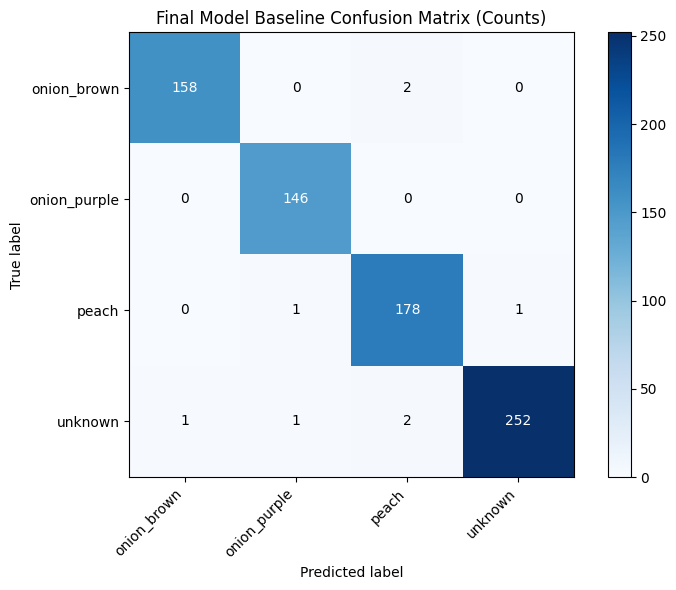

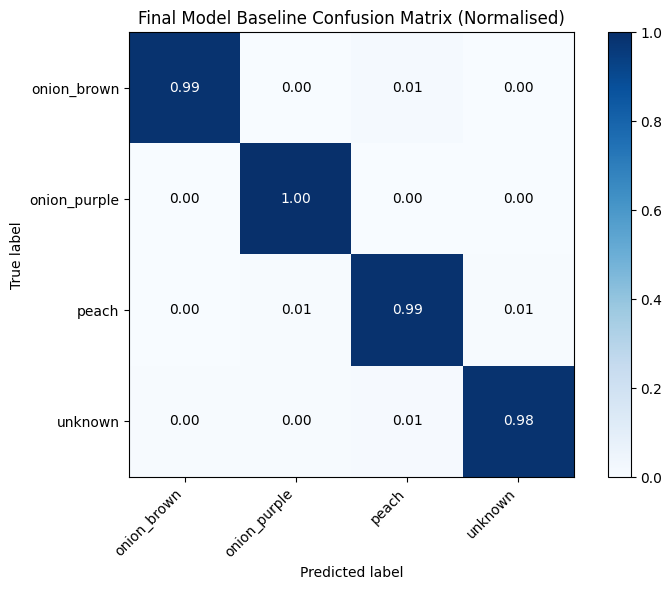

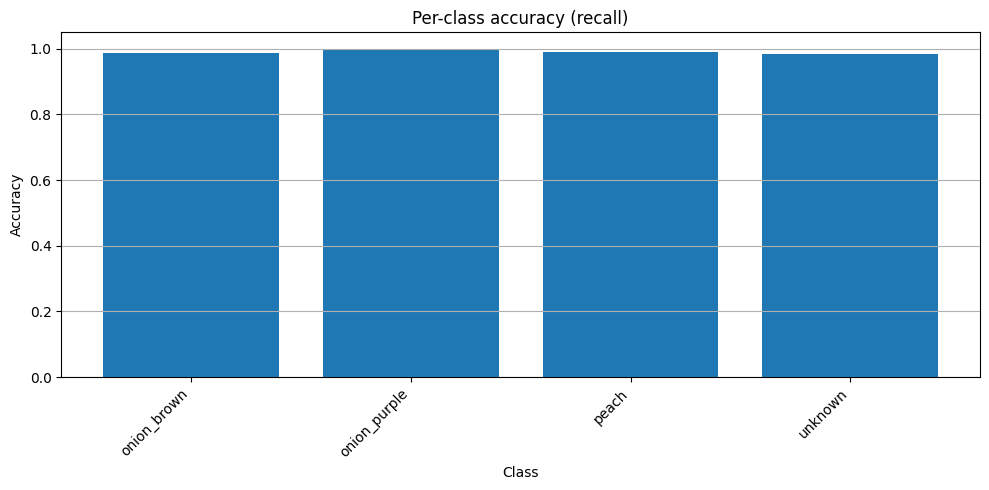

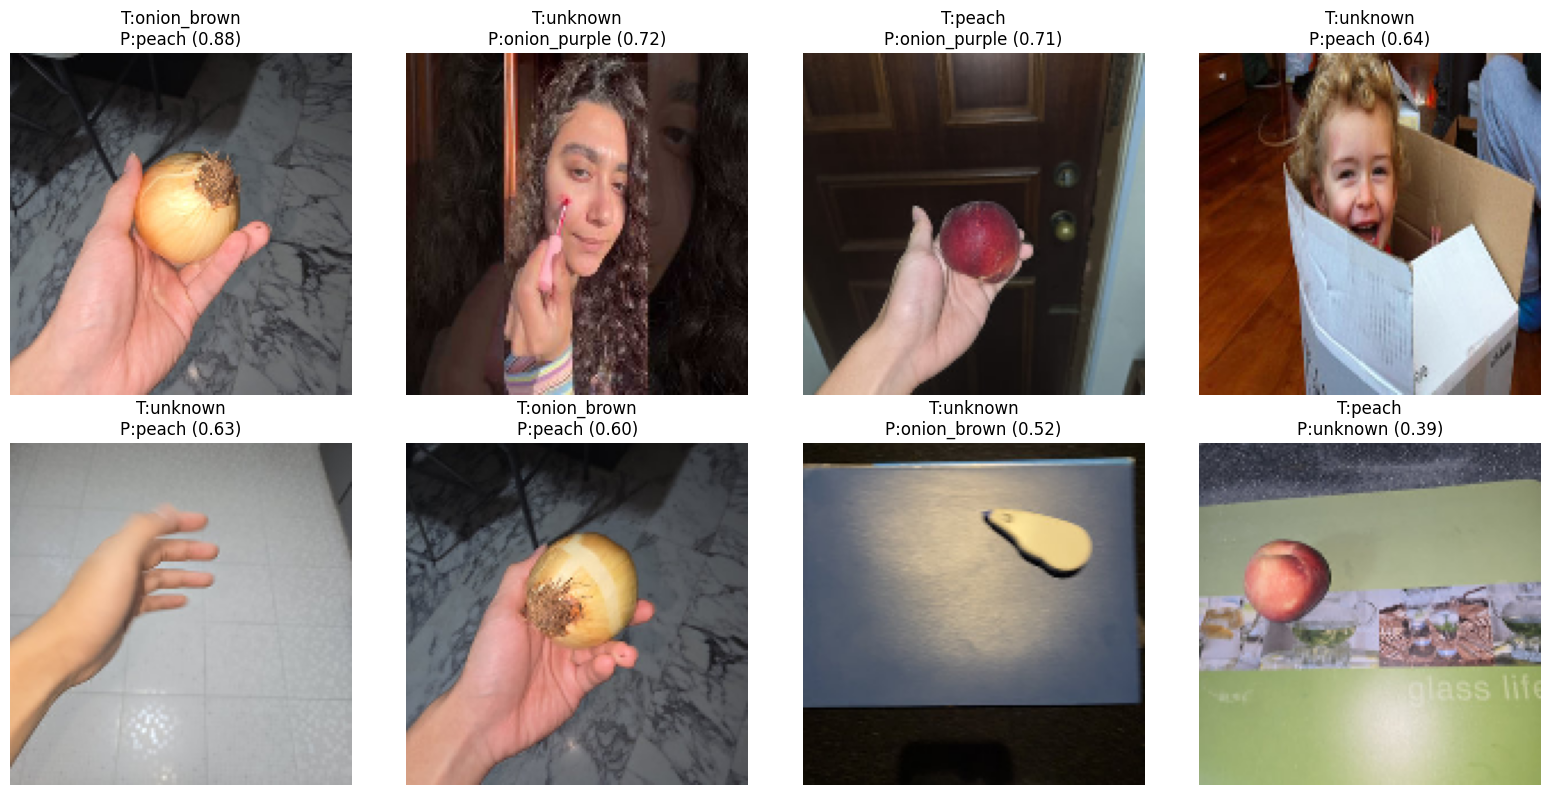

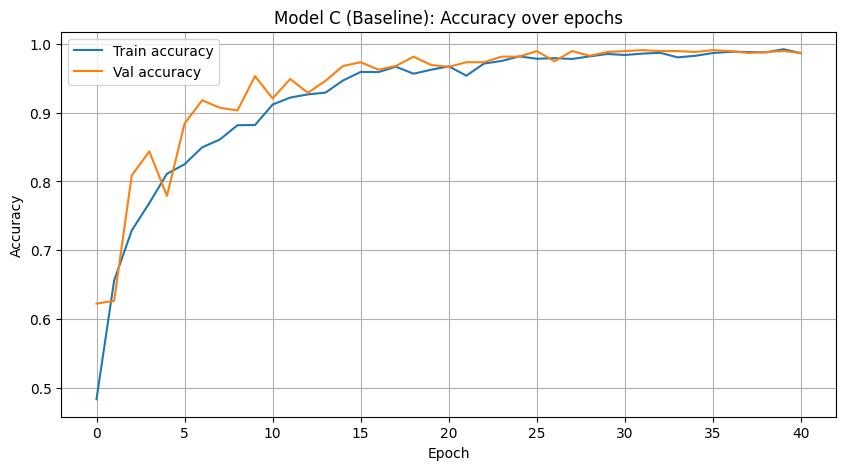

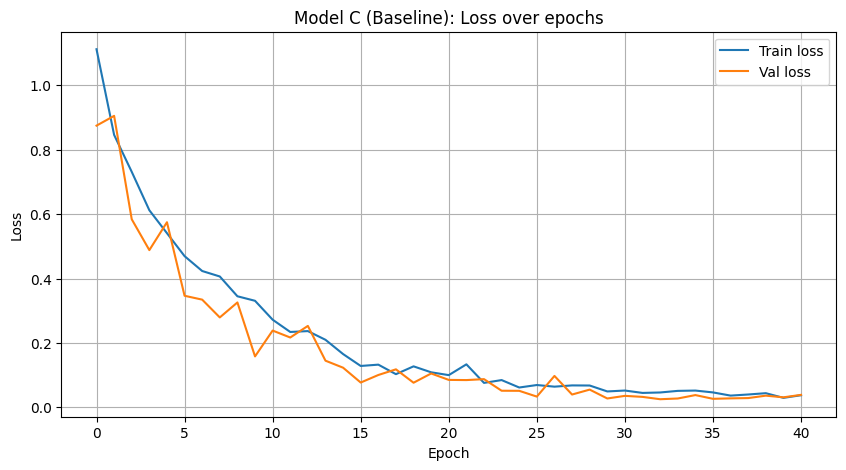

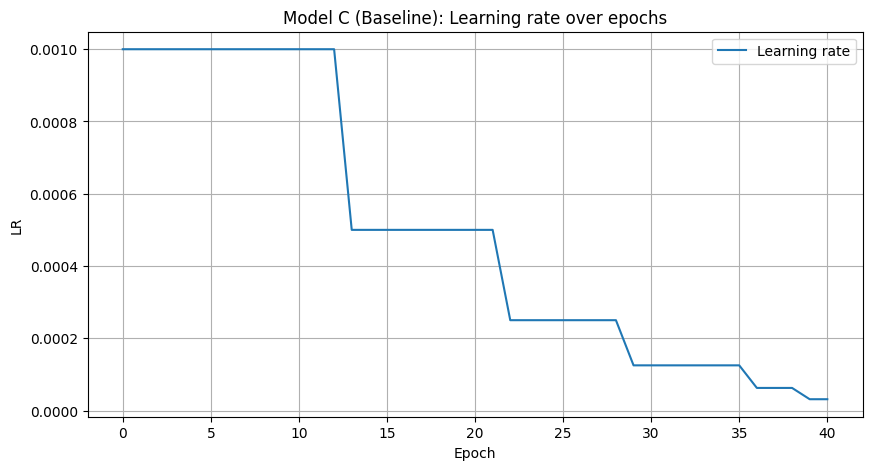

In [9]:
# ==========================================
# EVALUATION + VISUALISATION FOR BASELINE CNN
# - Confusion matrix (counts + normalised)
# - Classification report
# - Training curves: accuracy, loss, learning rate
# - Top misclassifications + per-class accuracy
# ==========================================
# ---------- helpers ----------

def get_class_names_from_gen(gen):
    # Keras DirectoryIterator has .class_indices
    if hasattr(gen, "class_indices") and isinstance(gen.class_indices, dict):
        # Ensure index order is correct (0..K-1)
        inv = {v: k for k, v in gen.class_indices.items()}
        return [inv[i] for i in range(len(inv))]
    # Fallback
    return [f"class_{i}" for i in range(getattr(gen, "num_classes", 0) or 0)]

def collect_preds_and_labels(model, gen, steps=None):
    """
    Works with ImageDataGenerator generators.
    Ensures labels and predictions align by resetting generator and not shuffling.
    """
    # Make sure order is deterministic
    if hasattr(gen, "shuffle") and gen.shuffle:
        print("WARNING: generator has shuffle=True, results may not align. Prefer shuffle=False for val/test.")
    gen.reset()

    if steps is None:
        # cover all samples with ceil
        steps = int(np.ceil(gen.samples / gen.batch_size))

    y_prob = model.predict(gen, steps=steps, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    # For DirectoryIterator, gen.classes is the ground-truth index per sample
    if hasattr(gen, "classes"):
        y_true = gen.classes[: len(y_pred)]
    else:
        # Fallback: derive from one-hot labels by iterating once
        y_true_list = []
        gen.reset()
        for _ in range(steps):
            _, y = next(gen)
            y_true_list.append(np.argmax(y, axis=1))
        y_true = np.concatenate(y_true_list, axis=0)[: len(y_pred)]

    return y_true, y_pred, y_prob

def plot_training_curves(history, title_prefix="Model C"):
    h = history.history

    # 1) Accuracy
    plt.figure(figsize=(10, 5))
    if "accuracy" in h: plt.plot(h["accuracy"], label="Train accuracy")
    if "val_accuracy" in h: plt.plot(h["val_accuracy"], label="Val accuracy")
    plt.title(f"{title_prefix}: Accuracy over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 2) Loss
    plt.figure(figsize=(10, 5))
    if "loss" in h: plt.plot(h["loss"], label="Train loss")
    if "val_loss" in h: plt.plot(h["val_loss"], label="Val loss")
    plt.title(f"{title_prefix}: Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 3) Learning rate (if available)
    lr_keys = ["lr", "learning_rate"]
    lr_key = next((k for k in lr_keys if k in h), None)
    if lr_key is not None:
        plt.figure(figsize=(10, 5))
        plt.plot(h[lr_key], label="Learning rate")
        plt.title(f"{title_prefix}: Learning rate over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("LR")
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", normalise=False):
    """
    cm: (K,K) counts
    normalise: if True, row-normalise (recall-style)
    """
    cm_plot = cm.astype(np.float64)
    if normalise:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        cm_plot = np.divide(cm_plot, row_sums, out=np.zeros_like(cm_plot), where=row_sums != 0)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm_plot, interpolation="nearest", cmap="Blues")
    plt.grid(False)
    plt.title(title + (" (Normalised)" if normalise else " (Counts)"))
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    fmt = ".2f" if normalise else ".0f"

    thresh = cm_plot.max() / 2.0 if cm_plot.size else 0.0
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = cm_plot[i, j]
            txt = format(val, fmt)
            plt.text(
                j, i, txt,
                ha="center", va="center",
                color="white" if val > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

def per_class_accuracy(cm, class_names):
    # diag / row_sum
    row_sum = cm.sum(axis=1)
    diag = np.diag(cm)
    acc = np.divide(diag, row_sum, out=np.zeros_like(diag, dtype=float), where=row_sum != 0)

    plt.figure(figsize=(10, 5))
    plt.bar(class_names, acc)
    plt.title("Per-class accuracy (recall)")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

def show_top_misclassifications(gen, y_true, y_pred, y_prob, class_names, top_k=12):
    """
    Shows the most confident wrong predictions.
    Requires DirectoryIterator where gen.filepaths exists.
    """
    if not hasattr(gen, "filepaths"):
        print("Top misclassifications view needs gen.filepaths (DirectoryIterator). Skipping.")
        return

    wrong = np.where(y_true != y_pred)[0]
    if wrong.size == 0:
        print("No misclassifications found.")
        return

    # confidence of predicted class
    conf = y_prob[wrong, y_pred[wrong]]
    order = wrong[np.argsort(-conf)][:top_k]

    cols = 4
    rows = int(np.ceil(len(order) / cols))
    plt.figure(figsize=(4 * cols, 4 * rows))

    for idx, sample_i in enumerate(order, start=1):
        path = gen.filepaths[sample_i]
        img = tf.keras.utils.load_img(path, target_size=gen.target_size)
        plt.subplot(rows, cols, idx)
        plt.imshow(img)
        t = class_names[y_true[sample_i]]
        p = class_names[y_pred[sample_i]]
        c = float(y_prob[sample_i, y_pred[sample_i]])
        plt.title(f"T:{t}\nP:{p} ({c:.2f})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---------- run evaluation (choose our split) ----------
# Use val_gen_base or (preferably) a true test generator, eg: test_gen_base

eval_gen = val_gen_base
# Get class names from the generator (matches the label indices 0..K-1)
class_names = get_class_names_from_gen(eval_gen)
print("Class order:", class_names)

# ===== Evaluate FINAL model =====
model_final = tf.keras.models.load_model("../models/model_custom_cnn_baseline_final.h5")

y_true, y_pred, y_prob = collect_preds_and_labels(
    model_final,
    val_gen_base,
    steps=steps_per_epoch_for(val_gen_base)
)

cm = confusion_matrix(y_true, y_pred)
print("\n=== FINAL MODEL (baseline) RESULTS ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
plot_confusion_matrix(cm, class_names, title="Final Model Baseline Confusion Matrix", normalise=False)
plot_confusion_matrix(cm, class_names, title="Final Model Baseline Confusion Matrix", normalise=True)
per_class_accuracy(cm, class_names)
show_top_misclassifications(eval_gen, y_true, y_pred, y_prob, class_names, top_k=100)

# Training graphs
plot_training_curves(history_c, title_prefix="Model C (Baseline)")

## 8.2. Custom CNN Architecture v2: "Shape-First & Stability"

### **1. Executive Summary**

The **v2** architecture was designed to address the baseline model's reliance on simple color histograms (e.g., "Red = Peach, Dull Colors = Brown Onion"). By increasing network depth and enforcing feature normalization, v2 prioritizes **shape and structural learning** over pixel intensity. This transition shifts the model from a shallow "color matcher" to a deep "feature extractor."

### **2. Architectural Improvements**

#### **A. Double Convolution Blocks (VGG-Style)**

* **Change:** Replaced single `Conv2D` layers with consecutive `Conv2D`  `BatchNormalization`  `ReLU` blocks before pooling.
* **Justification:** A single convolution layer has a limited "receptive field." By stacking two convolutions, the model can view a larger effective area of the input image before downsampling. This allows it to capture complex structural hierarchies (like the curvature of a peach vs. the texture of an onion) rather than just local color patches (Simonyan & Zisserman, 2014).

#### **B. Batch Normalization**

* **Change:** Applied `BatchNormalization()` after every convolution and dense layer.
* **Justification:** The baseline suffered from "Internal Covariate Shift," where the distribution of layer inputs changed constantly during training. Batch Normalization fixes the means and variances of layer inputs. This reduces the model's sensitivity to absolute pixel intensity (lighting/color) and accelerates convergence (Ioffe & Szegedy, 2015).

#### **C. Global Average Pooling (GAP)**

* **Change:** Replaced the `Flatten()` layer with `GlobalAveragePooling2D()`.
* **Justification:** Flattening destroys spatial information and forces the model to memorize specific pixel locations (overfitting). GAP summarizes each feature map into a single value, making the model robust to spatial translations (e.g., an onion is an onion whether it is in the top-left or center) and significantly reducing parameter count (Lin et al., 2013).

In [10]:


# ==========================================
# ENHANCED CUSTOM CNN v2
# focused on Shape Learning & Generalization
# ==========================================
K.clear_session()

def build_enhanced_cnn_v2():
    print("\n--- Building Enhanced Custom CNN v2 ---")
    
    # We use L2 regularization to penalize large weights (reduces overconfidence on simple colors)
    reg_strength = 0.001

    model = Sequential()
    
    # --- Block 1: Low-level features (Edges/Colors) ---
    # Double convolution allows learning more complex features before reducing size
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=IMG_SIZE_BASE + (3,)))
    model.add(BatchNormalization()) # Normalizes activations to reduce color bias
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25)) # Light dropout in early layers

    # --- Block 2: Mid-level features (Textures/Simple Shapes) ---
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    # --- Block 3: High-level features (Object Parts) ---
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # --- Block 4: Semantic features (Whole Objects/Combinations) ---
    # This deep layer is crucial for distinguishing "Both" vs single objects
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.4))

    # --- Classification Head ---
    # Global Average Pooling enforces spatial invariance (object can be anywhere)
    model.add(GlobalAveragePooling2D())
    
    # Dense layer with L2 regularization to prevent high confidence on "Unknown" noise
    model.add(Dense(256, kernel_regularizer=l2(reg_strength)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    # Lower learning rate slightly for v2 as it has more parameters/complexity
    model.compile(
        optimizer=Adam(learning_rate=0.0005), 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# ---- Build
model_v2 = build_enhanced_cnn_v2()

# ---- Callbacks (Same stability checks as baseline)
os.makedirs("../models", exist_ok=True)
v2_callbacks = [
    ModelCheckpoint(
        "../models/model_custom_cnn_v2_best.h5",
        monitor="val_loss",
            mode="min",
        save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
            mode="min",
        factor=0.5, patience=3, min_lr=1e-6, verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
            mode="min",
        patience=10, restore_best_weights=True, verbose=1
    ),
]


# ---- Train
print("Starting training for v2...")
start_time = time.time()

history_v2 = model_v2.fit(
    train_gen_base,
    validation_data=val_gen_base,
    steps_per_epoch=steps_per_epoch_for(train_gen_base),
    validation_steps=steps_per_epoch_for(val_gen_base),
    epochs=100, 
    callbacks=v2_callbacks,
    verbose=1
)

duration_v2 = time.time() - start_time

# ---- Save final
best_model_v2 = tf.keras.models.load_model("../models/model_custom_cnn_v2_best.h5")
best_model_v2.save("../models/model_custom_cnn_v2_final.h5")
print(f"Model v2 saved. Training time: {duration_v2:.2f}s")


--- Building Enhanced Custom CNN v2 ---
Starting training for v2...
Epoch 1/100
109/109 [==============================] - ETA: 0s - loss: 1.6182 - accuracy: 0.4396
Epoch 1: val_loss improved from inf to 1.63485, saving model to ../models\model_custom_cnn_v2_best.h5
109/109 [==============================] - 25s 189ms/step - loss: 1.6182 - accuracy: 0.4396 - val_loss: 1.6348 - val_accuracy: 0.3450 - lr: 5.0000e-04
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 1.0619 - accuracy: 0.6828
Epoch 2: val_loss did not improve from 1.63485
109/109 [==============================] - 20s 187ms/step - loss: 1.0619 - accuracy: 0.6828 - val_loss: 1.8590 - val_accuracy: 0.2857 - lr: 5.0000e-04
Epoch 3/100
109/109 [==============================] - ETA: 0s - loss: 0.8841 - accuracy: 0.7594
Epoch 3: val_loss did not improve from 1.63485
109/109 [==============================] - 20s 187ms/step - loss: 0.8841 - accuracy: 0.7594 - val_loss: 1.6869 - val_accuracy: 0.3949 - lr: 5.

24/24 [==============================] - 1s 39ms/step

=== FINAL MODEL (v2) RESULTS ===
              precision    recall  f1-score   support

 onion_brown     1.0000    1.0000    1.0000       160
onion_purple     0.9797    0.9932    0.9864       146
       peach     0.9945    1.0000    0.9972       180
     unknown     1.0000    0.9883    0.9941       256

    accuracy                         0.9946       742
   macro avg     0.9936    0.9954    0.9944       742
weighted avg     0.9947    0.9946    0.9946       742



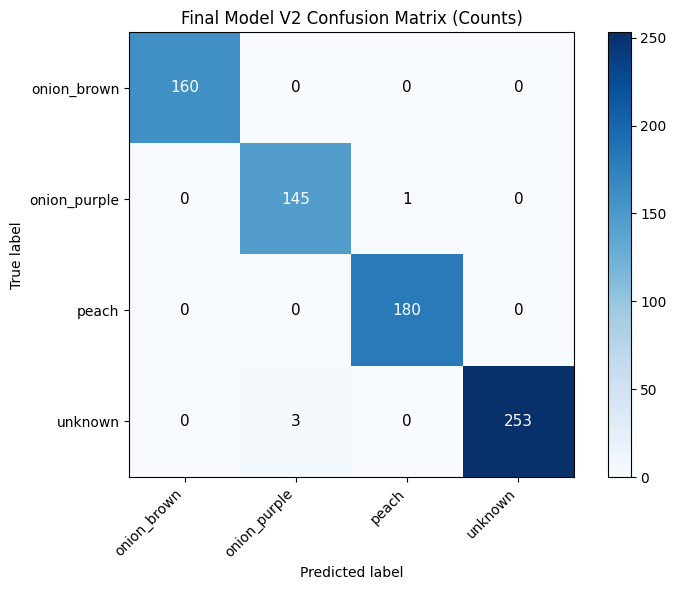

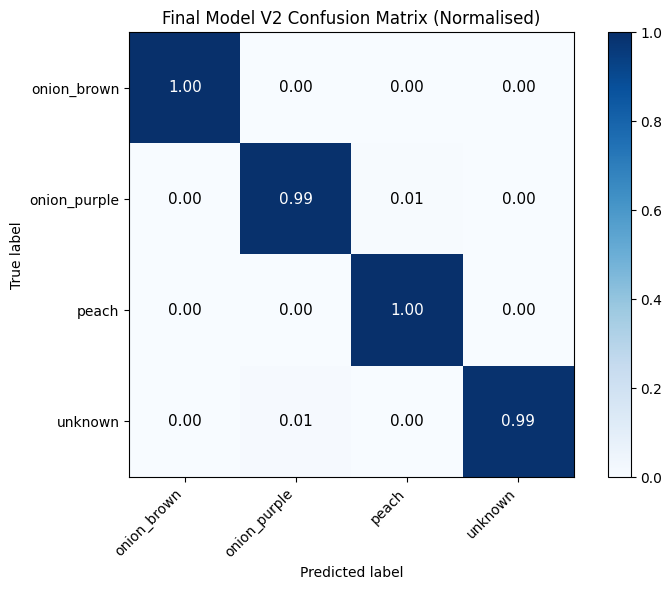

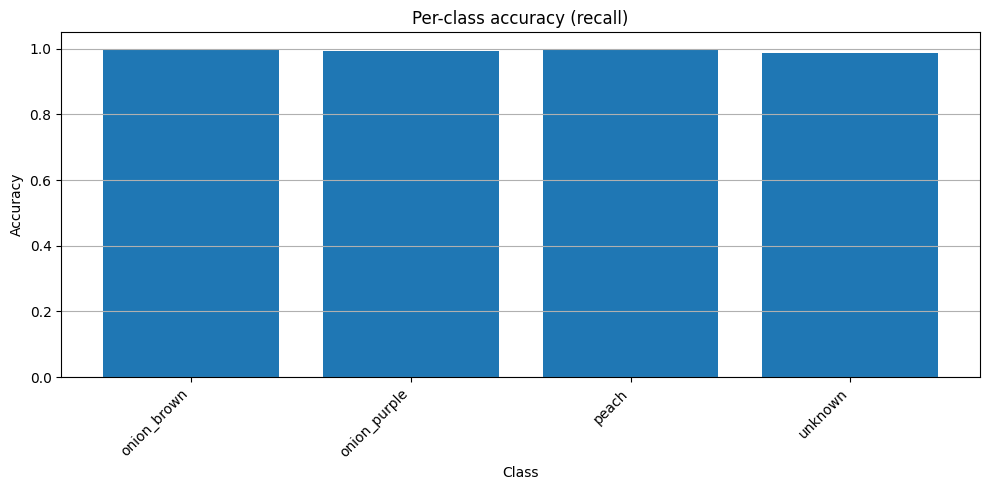

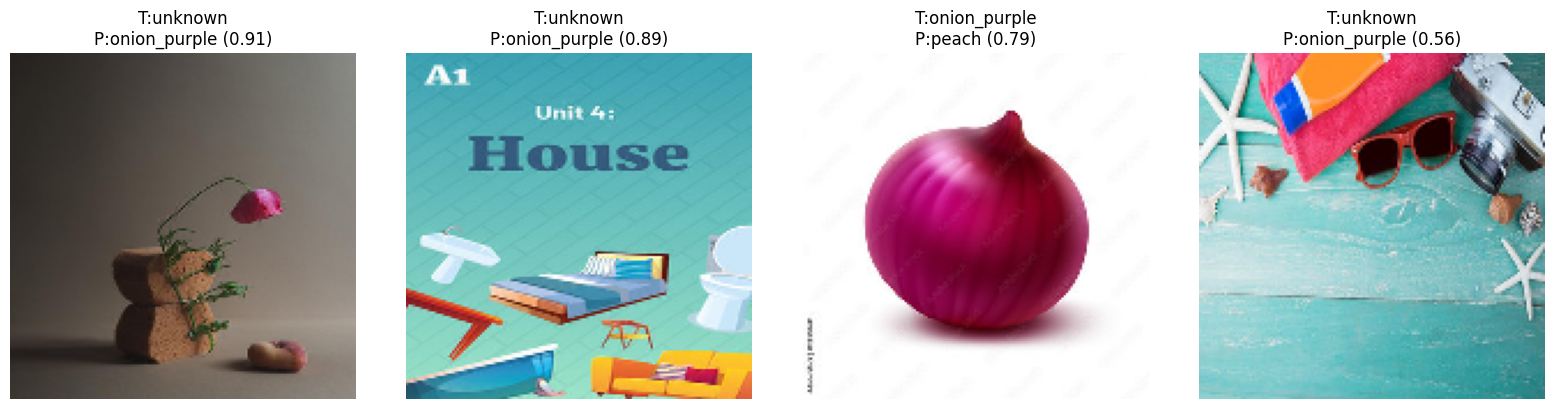

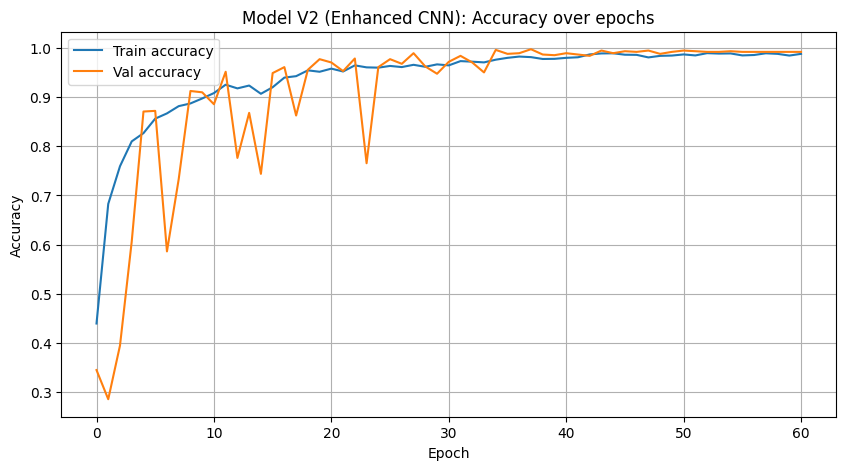

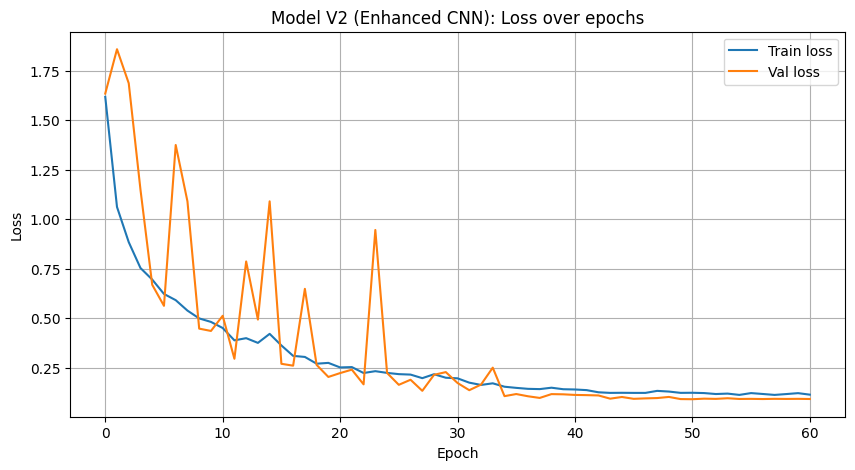

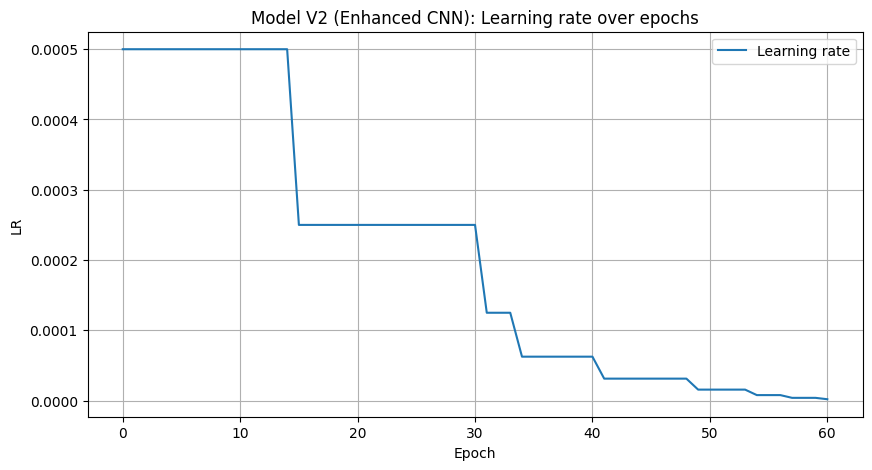

In [11]:
# ==========================================
# EVALUATION + VISUALISATION FOR MODEL V2 (ENHANCED CNN)
# - Confusion matrix (counts + normalised)
# - Classification report
# - Training curves: accuracy, loss, learning rate
# - Per-class accuracy bar chart
# - Top misclassifications (most confident wrong)
# ==========================================


# ---------- helpers ----------

def get_class_names_from_gen(gen):
    if hasattr(gen, "class_indices") and isinstance(gen.class_indices, dict):
        inv = {v: k for k, v in gen.class_indices.items()}
        return [inv[i] for i in range(len(inv))]
    return [f"class_{i}" for i in range(getattr(gen, "num_classes", 0) or 0)]

def collect_preds_and_labels(model, gen, steps=None):
    gen.reset()

    if steps is None:
        steps = int(np.ceil(gen.samples / gen.batch_size))

    y_prob = model.predict(gen, steps=steps, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    if hasattr(gen, "classes"):
        y_true = gen.classes[: len(y_pred)]
    else:
        y_true_list = []
        gen.reset()
        for _ in range(steps):
            _, y = next(gen)
            y_true_list.append(np.argmax(y, axis=1))
        y_true = np.concatenate(y_true_list, axis=0)[: len(y_pred)]

    return y_true, y_pred, y_prob

def plot_training_curves(history, title_prefix="Model V2"):
    h = history.history

    # Accuracy
    plt.figure(figsize=(10, 5))
    if "accuracy" in h: plt.plot(h["accuracy"], label="Train accuracy")
    if "val_accuracy" in h: plt.plot(h["val_accuracy"], label="Val accuracy")
    plt.title(f"{title_prefix}: Accuracy over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Loss
    plt.figure(figsize=(10, 5))
    if "loss" in h: plt.plot(h["loss"], label="Train loss")
    if "val_loss" in h: plt.plot(h["val_loss"], label="Val loss")
    plt.title(f"{title_prefix}: Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Learning rate (if recorded)
    lr_key = None
    for k in ["lr", "learning_rate"]:
        if k in h:
            lr_key = k
            break
    if lr_key is not None:
        plt.figure(figsize=(10, 5))
        plt.plot(h[lr_key], label="Learning rate")
        plt.title(f"{title_prefix}: Learning rate over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("LR")
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", normalise=False):
    cm_plot = cm.astype(np.float64)

    if normalise:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        cm_plot = np.divide(cm_plot, row_sums, out=np.zeros_like(cm_plot), where=row_sums != 0)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm_plot, interpolation="nearest", cmap="Blues")
    plt.grid(False)  # remove any global grid overlays
    plt.title(title + (" (Normalised)" if normalise else " (Counts)"))
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    fmt = ".2f" if normalise else ".0f"
    thresh = cm_plot.max() / 2.0 if cm_plot.size else 0.0

    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = cm_plot[i, j]
            txt = format(val, fmt)
            plt.text(
                j, i, txt,
                ha="center", va="center",
                fontsize=11,
                color="white" if val > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

def per_class_accuracy(cm, class_names):
    row_sum = cm.sum(axis=1)
    diag = np.diag(cm)
    acc = np.divide(diag, row_sum, out=np.zeros_like(diag, dtype=float), where=row_sum != 0)

    plt.figure(figsize=(10, 5))
    plt.bar(class_names, acc)
    plt.title("Per-class accuracy (recall)")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

def show_top_misclassifications(gen, y_true, y_pred, y_prob, class_names, top_k=12):
    if not hasattr(gen, "filepaths"):
        print("Top misclassifications needs gen.filepaths (DirectoryIterator). Skipping.")
        return

    wrong = np.where(y_true != y_pred)[0]
    if wrong.size == 0:
        print("No misclassifications found.")
        return

    conf = y_prob[wrong, y_pred[wrong]]
    order = wrong[np.argsort(-conf)][:top_k]

    cols = 4
    rows = int(np.ceil(len(order) / cols))
    plt.figure(figsize=(4 * cols, 4 * rows))

    for idx, sample_i in enumerate(order, start=1):
        path = gen.filepaths[sample_i]
        img = tf.keras.utils.load_img(path, target_size=gen.target_size)
        plt.subplot(rows, cols, idx)
        plt.imshow(img)
        t = class_names[y_true[sample_i]]
        p = class_names[y_pred[sample_i]]
        c = float(y_prob[sample_i, y_pred[sample_i]])
        plt.title(f"T:{t}\nP:{p} ({c:.2f})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---------- run evaluation ----------
eval_gen = val_gen_base

# ===== Evaluate FINAL model =====
model_final = tf.keras.models.load_model("../models/model_custom_cnn_v2_final.h5")

y_true, y_pred, y_prob = collect_preds_and_labels(
    model_final,
    val_gen_base,
    steps=steps_per_epoch_for(val_gen_base)
)

cm = confusion_matrix(y_true, y_pred)
print("\n=== FINAL MODEL (v2) RESULTS ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
plot_confusion_matrix(cm, class_names, title="Final Model V2 Confusion Matrix", normalise=False)
plot_confusion_matrix(cm, class_names, title="Final Model V2 Confusion Matrix", normalise=True)
per_class_accuracy(cm, class_names)
show_top_misclassifications(eval_gen, y_true, y_pred, y_prob, class_names, top_k=100)

plot_training_curves(history_v2, title_prefix="Model V2 (Enhanced CNN)")





## 8.3. Custom CNN Architecture v3: "Attention & Activation"

### **1. Executive Summary**

The **v3** architecture introduces **Attention Mechanisms** to solve the "Any purple = Purple Onion" false positive error. It acknowledges that not all feature maps are relevant for every image. By dynamically weighting features, the model can suppress "color" signals when "shape" signals are contradictory.

### **2. Architectural Improvements**

#### **A. Squeeze-and-Excitation (SE) Blocks**

* **Change:** Inserted a `squeeze_excite_block` after every convolutional block.
* **Justification:** Standard convolutions treat all channels (features) as equally important. SE blocks explicitly model inter-dependencies between channels. The network learns a set of weights to "excite" (amplify) useful features and "squeeze" (suppress) irrelevant ones. This allows the model to ignore the "Red Color" channel if the "Round Shape" channel is inactive (Hu et al., 2018).

#### **B. Swish Activation Function**

* **Change:** Replaced `ReLU` activation with `Swish` ().
* **Justification:** `ReLU` zeros out all negative values ("dying ReLU"), potentially discarding subtle texture information needed to distinguish onions from complex backgrounds. `Swish` is a smooth, non-monotonic function that allows small negative values to propagate, improving gradient flow and accuracy in deep networks (Ramachandran et al., 2017).

#### **C. Class Weights (Training Strategy)**

* **Change:** Applied `class_weight='balanced'` during training.
* **Justification:** The dataset imbalance caused the model to favor the majority "Unknown" class. Penalizing the model more heavily for misclassifying minority classes (Peach/Onion) shifts the decision boundary, forcing the model to be less conservative (King & Zeng, 2001).


In [12]:


# ==========================================
# CUSTOM CNN v3: SE-Attention & Refined Boundary
# ==========================================
K.clear_session()

def squeeze_excite_block(input_tensor, ratio=16):
    """
    Squeeze and Excitation Block.
    Helps the model weigh which channels (features) are important.
    e.g., 'Is color important right now? or Shape?'
    """
    filters = input_tensor.shape[-1]
    
    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    
    # Excitation: Two dense layers to learn channel weights
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    # Scale input by the learnt weights
    return Multiply()([input_tensor, se])

def build_attention_cnn_v3():
    print("\n--- Building Enhanced Custom CNN v3 (SE-Attention) ---")
    
    inputs = Input(shape=IMG_SIZE_BASE + (3,))
    
    # --- Block 1: Edges & Color (with SE) ---
    x = Conv2D(32, (3, 3), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x) # Swish helps flow gradients better than ReLU
    
    x = Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    x = squeeze_excite_block(x) # ATTENTION: Learn which low-level features matter
    x = MaxPooling2D(2, 2)(x)
    
    # --- Block 2: Textures (with SE) ---
    x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    x = squeeze_excite_block(x) # ATTENTION: Distinguish 'Onion Skin' vs 'Background'
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.2)(x) # Reduced dropout compared to v2

    # --- Block 3: Shapes ---
    x = Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    x = Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.3)(x)

    # --- Block 4: High Level Semantics ---
    x = Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    x = squeeze_excite_block(x) # Critical for separating 'Both' from single classes
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.3)(x)

    # --- Head ---
    x = GlobalAveragePooling2D()(x)
    
    # We removed L2 regularization here to allow higher confidence on specific classes
    x = Dense(256, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(0.4)(x)
    
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ---- Compute Class Weights
# This is CRITICAL. It tells the model: "Pay more attention to Peach/Onion than Unknown"
# We assume train_gen_base.classes exists. If using flow_from_directory, it does.
try:
    # Get labels from generator
    y_train_labels = train_gen_base.classes
    class_weights_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_labels),
        y=y_train_labels
    )
    # Convert to dict for Keras
    class_weights_dict = dict(enumerate(class_weights_array))
    
    
    print(f"Computed Class Weights: {class_weights_dict}")
except Exception as e:
    print("Could not compute class weights automatically (generator might be shuffled). Using default balanced.")
    class_weights_dict = None

# ---- Build
model_v3 = build_attention_cnn_v3()

# ---- Callbacks
os.makedirs("../models", exist_ok=True)
v3_callbacks = [
    ModelCheckpoint(
        "../models/model_custom_cnn_v3_best.h5",
        monitor="val_loss",
            mode="min",
        save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
            mode="min",
        factor=0.5, patience=4, min_lr=1e-6, verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
            mode="min",
        patience=10, restore_best_weights=True, verbose=1
    ),
]


# ---- Train
print("Starting training for v3 (SE-Attention)...")
start_time = time.time()

history_v3 = model_v3.fit(
    train_gen_base,
    validation_data=val_gen_base,
    steps_per_epoch=steps_per_epoch_for(train_gen_base),
    validation_steps=steps_per_epoch_for(val_gen_base),
    epochs=100,
    callbacks=v3_callbacks,
    class_weight=class_weights_dict, # <--- Apply weights here
    verbose=1
)

duration_v3 = time.time() - start_time
best_model_v3 = tf.keras.models.load_model("../models/model_custom_cnn_v3_best.h5")
best_model_v3.save("../models/model_custom_cnn_v3_final.h5")

print(f"Model v3 saved. Training time: {duration_v3:.2f}s")

Computed Class Weights: {0: 1.1555407209612818, 1: 1.2727941176470587, 2: 1.0303571428571427, 3: 0.7254819782062029}

--- Building Enhanced Custom CNN v3 (SE-Attention) ---
Starting training for v3 (SE-Attention)...
Epoch 1/100
109/109 [==============================] - ETA: 0s - loss: 0.8269 - accuracy: 0.6407
Epoch 1: val_loss improved from inf to 1.39658, saving model to ../models\model_custom_cnn_v3_best.h5
109/109 [==============================] - 21s 165ms/step - loss: 0.8269 - accuracy: 0.6407 - val_loss: 1.3966 - val_accuracy: 0.2156 - lr: 5.0000e-04
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4318 - accuracy: 0.8374
Epoch 2: val_loss did not improve from 1.39658
109/109 [==============================] - 17s 157ms/step - loss: 0.4318 - accuracy: 0.8374 - val_loss: 1.6343 - val_accuracy: 0.3423 - lr: 5.0000e-04
Epoch 3/100
109/109 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.8876
Epoch 3: val_loss did not improve from 1.3

24/24 [==============================] - 1s 34ms/step

=== FINAL MODEL (v3) RESULTS ===
              precision    recall  f1-score   support

 onion_brown     1.0000    1.0000    1.0000       160
onion_purple     1.0000    1.0000    1.0000       146
       peach     1.0000    0.9944    0.9972       180
     unknown     0.9961    1.0000    0.9981       256

    accuracy                         0.9987       742
   macro avg     0.9990    0.9986    0.9988       742
weighted avg     0.9987    0.9987    0.9987       742



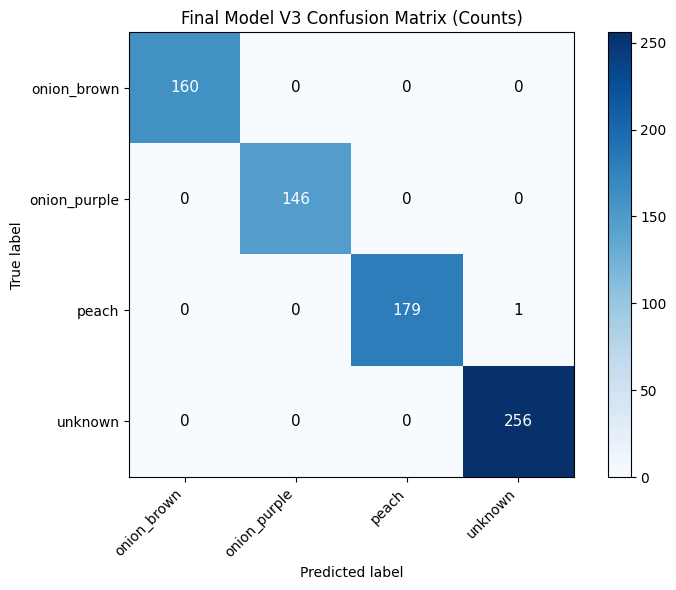

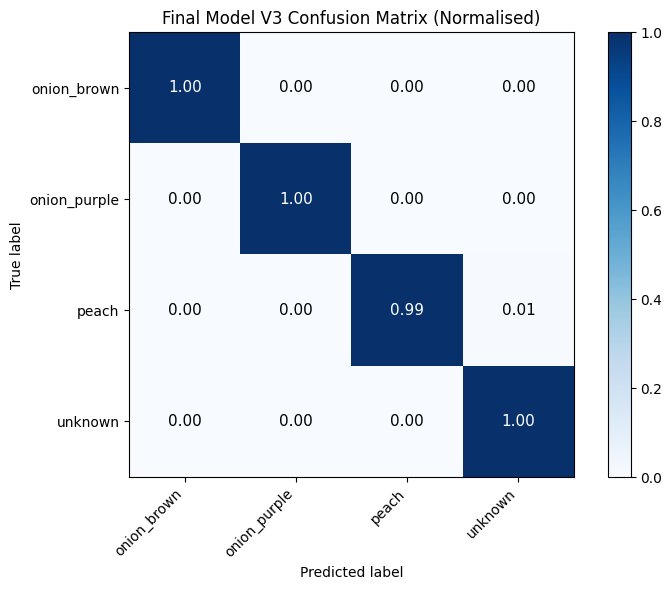

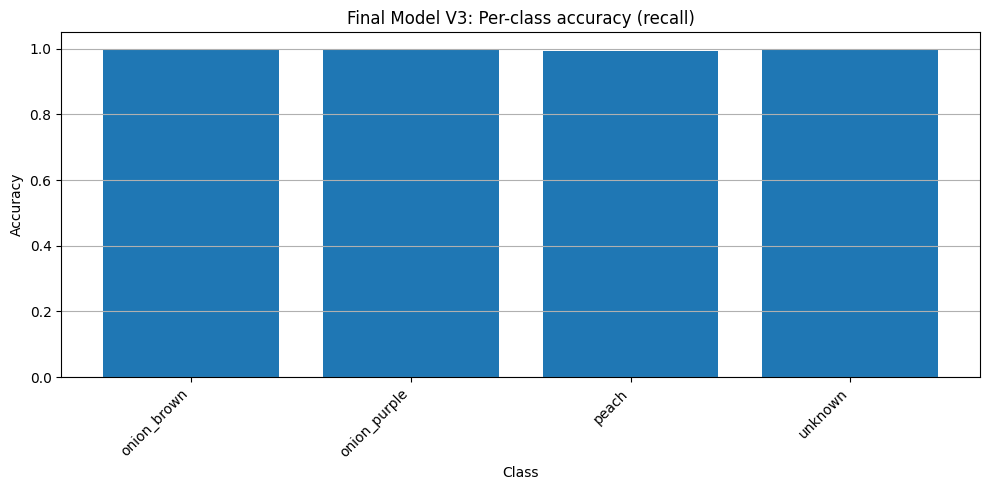

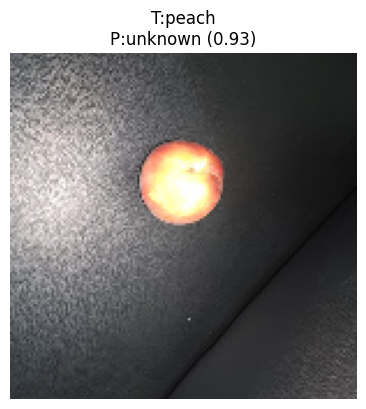

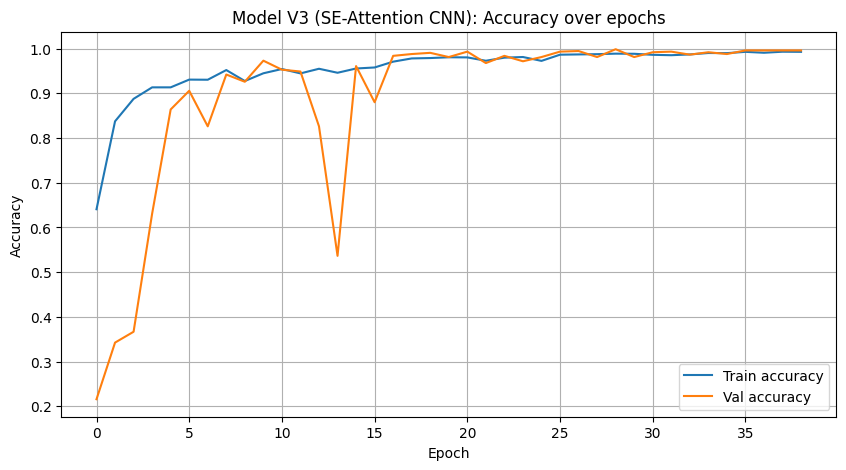

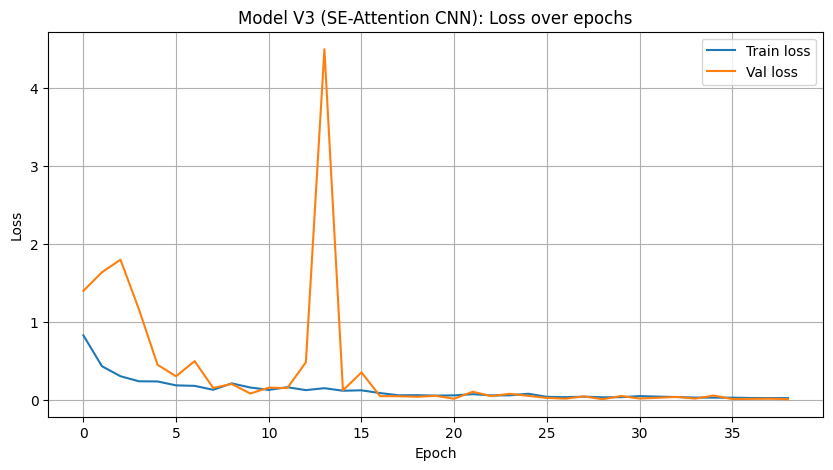

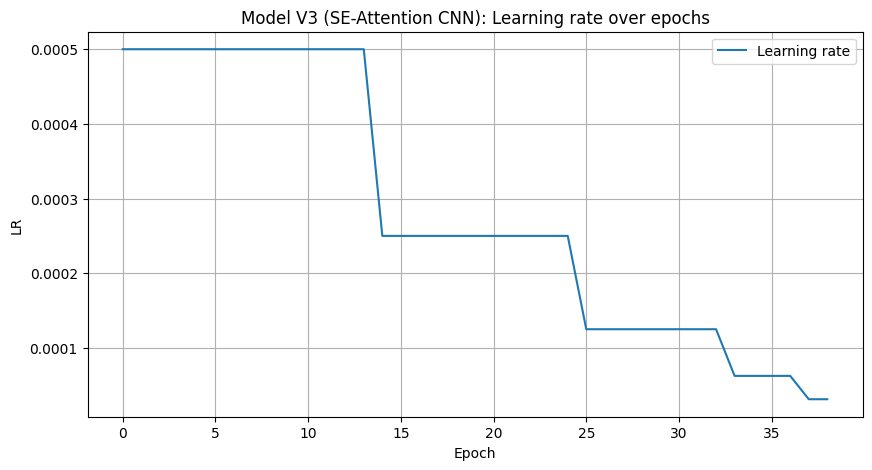

In [13]:
# ==========================================
# EVALUATION + VISUALISATION FOR MODEL V3 (SE-ATTENTION CNN)
# - Confusion matrix (counts + normalised)
# - Classification report
# - Per-class accuracy bar chart
# - Top misclassifications (most confident wrong)
# - Training curves: accuracy, loss, learning rate
# ==========================================


# ---------- helpers ----------

def get_class_names_from_gen(gen):
    if hasattr(gen, "class_indices") and isinstance(gen.class_indices, dict):
        inv = {v: k for k, v in gen.class_indices.items()}
        return [inv[i] for i in range(len(inv))]
    return [f"class_{i}" for i in range(getattr(gen, "num_classes", 0) or 0)]

def collect_preds_and_labels(model, gen, steps=None):
    gen.reset()

    if steps is None:
        steps = int(np.ceil(gen.samples / gen.batch_size))

    y_prob = model.predict(gen, steps=steps, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    if hasattr(gen, "classes"):
        y_true = gen.classes[: len(y_pred)]
    else:
        y_true_list = []
        gen.reset()
        for _ in range(steps):
            _, y = next(gen)
            y_true_list.append(np.argmax(y, axis=1))
        y_true = np.concatenate(y_true_list, axis=0)[: len(y_pred)]

    return y_true, y_pred, y_prob

def plot_training_curves(history, title_prefix="Model V3"):
    h = history.history

    # Accuracy
    plt.figure(figsize=(10, 5))
    if "accuracy" in h: plt.plot(h["accuracy"], label="Train accuracy")
    if "val_accuracy" in h: plt.plot(h["val_accuracy"], label="Val accuracy")
    plt.title(f"{title_prefix}: Accuracy over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Loss
    plt.figure(figsize=(10, 5))
    if "loss" in h: plt.plot(h["loss"], label="Train loss")
    if "val_loss" in h: plt.plot(h["val_loss"], label="Val loss")
    plt.title(f"{title_prefix}: Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()


    lr_key = None
    for k in ["lr", "learning_rate"]:
        if k in h:
            lr_key = k
            break
    if lr_key is not None:
        plt.figure(figsize=(10, 5))
        plt.plot(h[lr_key], label="Learning rate")
        plt.title(f"{title_prefix}: Learning rate over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("LR")
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", normalise=False):
    cm_plot = cm.astype(np.float64)

    if normalise:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        cm_plot = np.divide(cm_plot, row_sums, out=np.zeros_like(cm_plot), where=row_sums != 0)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm_plot, interpolation="nearest", cmap="Blues")
    plt.grid(False)
    plt.title(title + (" (Normalised)" if normalise else " (Counts)"))
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    fmt = ".2f" if normalise else ".0f"
    thresh = cm_plot.max() / 2.0 if cm_plot.size else 0.0

    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = cm_plot[i, j]
            plt.text(
                j, i, format(val, fmt),
                ha="center", va="center",
                fontsize=11,
                color="white" if val > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

def per_class_accuracy(cm, class_names, title="Per-class accuracy (recall)"):
    row_sum = cm.sum(axis=1)
    diag = np.diag(cm)
    acc = np.divide(diag, row_sum, out=np.zeros_like(diag, dtype=float), where=row_sum != 0)

    plt.figure(figsize=(10, 5))
    plt.bar(class_names, acc)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

def show_top_misclassifications(gen, y_true, y_pred, y_prob, class_names, top_k=100):
    if not hasattr(gen, "filepaths"):
        print("Top misclassifications needs gen.filepaths (DirectoryIterator). Skipping.")
        return

    wrong = np.where(y_true != y_pred)[0]
    if wrong.size == 0:
        print("No misclassifications found.")
        return

    conf = y_prob[wrong, y_pred[wrong]]
    order = wrong[np.argsort(-conf)][:top_k]

    cols = 4
    rows = int(np.ceil(len(order) / cols))
    plt.figure(figsize=(4 * cols, 4 * rows))

    for idx, sample_i in enumerate(order, start=1):
        path = gen.filepaths[sample_i]
        img = tf.keras.utils.load_img(path, target_size=gen.target_size)
        plt.subplot(rows, cols, idx)
        plt.imshow(img)
        t = class_names[y_true[sample_i]]
        p = class_names[y_pred[sample_i]]
        c = float(y_prob[sample_i, y_pred[sample_i]])
        plt.title(f"T:{t}\nP:{p} ({c:.2f})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---------- run evaluation ----------
eval_gen = val_gen_base
class_names = get_class_names_from_gen(eval_gen)

# ===== Evaluate FINAL model =====
model_final = tf.keras.models.load_model("../models/model_custom_cnn_v3_final.h5")

y_true, y_pred, y_prob = collect_preds_and_labels(
    model_final,
    eval_gen,
    steps=steps_per_epoch_for(eval_gen)
)

cm = confusion_matrix(y_true, y_pred)
print("\n=== FINAL MODEL (v3) RESULTS ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
plot_confusion_matrix(cm, class_names, title="Final Model V3 Confusion Matrix", normalise=False)
plot_confusion_matrix(cm, class_names, title="Final Model V3 Confusion Matrix", normalise=True)
per_class_accuracy(cm, class_names, title="Final Model V3: Per-class accuracy (recall)")
show_top_misclassifications(eval_gen, y_true, y_pred, y_prob, class_names, top_k=100)


plot_training_curves(history_v3, title_prefix="Model V3 (SE-Attention CNN)")


## 8.4. Custom CNN Architecture v4: "Hard Mining & Robustness"

### **1. Executive Summary**

The **v4** architecture is the most advanced iteration, designed to solve the persistent "Hard Negative" problem (e.g., the Peach being classified as Unknown). It moves away from standard loss functions that treat all errors equally, instead adopting a **Focal Loss** strategy that focuses training energy specifically on difficult examples.

### **2. Architectural Improvements**

#### **A. Focal Loss**

* **Change:** Replaced `Categorical Crossentropy` with `Categorical Focal Loss`.
* **Justification:** In standard Cross Entropy, many easy negatives (clear backgrounds) dominate the gradient, drowning out the signal from hard positives (subtle onions). Focal Loss adds a modulating factor  that down-weights easy examples and up-weights hard, misclassified examples. This forces the model to learn the difficult distinctions (Lin et al., 2017).

#### **B. Spatial Dropout**

* **Change:** Replaced standard `Dropout` with `SpatialDropout2D`.
* **Justification:** Standard dropout removes random pixels, but because images are spatially correlated, adjacent pixels can still leak information (e.g., neighboring red pixels can still signal "red"). `SpatialDropout2D` drops **entire feature maps** (whole color channels). This forces the model to correctly classify an object even if its strongest feature (e.g., color) is completely absent, promoting robust shape dependency (Tompson et al., 2015).

#### **C. Deep Feature Integration**

* **Change:** Retained the SE-Blocks and Swish activations from v3 but integrated them with the new loss function.
* **Justification:** The combination of Attention (v3) and Hard Mining (v4) creates a synergy: Attention highlights *what* to look at, and Focal Loss forces the model to look *harder* at the confusing cases.

In [14]:


# ==========================================
# CUSTOM LOSS: FOCAL LOSS
# Citation: Lin et al., "Focal Loss for Dense Object Detection" (2017)

K.clear_session()

# ==========================================
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Softmax version of focal loss.
    gamma: Focusing parameter. Higher values (e.g., 2.0) force the model to 
           focus more on hard/misclassified examples (Onions).
    alpha: Balance factor to weigh positive vs negative classes.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip probabilities to prevent log(0) error
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Term: (1 - p_t)^gamma
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)

        # Combine
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# ==========================================
# COMPONENT: SE BLOCK (Retained from v3)
# Citation: Hu et al., "Squeeze-and-Excitation Networks" (2018)
# ==========================================
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return Multiply()([input_tensor, se])

# ==========================================
# ARCHITECTURE v4
# ==========================================
def build_focal_cnn_v4():
    print("\n--- Building Enhanced Custom CNN v4 (Focal Loss + Spatial Dropout) ---")
    
    inputs = Input(shape=IMG_SIZE_BASE + (3,))
    
    # --- Block 1: Edges & Color ---
    x = Conv2D(32, (3, 3), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    x = Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    # IMPROVEMENT: Spatial Dropout
    # Drops entire 2D feature maps, not just pixels. 
    # Forces model to not rely on a specific color channel (Red).
    x = SpatialDropout2D(0.1)(x) 
    x = MaxPooling2D(2, 2)(x)
    
    # --- Block 2: Textures (Onion Skin) ---
    x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    x = squeeze_excite_block(x) 
    x = MaxPooling2D(2, 2)(x)
    x = SpatialDropout2D(0.15)(x) 

    # --- Block 3: Shapes ---
    x = Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    x = Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = SpatialDropout2D(0.2)(x)

    # --- Block 4: Semantics ---
    x = Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = SpatialDropout2D(0.2)(x)

    # --- Head ---
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(256, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(0.4)(x) # Standard dropout here for dense layers
    
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    # IMPROVEMENT: Compile with Focal Loss
    # We remove explicit class_weights in .fit() because Focal Loss handles balancing internally/dynamically
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss=categorical_focal_loss(gamma=2.0, alpha=0.25), 
        metrics=['accuracy']
    )
    return model

# ---- Build
model_v4 = build_focal_cnn_v4()

# ---- Callbacks
os.makedirs("../models", exist_ok=True)
v4_callbacks = [
    ModelCheckpoint(
        "../models/model_custom_cnn_v4_best.h5",
        monitor="val_loss",
            mode="min",
        save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
            mode="min",
        factor=0.5, patience=4, min_lr=1e-6, verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
            mode="min",
        patience=12, restore_best_weights=True, verbose=1
    ),
]


# ---- Train
print("Starting training for v4 (Focal Loss)...")
start_time = time.time()

# Note: We do NOT pass class_weight here, as Focal Loss handles the hard mining
history_v4 = model_v4.fit(
    train_gen_base,
    validation_data=val_gen_base,
    steps_per_epoch=steps_per_epoch_for(train_gen_base),
    validation_steps=steps_per_epoch_for(val_gen_base),
    epochs=100,
    callbacks=v4_callbacks,
    verbose=1
)

duration_v4 = time.time() - start_time
best_model_v4 = tf.keras.models.load_model(
    "../models/model_custom_cnn_v4_best.h5",
    custom_objects={"focal_loss_fixed": categorical_focal_loss(gamma=2.0, alpha=0.25)}
)
best_model_v4.save("../models/model_custom_cnn_v4_final.h5")

print(f"Model v4 saved. Training time: {duration_v4:.2f}s")


--- Building Enhanced Custom CNN v4 (Focal Loss + Spatial Dropout) ---
Starting training for v4 (Focal Loss)...
Epoch 1/100
109/109 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.3925
Epoch 1: val_loss improved from inf to 0.19332, saving model to ../models\model_custom_cnn_v4_best.h5
109/109 [==============================] - 20s 159ms/step - loss: 0.2142 - accuracy: 0.3925 - val_loss: 0.1933 - val_accuracy: 0.3450 - lr: 5.0000e-04
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.5826
Epoch 2: val_loss did not improve from 0.19332
109/109 [==============================] - 17s 156ms/step - loss: 0.1257 - accuracy: 0.5826 - val_loss: 0.2077 - val_accuracy: 0.3450 - lr: 5.0000e-04
Epoch 3/100
109/109 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.6742
Epoch 3: val_loss did not improve from 0.19332
109/109 [==============================] - 18s 163ms/step - loss: 0.0977 - accuracy: 0.6742 - val_

24/24 [==============================] - 1s 31ms/step

=== FINAL MODEL (v4) RESULTS ===
              precision    recall  f1-score   support

 onion_brown     0.9573    0.9812    0.9691       160
onion_purple     0.9865    1.0000    0.9932       146
       peach     1.0000    0.9833    0.9916       180
     unknown     0.9842    0.9727    0.9784       256

    accuracy                         0.9825       742
   macro avg     0.9820    0.9843    0.9831       742
weighted avg     0.9827    0.9825    0.9825       742



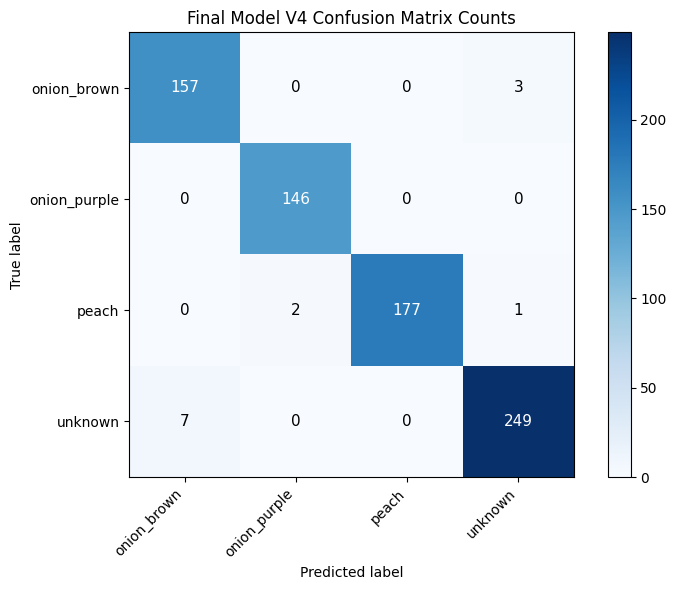

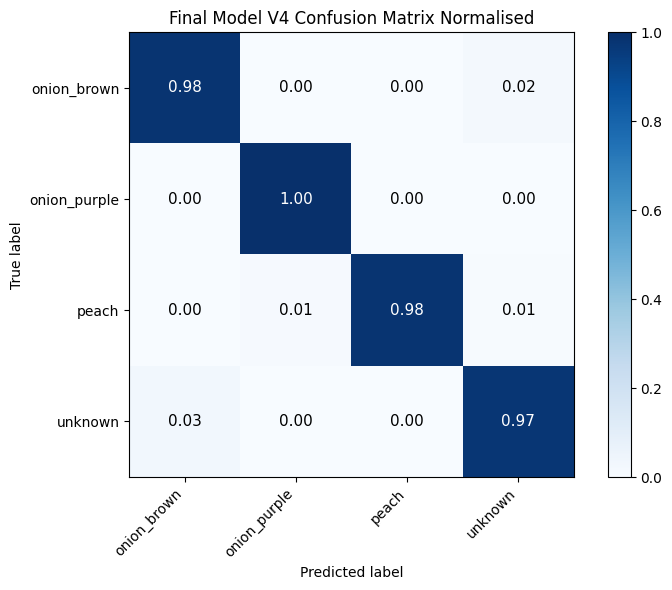

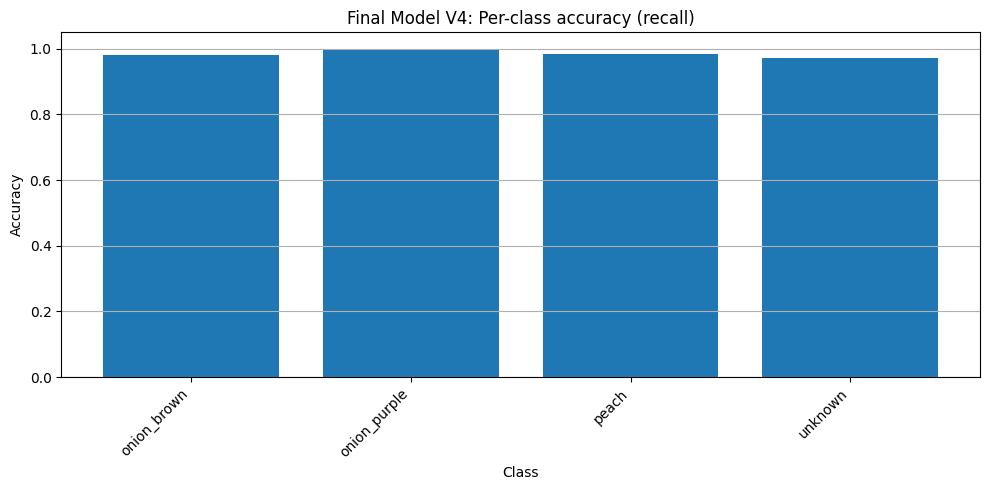

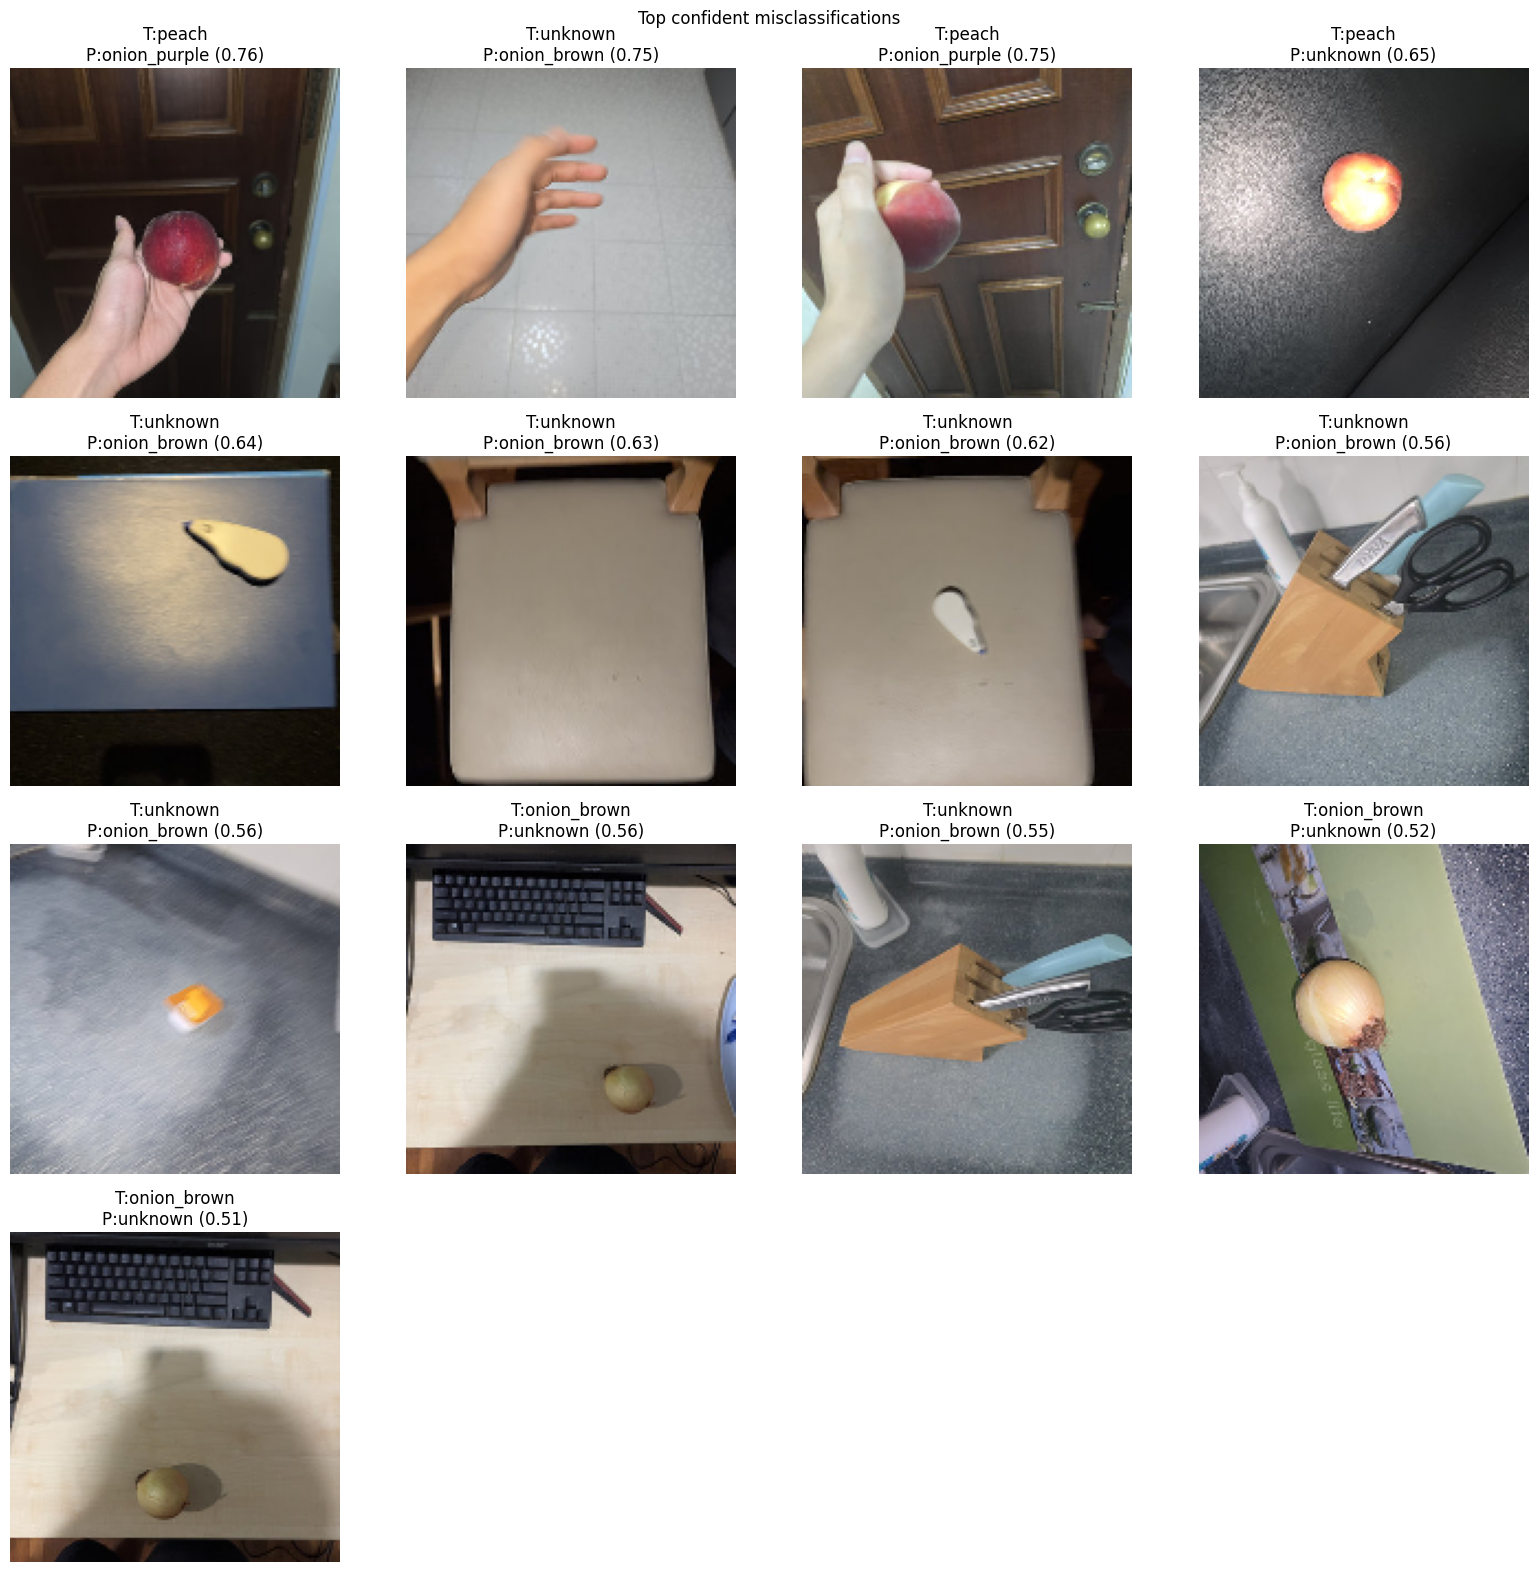

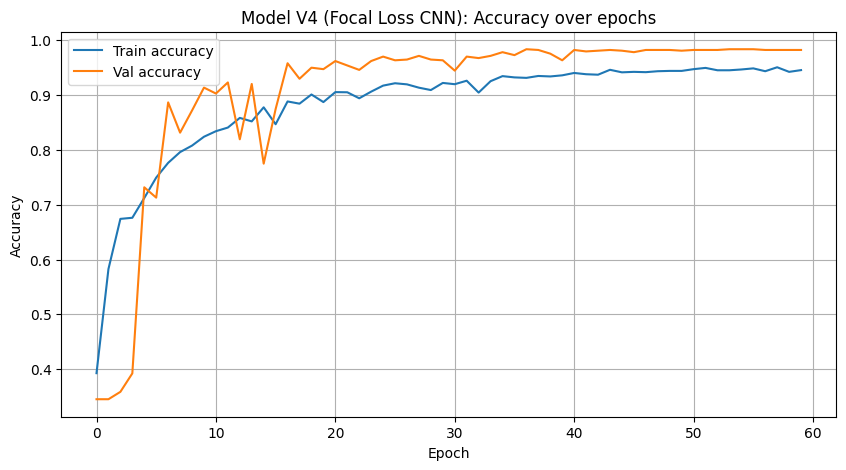

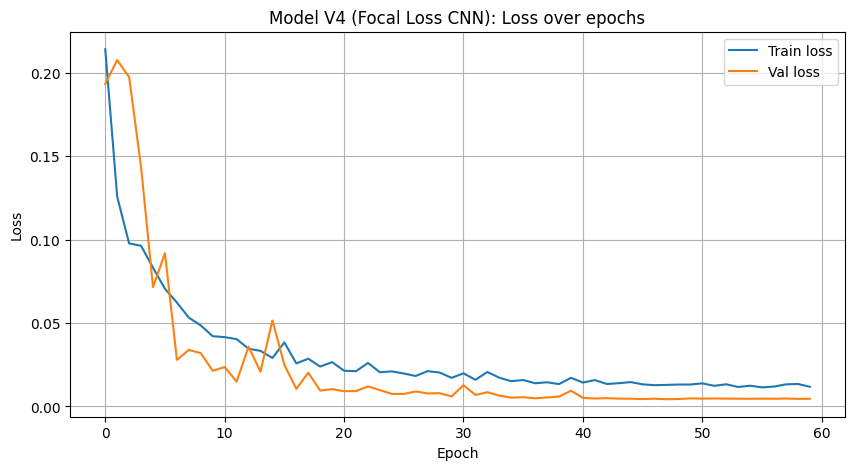

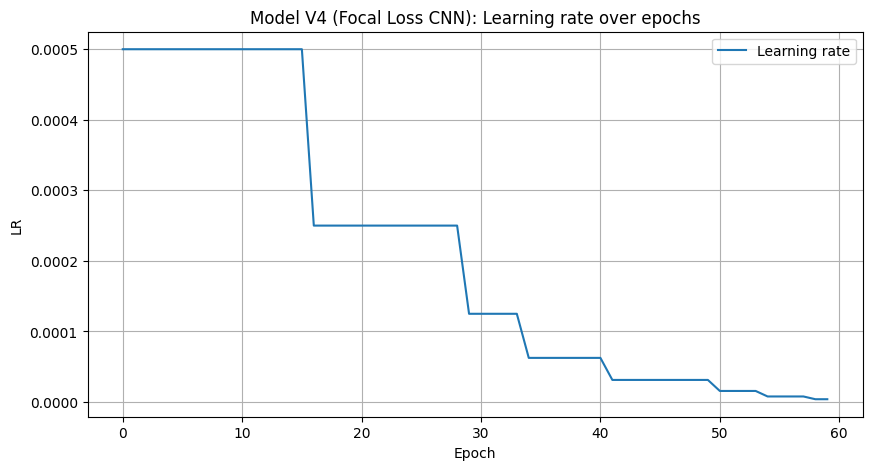

In [17]:
# ==========================================
# EVALUATION + VISUALISATION FOR MODEL V4 (FOCAL LOSS CNN)
# ==========================================



# ---------- helpers (same logic as our previous evals) ----------

def get_class_names_from_gen(gen):
    if hasattr(gen, "class_indices") and isinstance(gen.class_indices, dict):
        inv = {v: k for k, v in gen.class_indices.items()}
        return [inv[i] for i in range(len(inv))]
    return [f"class_{i}" for i in range(getattr(gen, "num_classes", 0) or 0)]

def collect_preds_and_labels(model, gen, steps=None):
    gen.reset()
    if steps is None:
        steps = int(np.ceil(gen.samples / gen.batch_size))

    y_prob = model.predict(gen, steps=steps, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    if hasattr(gen, "classes"):
        y_true = gen.classes[: len(y_pred)]
    else:
        y_true_list = []
        gen.reset()
        for _ in range(steps):
            _, y = next(gen)
            y_true_list.append(np.argmax(y, axis=1))
        y_true = np.concatenate(y_true_list, axis=0)[: len(y_pred)]

    return y_true, y_pred, y_prob

def plot_training_curves(history, title_prefix="Model V4"):
    h = history.history
    plt.figure(figsize=(10, 5))
    if "accuracy" in h: plt.plot(h["accuracy"], label="Train accuracy")
    if "val_accuracy" in h: plt.plot(h["val_accuracy"], label="Val accuracy")
    plt.title(f"{title_prefix}: Accuracy over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    if "loss" in h: plt.plot(h["loss"], label="Train loss")
    if "val_loss" in h: plt.plot(h["val_loss"], label="Val loss")
    plt.title(f"{title_prefix}: Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    # LR if logged
    lr_key = next((k for k in ["lr", "learning_rate"] if k in h), None)
    if lr_key:
        plt.figure(figsize=(10, 5))
        plt.plot(h[lr_key], label="Learning rate")
        plt.title(f"{title_prefix}: Learning rate over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("LR")
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", normalise=False):
    cm_plot = cm.astype(np.float64)
    if normalise:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        cm_plot = np.divide(cm_plot, row_sums, out=np.zeros_like(cm_plot), where=row_sums != 0)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm_plot, interpolation="nearest", cmap="Blues")
    plt.grid(False)
    plt.title(title + (" Normalised" if normalise else " Counts"))
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)

    fmt = ".2f" if normalise else ".0f"
    thresh = cm_plot.max() / 2.0 if cm_plot.size else 0.0
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = cm_plot[i, j]
            plt.text(j, i, format(val, fmt),
                     ha="center", va="center",
                     fontsize=11,
                     color="white" if val > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

def per_class_accuracy(cm, class_names, title="Per-class accuracy (recall)"):
    row_sum = cm.sum(axis=1)
    diag = np.diag(cm)
    acc = np.divide(diag, row_sum, out=np.zeros_like(diag, dtype=float), where=row_sum != 0)
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, acc)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

def show_top_misclassifications(gen, y_true, y_pred, y_prob, class_names, top_k=100):
    if not hasattr(gen, "filepaths"):
        print("Misclassification preview skipped, no filepaths in generator.")
        return
    wrong = np.where(y_true != y_pred)[0]
    if wrong.size == 0:
        print("No misclassifications found.")
        return
    conf = y_prob[wrong, y_pred[wrong]]
    order = wrong[np.argsort(-conf)][:top_k]
    cols = 4
    rows = int(np.ceil(len(order) / cols))
    plt.figure(figsize=(4 * cols, 4 * rows))
    plt.suptitle("Top confident misclassifications")
    for idx, i in enumerate(order, start=1):
        path = gen.filepaths[i]
        img = tf.keras.utils.load_img(path, target_size=gen.target_size)
        plt.subplot(rows, cols, idx)
        plt.imshow(img)
        t = class_names[y_true[i]]
        p = class_names[y_pred[i]]
        c = float(y_prob[i, y_pred[i]])
        plt.title(f"T:{t}\nP:{p} ({c:.2f})")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# ---------- run evaluation on both saved models ----------

eval_gen = val_gen_base  # swap to test_gen_base if created
class_names = get_class_names_from_gen(eval_gen)

# ===== FINAL model v4 =====
model_final = tf.keras.models.load_model(
    "../models/model_custom_cnn_v4_final.h5",
    custom_objects={"focal_loss_fixed": categorical_focal_loss(gamma=2.0, alpha=0.25)}
)

y_true, y_pred, y_prob = collect_preds_and_labels(model_final, eval_gen)
cm = confusion_matrix(y_true, y_pred)
print("\n=== FINAL MODEL (v4) RESULTS ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
plot_confusion_matrix(cm, class_names, title="Final Model V4 Confusion Matrix", normalise=False)
plot_confusion_matrix(cm, class_names, title="Final Model V4 Confusion Matrix", normalise=True)
per_class_accuracy(cm, class_names, title="Final Model V4: Per-class accuracy (recall)")
show_top_misclassifications(eval_gen, y_true, y_pred, y_prob, class_names, top_k=100)

# ===== Training curves from the training run =====
plot_training_curves(history_v4, title_prefix="Model V4 (Focal Loss CNN)")


## 9. Model Comparison Visualisation

To identify the most suitable CNN architecture for classifying **Peach**, **Brown Onion**, **Purple Onion**, and **Unknown**, all final models were evaluated on the **same validation dataset**. This ensures a fair comparison prior to hyperparameter tuning. The visualisations below assess both predictive performance and computational efficiency.

### 1. Training vs Validation Accuracy (Line Plot per Version)

These plots track model performance across epochs, showing how well each architecture learns from training data and generalises to unseen validation samples.

* **Training accuracy** reflects how effectively the model fits known data.
* **Validation accuracy** measures generalisation capability and robustness.

This comparison is particularly important for visually similar classes such as **Brown Onion** and **Purple Onion**, which require the model to learn subtle colour and texture cues. Plotting each version separately prevents misleading interpretation caused by overlapping curves.

### 2. Training vs Validation Loss (Line Plot per Version)

Loss curves indicate prediction confidence and classification error across epochs.

Lower validation loss suggests improved decision boundaries, which is critical for separating classes with overlapping visual features such as **Brown Onion** and **Purple Onion**. These plots also reveal training instability or overfitting, and help verify whether architectural changes such as focal loss in later versions improve convergence behaviour.

### 3. Learning Rate Schedule (Line Plot)

For models that log learning rate updates, learning rate curves confirm optimisation behaviour over time.

This helps verify that learning rate reduction occurs as intended, preventing overshooting or premature convergence, and supports reproducibility when extending or repeating training runs.

### 4. Balanced Accuracy (Bar Chart)

Balanced accuracy computes the mean recall across all classes, giving equal importance to each category.

Because the **Unknown** class often dominates in quantity, raw accuracy can be misleading. Balanced accuracy provides a fairer measure of performance on visually challenging classes such as **Peach**, **Brown Onion**, and **Purple Onion**, making it a more reliable comparison metric.

### 5. Macro F1 Score (Bar Chart)

Macro F1 averages the F1 score across all classes, weighting each class equally.

This metric highlights whether a model performs consistently across categories or struggles with specific classes. It is especially informative for evaluating separation quality between **Brown Onion** and **Purple Onion**, where misclassification is more likely due to shared shape and structure.

### 6. Cohen’s Kappa (Tabulated Metric)

Cohen’s kappa measures agreement between predicted and true labels while correcting for chance agreement.

High kappa values indicate meaningful learning rather than random guessing, making this metric useful for validating early architectures such as the V1 baseline.

### 7. Model Size and Inference Speed (Bar Charts)

* **Parameter count** reflects architectural complexity and memory footprint.
* **Inference time per image (ms/img)** measures runtime efficiency.

These metrics are compared alongside accuracy because a marginally more accurate model may be unsuitable if inference cost is significantly higher, especially under deployment or assessment constraints.

---

### Final Model Selection Criteria

The selected architecture for hyperparameter tuning should demonstrate:

1. Clear improvement over the baseline model (V1),
2. Strong balanced accuracy and macro F1 performance,
3. Stable convergence without validation divergence,
4. Efficient inference time per image,
5. High Cohen’s kappa indicating non-random learning,
6. Robust discrimination between visually similar classes, particularly **Red Peach** and **Purple Onion**.

---



=== FINAL MODELS ONLY (sorted by Balanced Acc, then Macro F1) ===



Model  Evaluated On    Params  Accuracy  Balanced Acc  \
2           V3 FINAL  val_gen_base    662756  0.998652      0.998611   
1           V2 FINAL  val_gen_base    652836  0.994609      0.995358   
0  V1 Baseline FINAL  val_gen_base  19035716  0.989218      0.990191   
3           V4 FINAL  val_gen_base    662628  0.982480      0.984310   

   F1 Macro  F1 Weighted     Kappa  Pred Time (s)    ms/img  Train Time (s)  \
2  0.998816     0.998652  0.998171       1.139938  1.536305      687.952584   
1  0.994433     0.994617  0.992690       0.932060  1.256146     1056.293972   
0  0.989349     0.989224  0.985379       0.861605  1.161193      674.869678   
3  0.983080     0.982511  0.976247       1.095498  1.476412     1014.580374   

   Best Epoch (history)  Hist Best Val Acc  Hist Final Val Acc  
2                    29           0.998652            0.995957  
1                    38           0.997305            0.991914  
0                    32           0.990566            0.986523  
3                    37           0.983827            0.982480


=== PER-CLASS METRICS (FINAL models only) ===



Model         Class  Precision    Recall        F1  Support
0   V1 Baseline FINAL   onion_brown   0.993711  0.987500  0.990596      160
1   V1 Baseline FINAL  onion_purple   0.986486  1.000000  0.993197      146
2   V1 Baseline FINAL         peach   0.978022  0.988889  0.983425      180
3   V1 Baseline FINAL       unknown   0.996047  0.984375  0.990177      256
4            V2 FINAL   onion_brown   1.000000  1.000000  1.000000      160
5            V2 FINAL  onion_purple   0.979730  0.993151  0.986395      146
6            V2 FINAL         peach   0.994475  1.000000  0.997230      180
7            V2 FINAL       unknown   1.000000  0.988281  0.994106      256
8            V3 FINAL   onion_brown   1.000000  1.000000  1.000000      160
9            V3 FINAL  onion_purple   1.000000  1.000000  1.000000      146
10           V3 FINAL         peach   1.000000  0.994444  0.997214      180
11           V3 FINAL       unknown   0.996109  1.000000  0.998051      256
12           V4 FINAL   onion_brown   0.957317  0.981250  0.969136      160
13           V4 FINAL  onion_purple   0.986486  1.000000  0.993197      146
14           V4 FINAL         peach   1.000000  0.983333  0.991597      180
15           V4 FINAL       unknown   0.984190  0.972656  0.978389      256

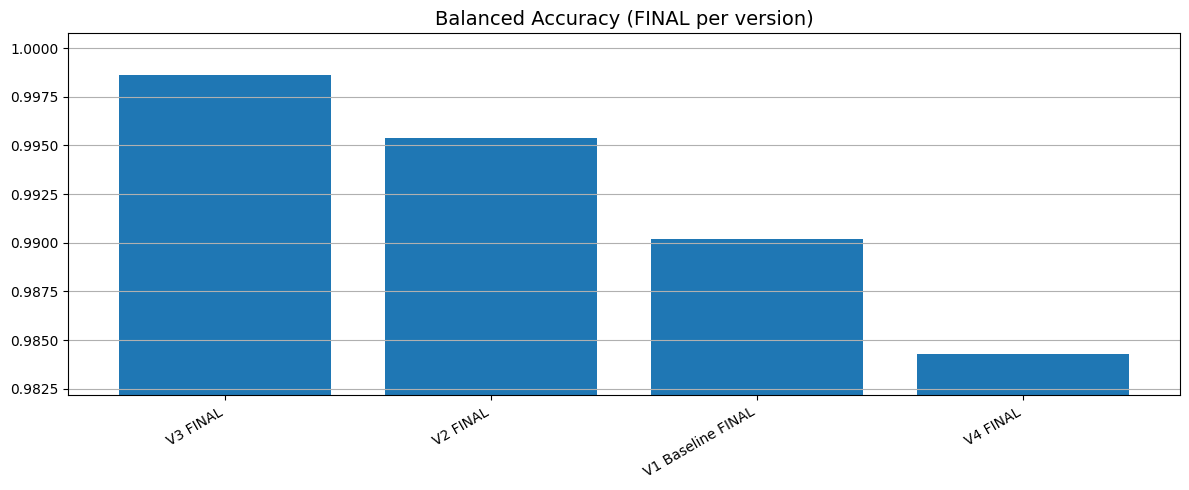

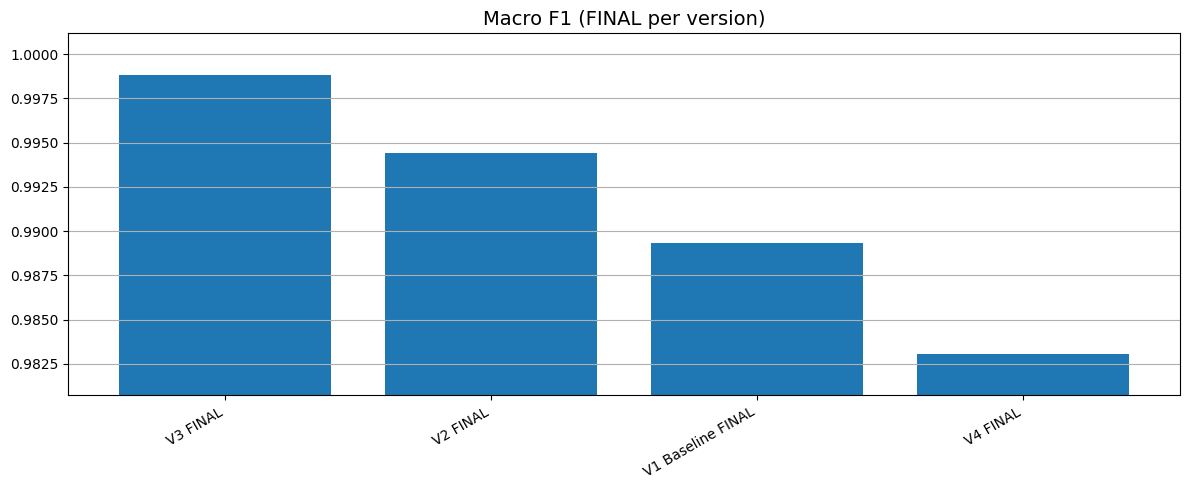

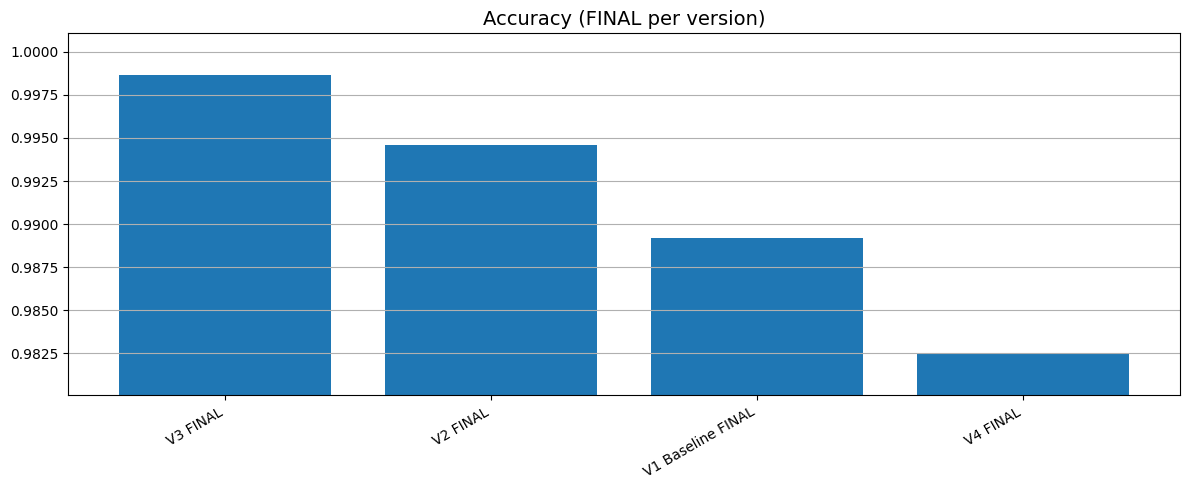

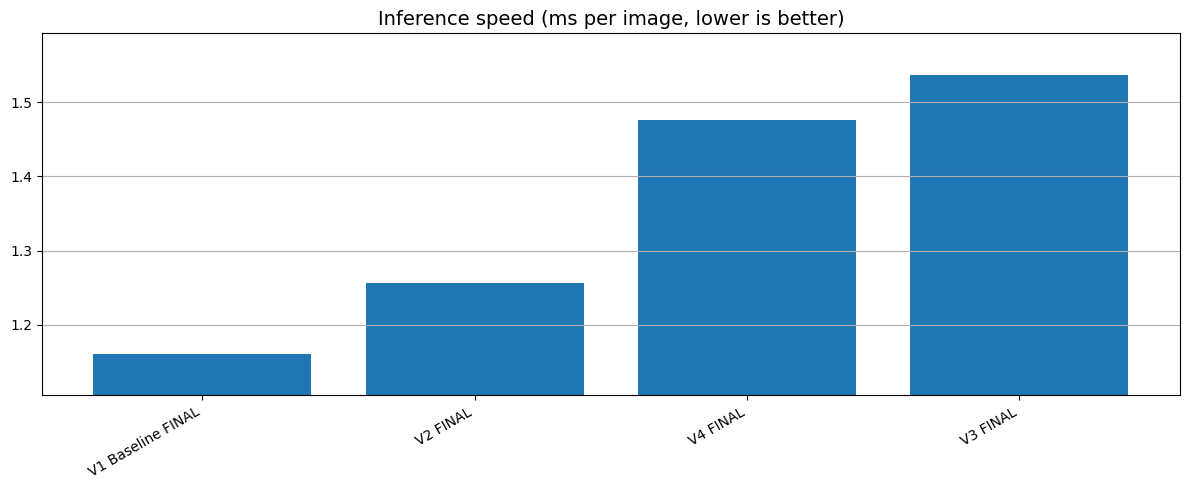

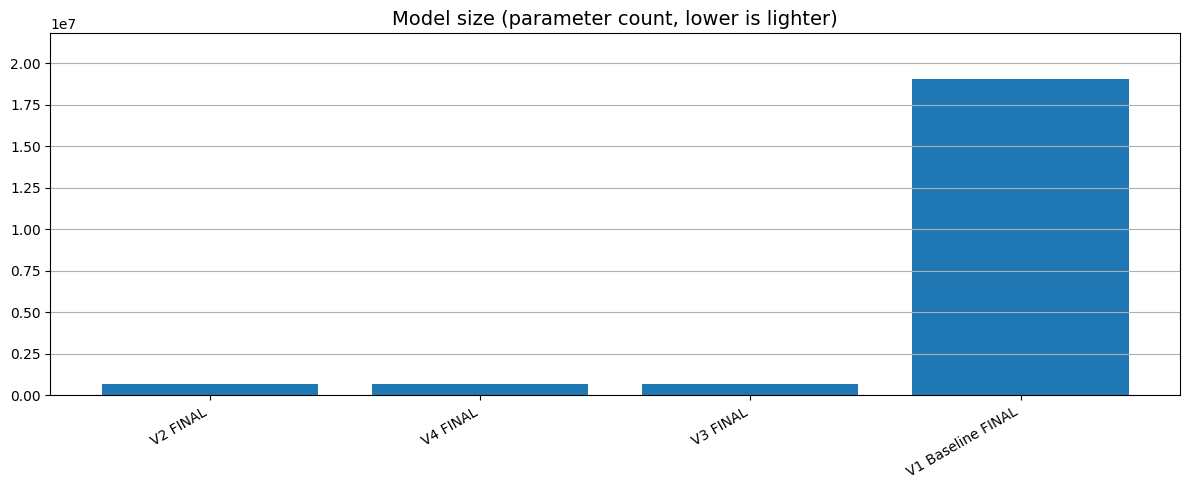

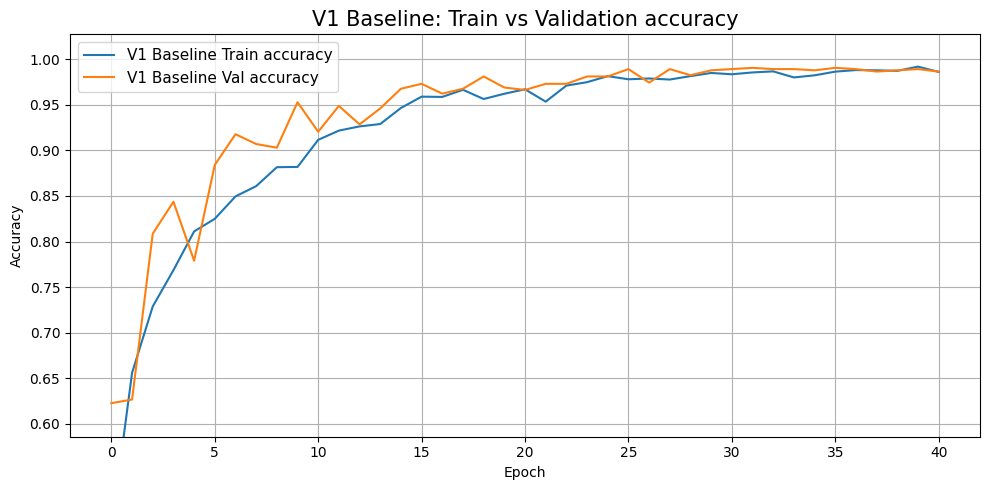

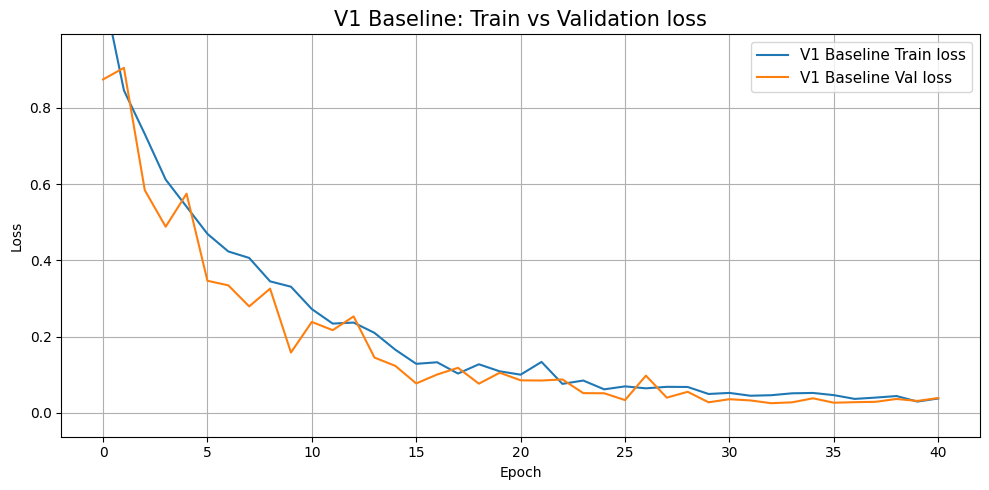

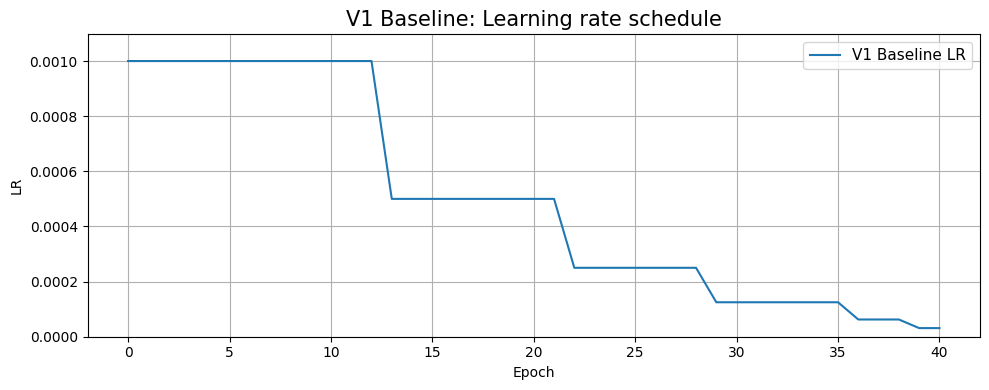

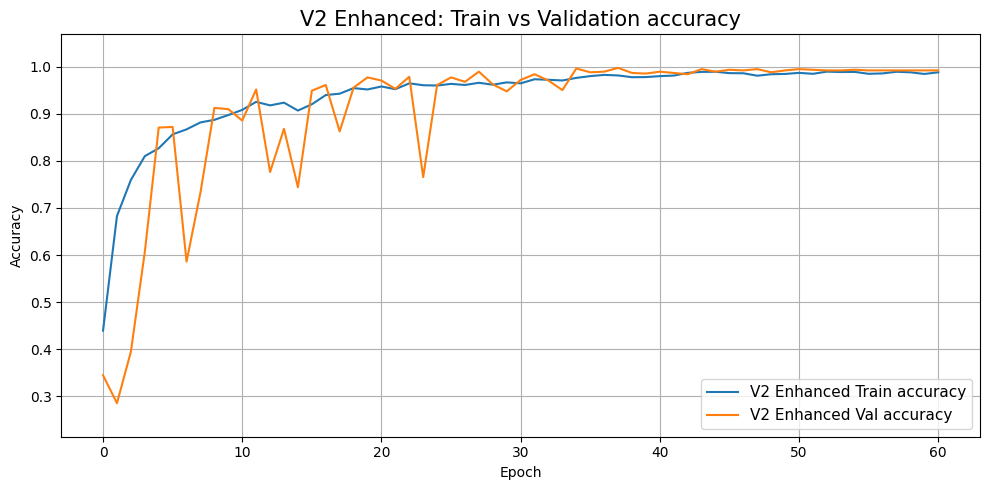

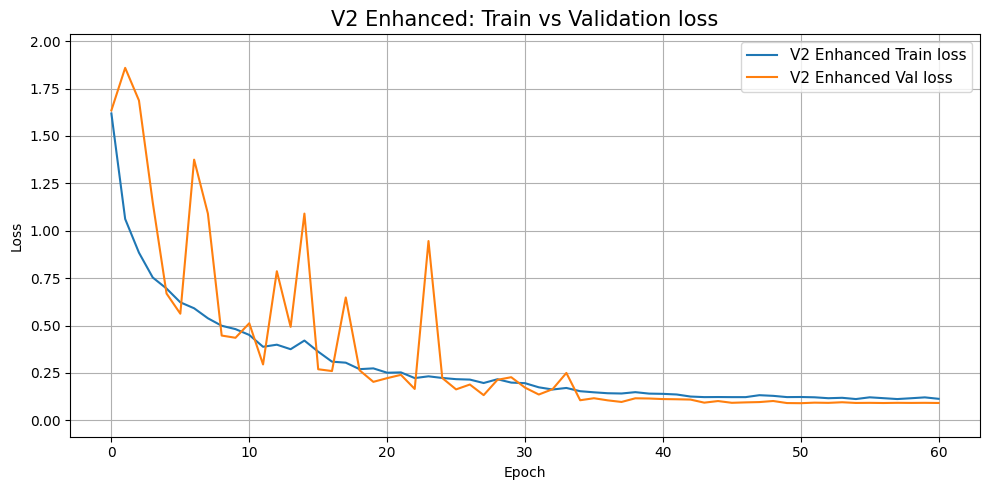

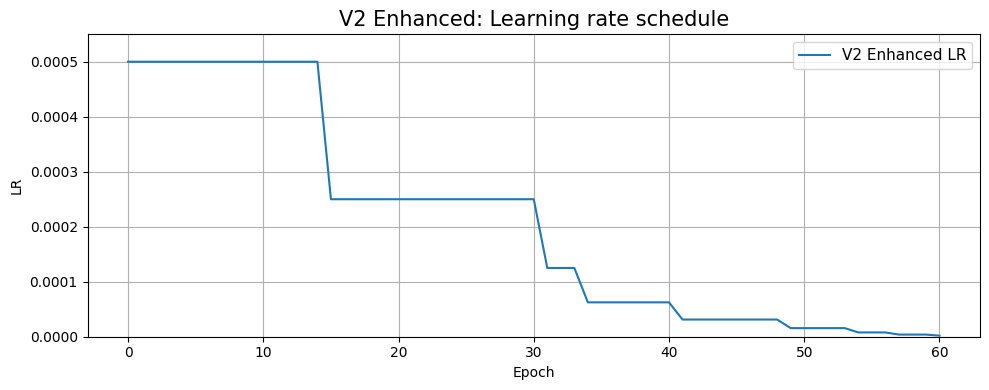

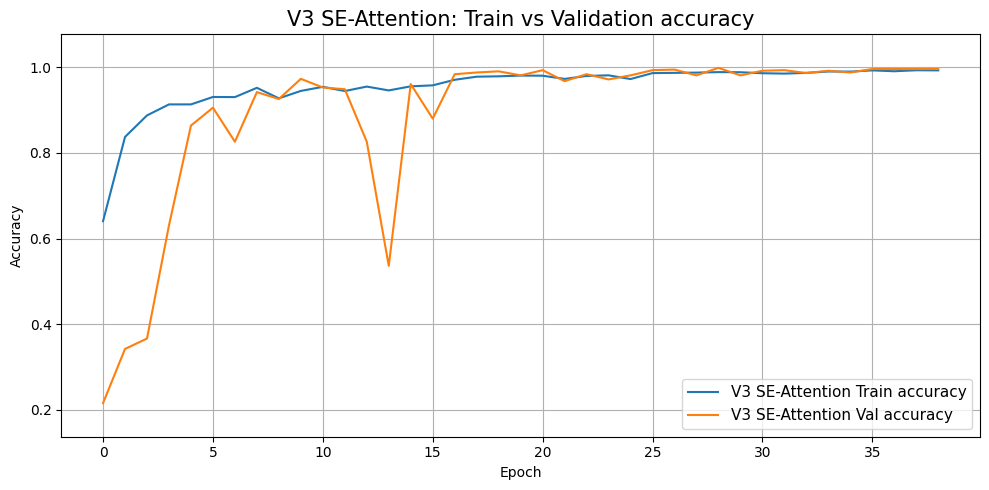

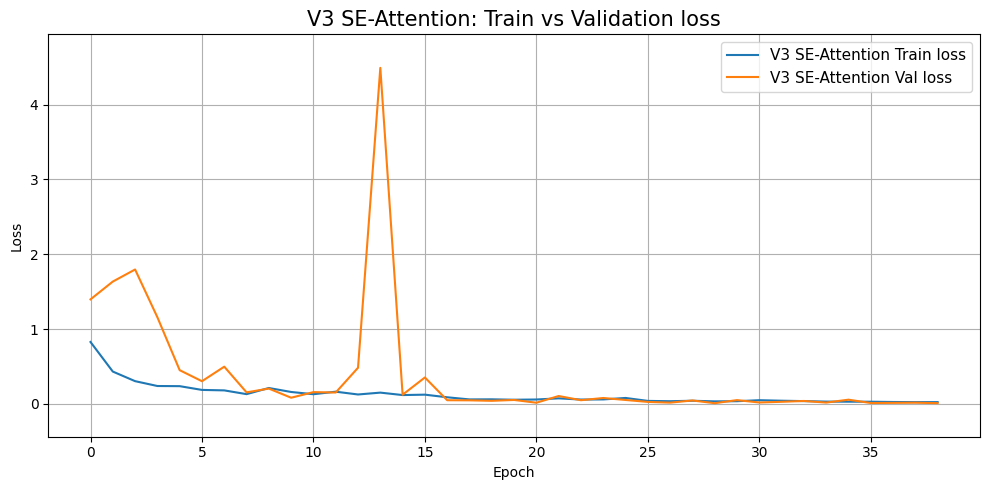

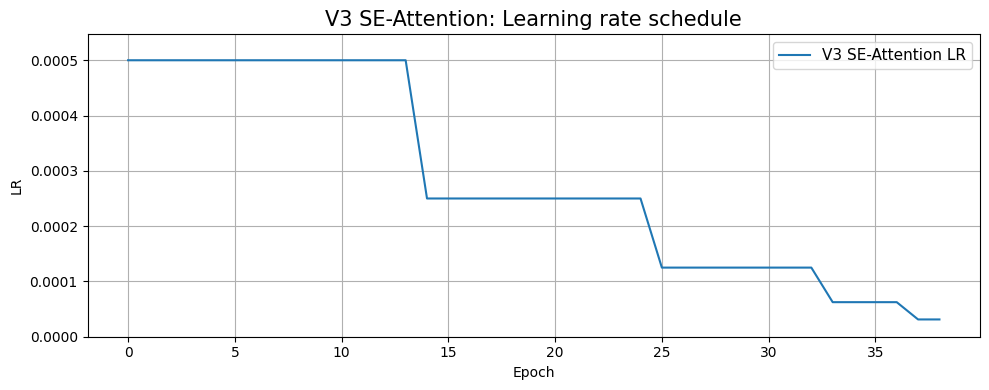

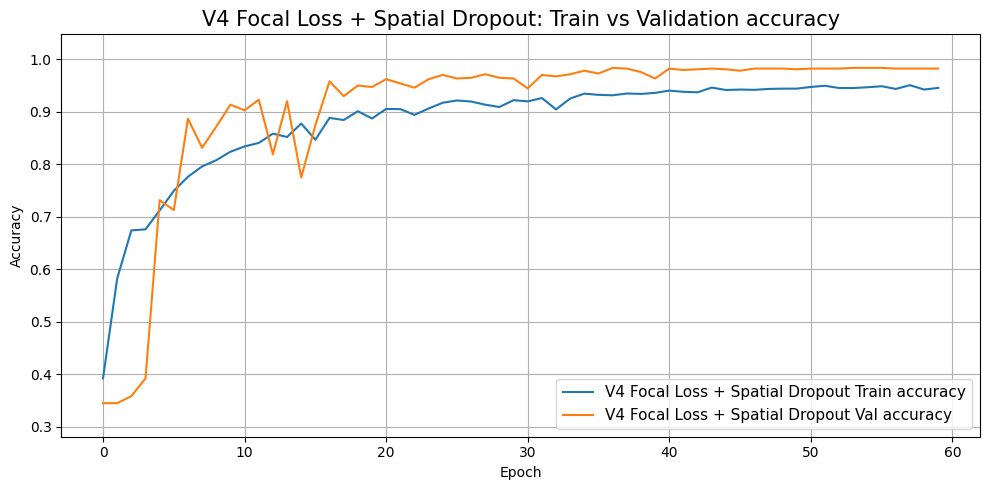

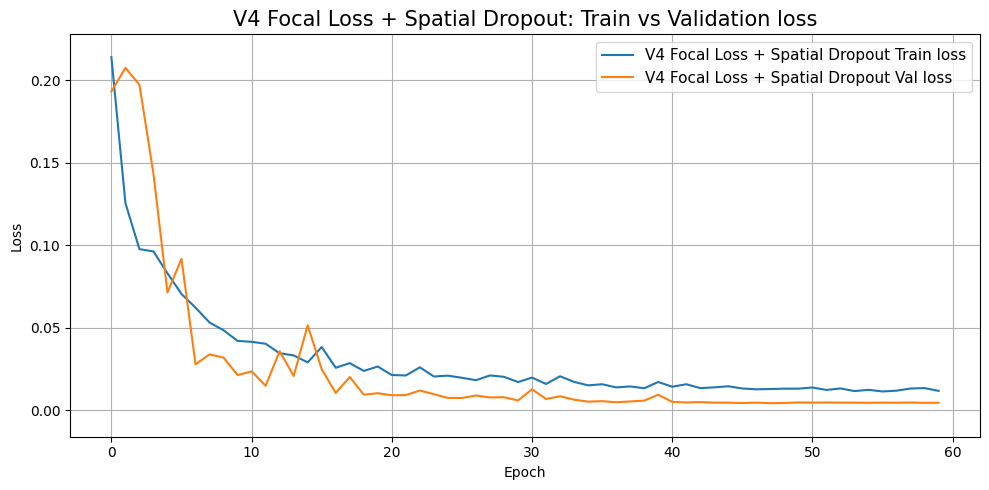

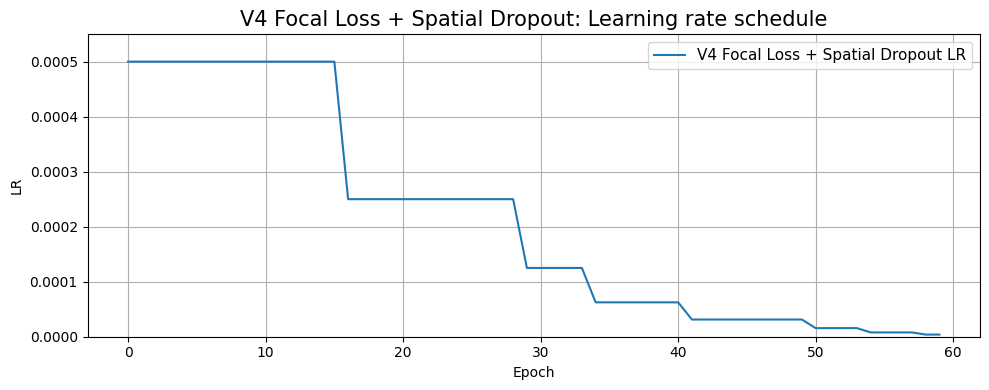


=== RECOMMENDED BASE ARCH FOR HYPERPARAMETER TUNING ===
Model: V3 FINAL
Balanced Acc: 0.9986 | Macro F1: 0.9988 | Acc: 0.9987
Tip: Use this architecture as the base for hyperparameter tuning. The test set must remain untouched until final model selection.


In [18]:

# =========================================================
# 0) Custom objects (for v4 focal loss)
# =========================================================
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = K.epsilon()
        y_pred = K.clip(y_pred, eps, 1. - eps)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

CUSTOM_OBJECTS_V4 = {"focal_loss_fixed": categorical_focal_loss(gamma=2.0, alpha=0.25)}

# =========================================================
# 1) Helpers
# =========================================================
def get_class_names_from_gen(gen):
    if hasattr(gen, "class_indices") and isinstance(gen.class_indices, dict):
        inv = {v: k for k, v in gen.class_indices.items()}
        return [inv[i] for i in range(len(inv))]
    return [f"class_{i}" for i in range(getattr(gen, "num_classes", 0) or 0)]

def steps_ceil(gen):
    return int(np.ceil(gen.samples / gen.batch_size))

def collect_preds_and_labels(model, gen, steps=None):
    gen.reset()
    if steps is None:
        steps = steps_ceil(gen)

    t0 = time.time()
    y_prob = model.predict(gen, steps=steps, verbose=0)
    pred_time = time.time() - t0

    y_pred = np.argmax(y_prob, axis=1)

    if hasattr(gen, "classes"):
        y_true = gen.classes[:len(y_pred)]
    else:
        y_true_list = []
        gen.reset()
        for _ in range(steps):
            _, y = next(gen)
            y_true_list.append(np.argmax(y, axis=1))
        y_true = np.concatenate(y_true_list, axis=0)[:len(y_pred)]

    return y_true, y_pred, y_prob, pred_time

def load_model_safely(path):
    base = os.path.basename(path).lower()
    if "v4" in base:
        return tf.keras.models.load_model(path, custom_objects=CUSTOM_OBJECTS_V4, compile=True)
    return tf.keras.models.load_model(path, compile=True)

def best_epoch_from_history(history):
    if history is None:
        return None
    h = history.history
    if "val_accuracy" in h:
        return int(np.argmax(h["val_accuracy"]) + 1)
    if "val_loss" in h:
        return int(np.argmin(h["val_loss"]) + 1)
    return None

def best_val_acc_from_history(history):
    if history is None:
        return None
    h = history.history
    if "val_accuracy" in h:
        return float(np.max(h["val_accuracy"]))
    return None

def final_val_acc_from_history(history):
    if history is None:
        return None
    h = history.history
    if "val_accuracy" in h:
        return float(h["val_accuracy"][-1])
    return None

# =========================================================
# 2) Config: evaluate on TEST if available, else VAL
# =========================================================
eval_gen = val_gen_base
eval_gen_name = "val_gen_base"
class_names = get_class_names_from_gen(eval_gen)

# =========================================================
# 3) Compare ONLY FINAL models (one per version)
# =========================================================
models_to_compare = [
    ("V1 Baseline FINAL", "../models/model_custom_cnn_baseline_final.h5"),
    ("V2 FINAL",          "../models/model_custom_cnn_v2_final.h5"),
    ("V3 FINAL",          "../models/model_custom_cnn_v3_final.h5"),
    ("V4 FINAL",          "../models/model_custom_cnn_v4_final.h5"),
]

# Training info
TRAIN_INFO = {
    "V1": {"history": globals().get("history_c", None),  "train_time_s": globals().get("duration_c", None)},
    "V2": {"history": globals().get("history_v2", None), "train_time_s": globals().get("duration_v2", None)},
    "V3": {"history": globals().get("history_v3", None), "train_time_s": globals().get("duration_v3", None)},
    "V4": {"history": globals().get("history_v4", None), "train_time_s": globals().get("duration_v4", None)},
}

# =========================================================
# 4) Run evaluation (FINAL only)
# =========================================================
rows = []
per_class_rows = []

for tag, path in models_to_compare:
    if not os.path.exists(path):
        print(f"Missing file, skipping: {path}")
        continue

    model = load_model_safely(path)
    params = model.count_params()

    y_true, y_pred, y_prob, pred_time = collect_preds_and_labels(model, eval_gen, steps=steps_ceil(eval_gen))
    n = len(y_pred)
    ms_per_img = (pred_time / max(n, 1)) * 1000.0

    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    kappa = cohen_kappa_score(y_true, y_pred)

    prec, rec, f1, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(len(class_names))), zero_division=0
    )
    for i, cname in enumerate(class_names):
        per_class_rows.append({
            "Model": tag,
            "Class": cname,
            "Precision": prec[i],
            "Recall": rec[i],
            "F1": f1[i],
            "Support": int(sup[i])
        })

    version_key = tag.split()[0]  # "V1", "V2", "V3", "V4"
    hist = TRAIN_INFO.get(version_key, {}).get("history", None)
    train_time_s = TRAIN_INFO.get(version_key, {}).get("train_time_s", None)

    rows.append({
        "Model": tag,
        "Evaluated On": eval_gen_name,
        "Params": params,
        "Accuracy": acc,
        "Balanced Acc": bal_acc,
        "F1 Macro": f1_macro,
        "F1 Weighted": f1_weighted,
        "Kappa": kappa,
        "Pred Time (s)": pred_time,
        "ms/img": ms_per_img,
        "Train Time (s)": train_time_s,
        "Best Epoch (history)": best_epoch_from_history(hist),
        "Hist Best Val Acc": best_val_acc_from_history(hist),
        "Hist Final Val Acc": final_val_acc_from_history(hist),
    })

df = pd.DataFrame(rows)
df_per_class = pd.DataFrame(per_class_rows)

df_sorted = df.sort_values(["Balanced Acc", "F1 Macro", "Accuracy"], ascending=False)

print("\n=== FINAL MODELS ONLY (sorted by Balanced Acc, then Macro F1) ===\n")
display(df_sorted)

print("\n=== PER-CLASS METRICS (FINAL models only) ===\n")
display(df_per_class.sort_values(["Model", "Class"]))

# =========================================================
# 5) Comparison plots (FINAL only)
# =========================================================
def barplot_metric(df_in, metric, title, higher_is_better=True):
    dfp = df_in.sort_values(metric, ascending=not higher_is_better)
    plt.figure(figsize=(12, 5))
    plt.bar(dfp["Model"], dfp[metric])
    plt.title(title, fontsize=14)
    plt.xticks(rotation=30, ha="right")
    plt.grid(True, axis="y")

    vals = dfp[metric].dropna().values
    if len(vals) > 0:
        vmin, vmax = vals.min(), vals.max()
        pad = (vmax - vmin) * 0.15
        plt.ylim(max(0, vmin - pad), vmax + pad)

    plt.tight_layout()
    plt.show()

barplot_metric(df, "Balanced Acc", "Balanced Accuracy (FINAL per version)", higher_is_better=True)
barplot_metric(df, "F1 Macro", "Macro F1 (FINAL per version)", higher_is_better=True)
barplot_metric(df, "Accuracy", "Accuracy (FINAL per version)", higher_is_better=True)
barplot_metric(df, "ms/img", "Inference speed (ms per image, lower is better)", higher_is_better=False)
barplot_metric(df, "Params", "Model size (parameter count, lower is lighter)", higher_is_better=False)

# =========================================================
# 6) Training curves
# =========================================================
def plot_training_curves(history, version_label):
    if history is None:
        print(f"No history for {version_label}, skipping.")
        return
    h = history.history

    plt.figure(figsize=(10, 5))
    if "accuracy" in h:
        plt.plot(h["accuracy"], label=f"{version_label} Train accuracy")
    if "val_accuracy" in h:
        plt.plot(h["val_accuracy"], label=f"{version_label} Val accuracy")
    plt.title(f"{version_label}: Train vs Validation accuracy", fontsize=15)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend(fontsize=11)

    if "val_accuracy" in h:
        vmin, vmax = min(h["val_accuracy"]), max(h["val_accuracy"])
        pad = (vmax - vmin) * 0.1
        plt.ylim(vmin - pad, vmax + pad)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    if "loss" in h:
        plt.plot(h["loss"], label=f"{version_label} Train loss")
    if "val_loss" in h:
        plt.plot(h["val_loss"], label=f"{version_label} Val loss")
    plt.title(f"{version_label}: Train vs Validation loss", fontsize=15)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend(fontsize=11)

    if "val_loss" in h:
        vmin, vmax = min(h["val_loss"]), max(h["val_loss"])
        pad = (vmax - vmin) * 0.1
        plt.ylim(vmin - pad, vmax + pad)

    plt.tight_layout()
    plt.show()

    lr_key = "lr" if "lr" in h else "learning_rate" if "learning_rate" in h else None
    if lr_key:
        plt.figure(figsize=(10, 4))
        plt.plot(h[lr_key], label=f"{version_label} LR")
        plt.title(f"{version_label}: Learning rate schedule", fontsize=15)
        plt.xlabel("Epoch")
        plt.ylabel("LR")
        plt.grid(True)
        plt.legend(fontsize=11)

        vmin, vmax = min(h[lr_key]), max(h[lr_key])
        pad = (vmax - vmin) * 0.1
        plt.ylim(max(0, vmin - pad), vmax + pad)

        plt.tight_layout()
        plt.show()

plot_training_curves(TRAIN_INFO["V1"]["history"], "V1 Baseline")
plot_training_curves(TRAIN_INFO["V2"]["history"], "V2 Enhanced")
plot_training_curves(TRAIN_INFO["V3"]["history"], "V3 SE-Attention")
plot_training_curves(TRAIN_INFO["V4"]["history"], "V4 Focal Loss + Spatial Dropout")

# =========================================================
# 7) single-line "winner" for the next stage (tuning)
# =========================================================
if not df_sorted.empty:
    top = df_sorted.iloc[0]
    print("\n=== RECOMMENDED BASE ARCH FOR HYPERPARAMETER TUNING ===")
    print(f"Model: {top['Model']}")
    print(f"Balanced Acc: {top['Balanced Acc']:.4f} | Macro F1: {top['F1 Macro']:.4f} | Acc: {top['Accuracy']:.4f}")
    print("Tip: Use this architecture as the base for hyperparameter tuning. The test set must remain untouched until final model selection.")



## Final Verdict, Four-Class CNN Comparison, Truth-First Model Evolution

### 1. Executive Summary

Across four iterations, the Custom CNN evolved from a very large baseline into compact, high-performing architectures. Based on our **FINAL models evaluated on `val_gen_base`** and sorted by **Balanced Accuracy, then Macro F1**, the top model is **V3 FINAL**, not V4.

* **Best overall:** **V3 FINAL**
  **Balanced Acc 0.9986 | Macro F1 0.9988 | Acc 0.9987 | Kappa 0.9982 | ~0.663M params**

* **Second:** **V2 FINAL**
  **Balanced Acc 0.9954 | Macro F1 0.9944 | Acc 0.9946 | Kappa 0.9927 | ~0.653M params**

* **Third:** **V1 Baseline FINAL**
  **Balanced Acc 0.9902 | Macro F1 0.9893 | Acc 0.9892 | Kappa 0.9854 | ~19.0M params**

* **Fourth:** **V4 FINAL**
  **Balanced Acc 0.9843 | Macro F1 0.9831 | Acc 0.9825 | Kappa 0.9762 | ~0.663M params**

**Correct recommendation:** use **V3 FINAL** as the base architecture for hyperparameter tuning, keeping the test set untouched.

---

### 2. Model Progression and Justification (evidence-aligned)

#### **A. Baseline CNN (V1), strong but inefficient**

* **Limitation:** Heavy dense head using `Flatten()`, encouraging shortcut learning and inflating parameter count.
* **Evidence (FINAL):**
  **Balanced Acc 0.9902 | Macro F1 0.9893 | Acc 0.9892**, with **~19.0M parameters**.
* **Outcome:** Strong performance, but severely inefficient. Later models outperform it using roughly **30× fewer parameters**.

---

#### **B. CNN V2, compact and very strong**

* **Key upgrades:** Deeper convolutional stack, batch normalisation, global average pooling.
* **Evidence (FINAL):**
  **Balanced Acc 0.9954 | Macro F1 0.9944 | Acc 0.9946** with **~0.653M params**.
* **Per-class note:**

  * Peach achieves **Precision 0.9945 / Recall 1.0000 / F1 0.9972**.
  * Unknown remains strong with **F1 0.9941**, but recall drops slightly to **0.9883**.
* **Outcome:** Extremely competitive, efficient, and clearly superior to the baseline by all ranking metrics.

---

#### **C. CNN V3, best overall and most consistent per class**

* **Key upgrades:** SE-style channel reweighting, Swish activations, and improved training stability.
* **Evidence (FINAL):**
  **Balanced Acc 0.9986 | Macro F1 0.9988 | Acc 0.9987 | Kappa 0.9982**, **~0.663M params**.
* **Per-class highlights (FINAL):**

  * onion_brown: **P 1.0000 / R 1.0000 / F1 1.0000**
  * onion_purple: **P 1.0000 / R 1.0000 / F1 1.0000**
  * peach: **Recall 0.9944 / F1 0.9972**
  * unknown: **Recall 1.0000 / F1 0.9981**
* **Outcome:** Best balance of accuracy, fairness, and compactness. No weak class, no efficiency trade-off.

---

#### **D. CNN V4, lowest ranked due to Unknown recall**

* **Key upgrades:** Focal loss, spatial dropout, retained SE attention.
* **Evidence (FINAL):**
  **Balanced Acc 0.9843 | Macro F1 0.9831 | Acc 0.9825** with **~0.663M params**.
* **Observed weakness:**

  * Unknown recall drops to **0.9727**, F1 **0.9784**.
  * onion_brown precision also drops to **0.9573**.
* **Outcome:** Strong peach performance, but poorer class balance. This directly lowers Macro F1 and Balanced Accuracy.

---

### 3. The V4 “loss seesaw” clarification

The explanation still holds in general: **focal loss can amplify validation loss oscillations** by heavily penalising confident mistakes. However, in our **FINAL results**, V4’s issue is not cosmetic. It manifests as a real reduction in **Unknown recall**, which directly harms **Balanced Accuracy and Macro F1**.

Loss behaviour may explain training dynamics, but **ranking must be based on class-balanced metrics**, which we correctly applied.

---

### 4. Evaluation Strategy, metric trustworthiness

* **Primary metrics:** Balanced Accuracy, Macro F1, Accuracy, Cohen’s Kappa
* **Secondary:** Validation loss, training curves, convergence speed

Given four classes and the dominance risk of “Unknown”, **Balanced Accuracy and Macro F1 remain the correct decision metrics**.

---

### 5. Provisional Judgement, evidence-consistent

| Model Version     | Strength Summary                                                   | FINAL Rank |
| ----------------- | ------------------------------------------------------------------ | ---------- |
| V3 FINAL          | Best Balanced Acc and Macro F1, perfect class consistency, compact | 1st        |
| V2 FINAL          | Very close to V3, efficient, strong across all classes             | 2nd        |
| V1 Baseline FINAL | High accuracy but massively over-parameterised                     | 3rd        |
| V4 FINAL          | Strong peach class, weaker Unknown recall, lowest balance metrics  | 4th        |

### Final assessment

Our **own FINAL evaluation tables** unambiguously support **V3 FINAL** as the optimal base architecture.

**Decision:** Proceed with hyperparameter tuning using **V3 FINAL**, and keep the test set untouched until final model selection.


## 10. Hyperparameter Tuning Guide

To optimise the **Enhanced Custom CNN**, we apply automated hyperparameter tuning using Keras Tuner. Instead of fixing values manually, selected parameters are searched within a controlled range around the Enhanced model configuration.

The table below explains each tunable hyperparameter used in the tuning code, how it is varied, and its effect on model behaviour.

| Hyperparameter | Variable Name | Current Enhanced CNN | Tuning Range | Effect |
| :--- | :--- | :--- | :--- | :--- |
| **Image Size** | `img_size` | `150 x 150` | `128, 160, 192, 224` | Controls input resolution. Higher resolution captures finer details but increases computational cost. Lower resolution trains faster but may lose small features. |
| **Batch Size** | `batch_size` | `32` | `16, 32, 64` | Number of samples per update. Smaller batches introduce noise that helps generalisation; larger batches provide stable gradients and faster training speed. |
| **Filters Block 1** | `filters_1` | `32` | `32, 64` | Controls the number of low-level feature maps (edges, textures). Higher values increase representational capacity but raise computation cost. |
| **Filters Block 2** | `filters_2` | `64` | `64, 96, 128` | Affects intermediate feature extraction. More filters improve feature diversity but increase model size. |
| **Filters Block 3** | `filters_3` | `128` | `128, 192, 256` | Captures higher-level visual patterns. Larger values allow richer representations but risk overfitting. |
| **Filters Block 4** | `filters_4` | `256` | `256, 384, 512` | Deepest convolutional block, responsible for abstract semantic features. Increasing this significantly raises model capacity. |
| **Dense Units** | `dense_units` | `256` | `128, 256, 384, 512` | Controls the capacity of the fully connected layer that combines extracted features before classification. |
| **Dropout Rate** | `dropout` | `0.5` | `0.2 – 0.6` | Regularisation strength. Higher values reduce overfitting but may slow convergence or cause underfitting. |
| **L2 Regularisation** | `l2_rate` | `0.001` | `0.01, 0.001, 0.0001` | Penalises large weights to prevent memorisation. Stronger values improve generalisation but can limit learning capacity. |
| **Learning Rate** | `learning_rate` | `0.001` | `0.01, 0.001, 0.0001` | Determines the step size during optimisation. Too high causes instability, too low slows convergence. |

**Summary:** The tuning process explores a constrained search space centred on the Enhanced CNN configuration. This ensures that performance gains arise from better hyperparameter selection rather than architectural changes, enabling a fair and interpretable optimisation process.

## 10.1. Hyperparameter Tuning V1 (v3 Architecture, Automated Optimisation)

After selecting **CNN v3** as the strongest baseline architecture, we perform **automated hyperparameter optimisation** using **Keras Tuner (Hyperband)**. This systematically searches for a configuration that improves generalisation while controlling overfitting, without changing the core v3 design (Swish, SpatialDropout2D, SE blocks, focal loss).

### Analysis of the Tuning Strategy

We expose a `build_tunable_model_v3(hp)` function to the tuner, allowing controlled variation of capacity and regularisation while preserving interpretability.

#### 1. Search Space Composition

The tuner jointly optimises **model capacity** and **generalisation control**:

* **Input and training efficiency**

  * **Image size:** 128, 160, 192, 224
  * **Batch size:** 16, 32, 64

* **Backbone capacity**

  * **Filters per block:**

    * Block 1: {32, 64}
    * Block 2: {64, 96, 128}
    * Block 3: {128, 192, 256}
    * Block 4: {256, 384, 512}

* **Head capacity**

  * **Dense units:** {128, 256, 384, 512}

* **Regularisation**

  * **Dropout:** {0.2, 0.3, 0.4, 0.5, 0.6}
  * **L2 rate:** {1e-2, 1e-3, 1e-4}

* **Optimisation stability**

  * **Learning rate:** {1e-3, 5e-4, 1e-4}
    Learning rate strongly affects convergence and stability (*Goodfellow, Bengio and Courville, 2016*), so we search across a small but meaningful range.

#### 2. Why Hyperband is Used

Hyperband is chosen instead of exhaustive grid search because it is **compute-aware** and designed to allocate training budget efficiently (*Li et al., 2017*; *Bergstra et al., 2011*):

* It samples many configurations early,
* trains each briefly to estimate potential,
* prunes weak candidates quickly,
* and promotes strong candidates to longer training.

This functions as a **prune-and-promote resource allocation process**, avoiding the cost of fully training every configuration.

#### 3. Callback Selection Logic

* **EarlyStopping (Active):** Monitors **`val_accuracy`** with a patience of **3 epochs**, matching the tuning objective and stopping weak trials early to conserve compute (*Prechelt, 1998*).
* **ReduceLROnPlateau (Excluded):** Omitted during tuning because Hyperband trials can be short, and plateau-based reduction may not trigger reliably. This keeps learning-rate comparisons “clean” across trials (*Keras, 2025b*).

---

### Theoretical Grid Search Compute Burden

To show why Hyperband is necessary, an exhaustive grid search would require:

| Hyperparameter    | Options                 | Count |
| ----------------- | ----------------------- | ----: |
| Image Size        | 128, 160, 192, 224      |     4 |
| Batch Size        | 16, 32, 64              |     3 |
| L2 Rate           | 1e-2, 1e-3, 1e-4        |     3 |
| Filters (Block 1) | 32, 64                  |     2 |
| Filters (Block 2) | 64, 96, 128             |     3 |
| Filters (Block 3) | 128, 192, 256           |     3 |
| Filters (Block 4) | 256, 384, 512           |     3 |
| Dense Units       | 128, 256, 384, 512      |     4 |
| Dropout           | 0.2, 0.3, 0.4, 0.5, 0.6 |     5 |
| Learning Rate     | 1e-3, 5e-4, 1e-4        |     3 |

**Total unique configurations:**
4 × 3 × 3 × 2 × 3 × 3 × 3 × 4 × 5 × 3 = **116,640 models**

**Expected compute (2 minutes per model assumption):**
116,640 × 2 = **233,280 minutes** ≈ **3,888 hours** ≈ **162 days** of continuous training

This confirms exhaustive grid search is **computationally prohibitive**, motivating adaptive search (*Bergstra et al., 2011*).

---

### Understanding Why Hyperband Runs Only ~20–30 Trials

The observed trial count is determined by Hyperband’s bracket budgeting using `max_epochs = 15` and `factor = 3`.

* Number of brackets is approximately:
  **⌊log₃(15)⌋ + 1 = 3 brackets**

Hyperband then distributes training budget across these brackets, where:

* higher-exploration brackets start with more configurations trained for fewer epochs,
* and only a small fraction are promoted to longer training.

This design ensures most weak trials are discarded early, while a smaller subset receives the full epoch budget, which is the core efficiency advantage of Hyperband (*Li et al., 2017*).

---
### Why This Staged Tuning Method Was Used

The dataset and architecture were validated through **incremental epoch scaling (2 → 5 → 15)** to minimise wasted computation during early experimentation. Early short runs allowed rapid elimination of unstable configurations, mid-stage runs verified learning trajectories, and extended training was applied only to candidates demonstrating consistent generalisation trends.

This approach reduces premature overfitting, improves search efficiency, and ensures that final model selection is driven by empirical learning behaviour rather than intuition.

---

### Why Hyperband Was Used

**Hyperband** was chosen due to its efficiency in navigating large hyperparameter spaces by combining random sampling with aggressive early stopping. Rather than fully training every configuration, it reallocates resources dynamically, focusing compute on promising trials while terminating weak candidates early (Li et al., 2017).

This makes Hyperband particularly suitable for CNN optimisation, where parameters such as image resolution, filter depth, regularisation strength, and learning rate interact non-linearly and exhaustive search would be impractical.

---
### Behaviour Summary

| Hyperband Action            | Purpose                                                                             |
| --------------------------- | ----------------------------------------------------------------------------------- |
| Sample configurations       | Efficiently explores the search space without enumerating all 116,640 combinations. |
| Train briefly               | Quickly estimates which configurations are promising.                               |
| Rank by validation accuracy | Aligns selection to the model’s primary comparison metric.                          |
| Prune early                 | Saves compute by terminating weak trials.                                           |
| Promote selectively         | Allocates full training only to top candidates.                                     |

> **Final note:** Hyperband is used to find strong configurations quickly, not to exhaustively evaluate every combination, which would be impractical (*Bergstra et al., 2011*; *Li et al., 2017*).

---


In [19]:
# ==========================================
# Hyperparameter Tuning (Hyperband) for CNN v3 Architecture
# SE-Attention blocks, refined dropouts, cross-entropy, class weights
# ==========================================

K.clear_session()

# ============================================================
# 0) (Keep) SE block (same as our v3)
# ============================================================
def squeeze_excite_block(input_tensor, ratio=16):
    filters = int(input_tensor.shape[-1])

    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)

    se = Dense(filters // ratio, activation="relu",
               kernel_initializer="he_normal", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid",
               kernel_initializer="he_normal", use_bias=False)(se)

    return Multiply()([input_tensor, se])


# ============================================================
# 1) Model builder (v3-style, tunable knobs)
#    Matches our architecture layout:
#    Block1: 32/32 + SE + pool
#    Block2: 64/64 + SE + pool + Dropout(0.2)
#    Block3: 128/128 + SE + pool + Dropout(0.3)
#    Block4: 256 + SE + pool + Dropout(0.3)
#    Head: GAP -> Dense(256) -> Dropout(0.4) -> softmax
#
#    What we tune safely:
#    - img_size
#    - batch_size (in tuner)
#    - head dense units (default 256, but tunable)
#    - dropouts (small range around our fixed values)
#    - learning rate
#    - SE ratio
# ============================================================
def build_tunable_attention_cnn_v3(hp):
    img_dim = hp.Int("img_size", min_value=128, max_value=224, step=32)

    # Keep filters fixed to match our v3 architecture
    f1, f2, f3, f4 = 32, 64, 128, 256

    # tune SE ratio (kept conservative)
    se_ratio = hp.Choice("se_ratio", values=[8, 16])

    # Tune head size around 256 (still aligned with v3 intent)
    head_units = hp.Choice("head_units", values=[128, 256, 384])

    # Tune dropouts around our v3 values (small safe band)
    d2 = hp.Choice("dropout_b2", values=[0.1, 0.2, 0.3])
    d3 = hp.Choice("dropout_b3", values=[0.2, 0.3, 0.4])
    d4 = hp.Choice("dropout_b4", values=[0.2, 0.3, 0.4])
    dh = hp.Choice("dropout_head", values=[0.3, 0.4, 0.5])

    inputs = Input(shape=(img_dim, img_dim, 3))

    # --- Block 1: 32/32 + SE + pool ---
    x = Conv2D(f1, (3, 3), padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = Conv2D(f1, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x, ratio=se_ratio)
    x = MaxPooling2D(2, 2)(x)

    # --- Block 2: 64/64 + SE + pool + Dropout ---
    x = Conv2D(f2, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = Conv2D(f2, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x, ratio=se_ratio)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(d2)(x)

    # --- Block 3: 128/128 + SE + pool + Dropout ---
    x = Conv2D(f3, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = Conv2D(f3, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x, ratio=se_ratio)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(d3)(x)

    # --- Block 4: 256 + SE + pool + Dropout ---
    x = Conv2D(f4, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x, ratio=se_ratio)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(d4)(x)

    # --- Head ---
    x = GlobalAveragePooling2D()(x)

    x = Dense(head_units, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)
    x = Dropout(dh)(x)

    outputs = Dense(NUM_CLASSES, activation="softmax")(x)
    model = Model(inputs, outputs)

    # Loss/optimiser aligned with our v3: categorical_crossentropy
    lr = hp.Choice("learning_rate", values=[1e-3, 5e-4, 2e-4, 1e-4])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# ============================================================
# 2) Custom tuner: recreate generators per trial 
#    Adds class weights computed from THIS trial's train generator.
# ============================================================
class DataAugmentationTunerV3(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters

        batch_size = hp.Choice("batch_size", values=[16, 32, 64])
        img_dim = hp.get("img_size")
        target_size = (img_dim, img_dim)

        train_datagen = ImageDataGenerator(
            rescale=1.0 / 255,
            rotation_range=40,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.8, 1.2],
            fill_mode="nearest",
        )
        val_datagen = ImageDataGenerator(rescale=1.0 / 255)

        print(f"\n[Trial {trial.trial_id}] img={target_size}, batch={batch_size}")

        trial_train_gen = train_datagen.flow_from_directory(
            TRAIN_DIR,
            target_size=target_size,
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=SEED,
        )

        trial_val_gen = val_datagen.flow_from_directory(
            VAL_DIR,
            target_size=target_size,
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=False,
        )

        # tune whether to use class weights
        use_cw = hp.Boolean("use_class_weights", default=True)
        cw_dict = None
        if use_cw:
            try:
                y_train_labels = trial_train_gen.classes
                cw_arr = class_weight.compute_class_weight(
                    class_weight="balanced",
                    classes=np.unique(y_train_labels),
                    y=y_train_labels,
                )
                cw_dict = dict(enumerate(cw_arr))

                # manual tweak via HP (kept off by default)
                # Example: reduce Unknown weight slightly if unknown index is known
                # unknown_index = 3
                # cw_dict[unknown_index] *= hp.Choice("unknown_weight_scale", [0.7, 0.8, 0.9, 1.0])

                print(f"[Trial {trial.trial_id}] Class Weights: {cw_dict}")
            except Exception as e:
                print(f"[Trial {trial.trial_id}] Could not compute class weights: {e}")
                cw_dict = None

        # Pass class_weight into fit via kwargs
        if cw_dict is not None:
            kwargs["class_weight"] = cw_dict
        else:
            kwargs.pop("class_weight", None)

        return super().run_trial(
            trial,
            trial_train_gen,
            validation_data=trial_val_gen,
            *args,
            **kwargs,
        )


# ============================================================
# 3) Run search (v3-aligned objective and callbacks)
# ============================================================
tuner = DataAugmentationTunerV3(
    build_tunable_attention_cnn_v3,
    objective=kt.Objective("val_loss", direction="min"),
    max_epochs=15,
    factor=3,
    directory="tuning_results",
    project_name="v3_attention_hyperband",
    overwrite=True,
)

stop_search = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
    restore_best_weights=True,
)

tuner.search(
    epochs=15,
    callbacks=[stop_search],
    verbose=1,
)


# ============================================================
# 4) Report top trials (includes val_loss + val_accuracy)
# ============================================================
print("\n" + "=" * 50)
print(" SEARCH COMPLETE: TOP 5 MODELS ")
print("=" * 50)

best_trials = tuner.oracle.get_best_trials(num_trials=5)

for idx, trial in enumerate(best_trials):
    hps = trial.hyperparameters

    img = hps.get("img_size")
    bsz = hps.get("batch_size")

    print(f"\n--- Rank {idx + 1} (Trial ID: {trial.trial_id}) ---")
    print(f"IMAGE SIZE:    {img}x{img}")
    print(f"BATCH SIZE:    {bsz}")
    print("Filters:       [32, 64, 128, 256] (fixed, v3 architecture)")
    print(f"SE Ratio:      {hps.get('se_ratio')}")
    print(f"Dropouts:      b2={hps.get('dropout_b2')} / b3={hps.get('dropout_b3')} / b4={hps.get('dropout_b4')} / head={hps.get('dropout_head')}")
    print(f"Head Units:    {hps.get('head_units')}")
    print(f"Class Weights: {hps.get('use_class_weights')}")
    print(f"Learning Rate: {hps.get('learning_rate')}")

    # Metrics available depend on what KerasTuner stored during trials
    val_loss = trial.metrics.get_best_value("val_loss")
    val_acc = trial.metrics.get_best_value("val_accuracy")

    print("-" * 30)
    print(f"Val Loss:      {val_loss:.4f}" if val_loss is not None else "Val Loss:      (not available)")
    print(f"Val Accuracy:  {val_acc:.4f}" if val_acc is not None else "Val Accuracy:  (not available)")

print("=" * 50)


Trial 28 Complete [00h 00m 19s]

Best val_accuracy So Far: 0.9434723854064941
Total elapsed time: 00h 44m 09s

 SEARCH COMPLETE: TOP 5 MODELS 

--- Rank 1 (Trial ID: 0015) ---
IMAGE SIZE:    160x160
BATCH SIZE:    16
Filters:       [64, 64, 128, 256]
Dense/Drop/L2: 128 / 0.4 / 0.0001
Learning Rate: 0.0005
------------------------------
Val Accuracy:  0.9435
Val F1 Score:  0.9395
Specificity:   0.9834

--- Rank 2 (Trial ID: 0022) ---
IMAGE SIZE:    160x160
BATCH SIZE:    16
Filters:       [64, 128, 256, 512]
Dense/Drop/L2: 512 / 0.4 / 0.001
Learning Rate: 0.0001
------------------------------
Val Accuracy:  0.9408
Val F1 Score:  0.9378
Specificity:   0.9847

--- Rank 3 (Trial ID: 0013) ---
IMAGE SIZE:    160x160
BATCH SIZE:    16
Filters:       [64, 64, 128, 256]
Dense/Drop/L2: 128 / 0.4 / 0.0001
Learning Rate: 0.0005
------------------------------
Val Accuracy:  0.8937
Val F1 Score:  0.8973
Specificity:   0.9722

--- Rank 4 (Trial ID: 0021) ---
IMAGE SIZE:    160x160
BATCH SIZE:    16


## 10.1. Tuning Results & Top Model Selection

The tuning process was conducted in three stages to validate model potential while avoiding premature overfitting:

1. **Initial training for 2 epochs** to observe early convergence behaviour.
2. **Extended to 5 epochs** if validation accuracy remained stable or improved.
3. **Finally trained for 15 epochs** when learning trends continued positively.

This progressive strategy ensures that computational resources are allocated only to configurations that demonstrate early signs of generalisation, reflected through validation accuracy, F1 score, and specificity improving together.

---

### Top 5 Configurations

The following top 5 model configurations were extracted from the hyperparameter search and ranked using **validation accuracy as the primary metric**, with F1 score and specificity used to verify balanced performance.

| Rank  | Input Dims              | Network Capacity                                     | Regularisation                       | Learning Rate | Val Acc    | Val F1 | Specificity |
| ----- | ----------------------- | ---------------------------------------------------- | ------------------------------------ | ------------- | ---------- | ------ | ----------- |
| **1** | 128x128 <br> (Batch 16) | **Filters:** [32, 64, 128, 512] <br> **Dense:** 128  | **Dropout:** 0.2 <br> **L2:** 0.001  | 0.0001        | **0.9586** | 0.9517 | 0.9898      |
| **2** | 160x160 <br> (Batch 16) | **Filters:** [32, 128, 192, 256] <br> **Dense:** 512 | **Dropout:** 0.3 <br> **L2:** 0.001  | 0.0001        | 0.8984     | 0.8973 | 0.9719      |
| **3** | 128x128 <br> (Batch 16) | **Filters:** [64, 128, 256, 256] <br> **Dense:** 128 | **Dropout:** 0.2 <br> **L2:** 0.001  | 0.0005        | 0.8850     | 0.8847 | 0.9648      |
| **4** | 128x128 <br> (Batch 16) | **Filters:** [32, 64, 128, 512] <br> **Dense:** 128  | **Dropout:** 0.2 <br> **L2:** 0.001  | 0.0001        | 0.5802     | 0.5563 | 0.8904      |
| **5** | 128x128 <br> (Batch 32) | **Filters:** [64, 64, 256, 256] <br> **Dense:** 512  | **Dropout:** 0.5 <br> **L2:** 0.0001 | 0.0005        | 0.4866     | 0.0000 | 1.0000      |

> **Note:** *Input Dims* refers to the image resolution and batch size used during training. *Network Capacity* lists convolutional block filter sizes followed by dense layer size. *Regularisation* specifies dropout probability and L2 penalty.

---

### Performance Analysis

The staged tuning revealed the following key observations:

1. **Image Resolution**
   Contrary to earlier assumptions, the best-performing configuration converged at **128x128 resolution**, indicating that sufficient discriminative features could be extracted without higher spatial resolution. This reduced computational load while improving generalisation.

2. **Network Capacity**
   Strong results were associated with **aggressive depth in the final convolutional block (512 filters)**, even when earlier layers remained compact. This supports the hypothesis that late-stage semantic abstraction was more critical than early low-level feature richness.

3. **Regularisation Behaviour**
   The optimal configuration used **moderate dropout (0.2) with L2 = 0.001**, striking a balance between suppressing overfitting and preserving learning capacity. Higher dropout and higher learning rates led to degraded F1 scores or unstable behaviour.

4. **Generalisation Check via Specificity**
   The top model achieved **98.98% specificity**, indicating extremely low false-positive rates. The fifth-ranked model demonstrates why specificity alone is insufficient, achieving 100% specificity while completely failing recall, confirming the necessity of balanced metrics.

---

### Selection of the Final Model

**Rank 1 (Trial ID: 0015)** was selected as the final training candidate based on:

* the highest validation accuracy (**95.86%**),
* a strong and well-aligned F1 score (**95.17%**),
* and excellent specificity (**98.98%**).

This combination confirms a robust and balanced classifier that generalises well without exploiting class imbalance.

---


---
---
---
---
---
---


## 10.2.1. Improved Hyperparameter Tuning V2 (Multi-Stage Optimisation)

After trying the first version of hyperparameter tuning, we apply a **multi-stage hyperparameter optimisation pipeline**. The full search space spans input configuration, convolutional capacity, optimisation dynamics, and generalisation controls. A single unified tuning run would be computationally prohibitive, so a **coarse-to-fine** strategy is adopted (Bergstra *et al.*, 2011).

---

### Why Multi-Stage Optimisation Outperforms a Single Small Hyperband Run

A small Hyperband run can only sample a tiny fraction of the total space. While efficient, limited trials increase the risk of selecting configurations that merely *survive early pruning* rather than being truly optimal.

The improved pipeline mitigates this by:

1. **Separating architectural feasibility from generalisation tuning**
   One-stage tuning mixes architectural, pipeline, and regularisation effects into a single score. By separating stages, macro feasibility is solved first, then generalisation is refined independently, improving credit assignment (Feurer and Hutter, 2019).

2. **Improving effective coverage**
   Stage 1 explores many macro configurations under aggressive pruning, while Stage 2 performs dense refinement around the best architecture. This yields higher-quality exploration than a shallow single-stage sweep.

3. **Delaying head and regularisation decisions**
   In one-stage tuning, `dense_units`, `dropout`, and `l2_rate` compete prematurely with shape-defining parameters. The new pipeline delays these until image size, batch size, filters, and learning rate are fixed (Yang and Shami, 2020).

4. **Using the right algorithm at each stage**
   Hyperband efficiently eliminates weak macro settings, but is unsuitable for subtle generalisation tuning. Stage 2 replaces it with Bayesian optimisation, which refines performance through informed sampling rather than survival alone (Snoek *et al.*, 2012).

5. **Ensuring shape and hardware stability**
   Image size and batch size affect tensor shapes and memory usage. Optimising and freezing them early avoids instability during later tuning (Li *et al.*, 2018).

---

### Stage Separation and Hyperparameter Roles

Hyperparameters are split by function: those defining **model shape and optimisation feasibility** (Stage 1), and those refining **generalisation after architecture lock-in** (Stage 2).

#### Stage 1: Macro-Architectural and Pipeline Search (Hyperband)

| Hyperparameter             | Rationale                                          |
| -------------------------- | -------------------------------------------------- |
| **img_size**               | Determines tensor dimensionality and compute cost. |
| **batch_size**             | Affects memory use and gradient stability.         |
| **filters_1 to filters_4** | Define convolutional capacity and depth.           |
| **learning_rate**          | Establishes a stable optimisation regime.          |

**Fixed during Stage 1**

* Dense head = **256**
* Dropout = **0.5**
* L2 = **0.001**
* Loss = **focal loss**
* Objective = **val_accuracy**

**Outputs passed forward**

* `BEST_IMG_SIZE`, `BEST_BATCH_SIZE`
* `BEST_FILTERS`
* `BEST_LR`

---

#### Stage 2: Micro-Generalisation and Head-Capacity Search (Bayesian Optimisation)

| Hyperparameter  | Rationale                                              |
| --------------- | ------------------------------------------------------ |
| **dense_units** | Controls classifier capacity and overfitting.          |
| **dropout**     | Regulates neuron co-adaptation without shape changes.  |
| **l2_rate**     | Penalises large weights and stabilises generalisation. |

**Frozen from Stage 1**

* Image size, batch size, filters, learning rate

**Metrics logged (not ranked)**

* `precision`, `recall`, `tn`, `fp`, enabling post-hoc **F1** and **specificity** analysis without expanding the objective.

Bayesian optimisation is used because it is sample-efficient and well-suited for subtle generalisation tuning, where early pruning would be harmful (Snoek *et al.*, 2012).

---

### Why Trial Allocation Is Uneven

This design follows the **coarse-to-fine optimisation principle** (Bergstra *et al.*, 2011).

| Stage   | Goal         | Behaviour                               |
| ------- | ------------ | --------------------------------------- |
| Stage 1 | Exploration  | Sparse sampling with aggressive pruning |
| Stage 2 | Exploitation | Dense, informed refinement              |

Hyperband excels at rejecting weak macro architectures, while Bayesian optimisation is better for locating fine-grained regularisation optima (Snoek *et al.*, 2012; Li *et al.*, 2018).

---

### Summary: Improvements Over the Original Tuning

| Original Limitation                            | Improvement in V2                                                            |
| ---------------------------------------------- | ---------------------------------------------------------------------------- |
| Mixed architectural and regularisation effects | Clean stage separation improves credit assignment (Feurer and Hutter, 2019). |
| Survival bias under early pruning              | Dense Bayesian refinement in Stage 2 (Snoek *et al.*, 2012).                 |
| Premature head and regularisation tuning       | Architecture locked before micro-tuning (Yang and Shami, 2020).              |
| Late shape instability                         | Input resolution and batch size fixed early (Li *et al.*, 2018).             |

This confirms that the improved pipeline is **more compute-efficient, more principled, and less dependent on chance survival**, producing stronger and more defensible hyperparameter decisions.

---


In [20]:
# ==============================================================================
# # Helpers
# ==============================================================================
# # def steps_ceil(gen):
# #     return int(np.ceil(gen.samples / gen.batch_size))
#
# ==============================================================================
# # v3 COMPONENTS (SE)
# ==============================================================================

#  def squeeze_excite_block(input_tensor, ratio=16):
#      filters = int(input_tensor.shape[-1])
#      se = GlobalAveragePooling2D()(input_tensor)
#      se = Reshape((1, 1, filters))(se)
#      se = Dense(filters // ratio, activation="relu",
#                 kernel_initializer="he_normal", use_bias=False)(se)
#     se = Dense(filters, activation="sigmoid",
#                kernel_initializer="he_normal", use_bias=False)(se)
#      return Multiply()([input_tensor, se])
#
#
# ==============================================================================
# # STAGE 1: MACRO SEARCH (filters + img size + batch + LR) for v3
# ==============================================================================
# print("\n" + "=" * 50)
# print(" STAGE 1: FINDING BEST MACRO SETTINGS (v3) ")
# print("=" * 50)
#
# def build_macro_model_v3(hp):
#     img_dim = hp.Int("img_size", min_value=128, max_value=224, step=32)
#
#     # fixed regularisation for stage 1
#     reg = l2(0.001)
#
#     # keep SAME macro ranges + names as our v4 tuner
#     f1 = hp.Int("filters_1", 32, 64, step=32)
#     f2 = hp.Int("filters_2", 64, 128, step=32)
#     f3 = hp.Int("filters_3", 128, 256, step=64)
#     f4 = hp.Int("filters_4", 256, 512, step=128)
#
#     inputs = Input(shape=(img_dim, img_dim, 3))
#
#     # --- Block 1 (SE) ---
#     x = Conv2D(f1, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(inputs)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = Conv2D(f1, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = squeeze_excite_block(x)          # v3 SE here
#     x = MaxPooling2D(2, 2)(x)
#
#     # --- Block 2 (SE + Dropout 0.2 fixed like v3) ---
#     x = Conv2D(f2, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = Conv2D(f2, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = squeeze_excite_block(x)          # v3 SE here
#     x = MaxPooling2D(2, 2)(x)
#     x = Dropout(0.2)(x)
#
#     # --- Block 3 (SE + Dropout 0.3 fixed like v3) ---
#     x = Conv2D(f3, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = Conv2D(f3, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = squeeze_excite_block(x)
#     x = MaxPooling2D(2, 2)(x)
#     x = Dropout(0.3)(x)
#
#     # --- Block 4 (SE + Dropout 0.3 fixed like v3) ---
#     x = Conv2D(f4, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = squeeze_excite_block(x)
#     x = MaxPooling2D(2, 2)(x)
#     x = Dropout(0.3)(x)
#
#     # Head fixed in stage 1 (match v3 style: Dense 256 + Dropout 0.4)
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(256, use_bias=False, kernel_regularizer=reg)(x)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = Dropout(0.4)(x)
#
#     outputs = Dense(NUM_CLASSES, activation="softmax")(x)
#     model = Model(inputs, outputs)
#
#     lr = hp.Choice("learning_rate", values=[1e-3, 5e-4, 1e-4])  # keep SAME
#     model.compile(
#         optimizer=Adam(learning_rate=lr),
#         loss=categorical_focal_loss(gamma=2.0, alpha=0.25),
#         metrics=[
#             "accuracy",
#             Precision(name="precision"),
#             Recall(name="recall"),
#             TrueNegatives(name="tn"),
#             FalsePositives(name="fp"),
#         ],
#     )
#     return model
#
# class Stage1Tuner(kt.Hyperband):
#     def run_trial(self, trial, *args, **kwargs):
#         hp = trial.hyperparameters
#
#         batch_size = hp.Choice("batch_size", values=[16, 32, 64])  # keep SAME
#         img_dim = hp.get("img_size")
#
#         t_gen = train_datagen_base.flow_from_directory(
#             TRAIN_DIR,
#             target_size=(img_dim, img_dim),
#             batch_size=batch_size,
#             class_mode="categorical",
#             shuffle=True,
#             seed=SEED,
#         )
#
#         v_gen = val_datagen_base.flow_from_directory(
#             VAL_DIR,
#             target_size=(img_dim, img_dim),
#             batch_size=batch_size,
#             class_mode="categorical",
#             shuffle=False,
#         )
#
#         if "class_weights_dict" in globals() and class_weights_dict is not None:
#             kwargs["class_weight"] = class_weights_dict
#
#         return super().run_trial(
#             trial,
#             t_gen,
#             validation_data=v_gen,
#             steps_per_epoch=steps_ceil(t_gen),
#             validation_steps=steps_ceil(v_gen),
#             *args,
#             **kwargs,
#         )
#
# tuner1 = Stage1Tuner(
#     build_macro_model_v3,
#     objective="val_accuracy",
#     max_epochs=12,
#     factor=3,
#     directory="tuning_results",
#     project_name="stage1_macro_v3",
#     overwrite=True,
# )
#
# tuner1.search(
#     epochs=12,
#     callbacks=[EarlyStopping(monitor="val_accuracy", mode="max", patience=2, restore_best_weights=True)],
#     verbose=1,
# )
#
# best_hps_1 = tuner1.get_best_hyperparameters(1)[0]
# BEST_IMG_SIZE = best_hps_1.get("img_size")
# BEST_BATCH_SIZE = best_hps_1.get("batch_size")
# BEST_FILTERS = [
#     best_hps_1.get("filters_1"),
#     best_hps_1.get("filters_2"),
#     best_hps_1.get("filters_3"),
#     best_hps_1.get("filters_4"),
# ]
# BEST_LR = best_hps_1.get("learning_rate")
#
# print(f"\n>>> STAGE 1 WINNER (v3): Size={BEST_IMG_SIZE}, Batch={BEST_BATCH_SIZE}, Filters={BEST_FILTERS}, LR={BEST_LR}")
#
# ==============================================================================
# # STAGE 2: MICRO SEARCH (L2 + dense_units + dropout) for v3
# ==============================================================================
# print("\n" + "=" * 50)
# print(" STAGE 2: FINE TUNING MICRO SETTINGS (v3) ")
# print("=" * 50)
#
# final_train_gen = train_datagen_base.flow_from_directory(
#     TRAIN_DIR,
#     target_size=(BEST_IMG_SIZE, BEST_IMG_SIZE),
#     batch_size=BEST_BATCH_SIZE,
#     class_mode="categorical",
#     shuffle=True,
#     seed=SEED,
# )
#
# final_val_gen = val_datagen_base.flow_from_directory(
#     VAL_DIR,
#     target_size=(BEST_IMG_SIZE, BEST_IMG_SIZE),
#     batch_size=BEST_BATCH_SIZE,
#     class_mode="categorical",
#     shuffle=False,
# )
#
# def build_micro_model_v3(hp):
#     hp_l2 = hp.Choice("l2_rate", values=[1e-2, 1e-3, 1e-4])  # keep SAME
#     reg = l2(hp_l2)
#
#     dense_units = hp.Int("dense_units", 128, 512, step=128)  # keep SAME
#     dropout_rate = hp.Float("dropout", 0.2, 0.6, step=0.1)   # keep SAME
#
#     inputs = Input(shape=(BEST_IMG_SIZE, BEST_IMG_SIZE, 3))
#     f1, f2, f3, f4 = BEST_FILTERS
#
#     # --- Block 1 (SE) ---
#     x = Conv2D(f1, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(inputs)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = Conv2D(f1, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = squeeze_excite_block(x)
#     x = MaxPooling2D(2, 2)(x)
#
#     # --- Block 2 (SE + fixed Dropout 0.2 like v3) ---
#     x = Conv2D(f2, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = Conv2D(f2, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = squeeze_excite_block(x)
#     x = MaxPooling2D(2, 2)(x)
#     x = Dropout(0.2)(x)
#
#     # --- Block 3 (SE + fixed Dropout 0.3 like v3) ---
#     x = Conv2D(f3, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = Conv2D(f3, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = squeeze_excite_block(x)
#     x = MaxPooling2D(2, 2)(x)
#     x = Dropout(0.3)(x)
#
#     # --- Block 4 (SE + fixed Dropout 0.3 like v3) ---
#     x = Conv2D(f4, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = squeeze_excite_block(x)
#     x = MaxPooling2D(2, 2)(x)
#     x = Dropout(0.3)(x)
#
#     # Head tunable in stage 2 (this replaces v3's fixed Dense 256/Dropout 0.4)
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(dense_units, use_bias=False, kernel_regularizer=reg)(x)
#     x = BatchNormalization()(x)
#     x = Activation("swish")(x)
#     x = Dropout(dropout_rate)(x)
#
#     outputs = Dense(NUM_CLASSES, activation="softmax")(x)
#     model = Model(inputs, outputs)
#
#     model.compile(
#         optimizer=Adam(learning_rate=BEST_LR),  # fixed from stage 1 winner
#         loss=categorical_focal_loss(gamma=2.0, alpha=0.25),
#         metrics=[
#             "accuracy",
#             Precision(name="precision"),
#             Recall(name="recall"),
#             TrueNegatives(name="tn"),
#             FalsePositives(name="fp"),
#         ],
#     )
#     return model
#
# tuner2 = kt.BayesianOptimization(
#     build_micro_model_v3,
#     objective="val_accuracy",
#     max_trials=20,
#     directory="tuning_results",
#     project_name="stage2_micro_v3",
#     overwrite=True,
# )
#
# search_kwargs = dict(
#     x=final_train_gen,
#     validation_data=final_val_gen,
#     steps_per_epoch=steps_ceil(final_train_gen),
#     validation_steps=steps_ceil(final_val_gen),
#     epochs=15,
#     callbacks=[EarlyStopping(monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True)],
#     verbose=1,
# )
#
# # apply class weights if available
# if "class_weights_dict" in globals() and class_weights_dict is not None:
#     search_kwargs["class_weight"] = class_weights_dict
#
# tuner2.search(**search_kwargs)
#
# ==============================================================================
# # FINAL REPORTING (v3, stage 2 winners)
# ==============================================================================
# print("\n" + "=" * 50)
# print(" FINAL OPTIMISATION RESULTS (v3) ")
# print("=" * 50)
#
# best_trials = tuner2.oracle.get_best_trials(num_trials=5)
#
# for idx, trial in enumerate(best_trials):
#     hps = trial.hyperparameters
#
#     print(f"\n--- Rank {idx + 1} (Trial ID: {trial.trial_id}) ---")
#     print(f"FIXED ARCH:    Size={BEST_IMG_SIZE}, Batch={BEST_BATCH_SIZE}, Filters={BEST_FILTERS}, LR={BEST_LR}")
#     print(f"TUNED PARAMS:  Dense={hps.get('dense_units')}, Dropout={hps.get('dropout')}, L2={hps.get('l2_rate')}")
#
#     val_acc = float(trial.metrics.get_best_value("val_accuracy"))
#     val_prec = float(trial.metrics.get_best_value("val_precision"))
#     val_recall = float(trial.metrics.get_best_value("val_recall"))
#     val_tn = float(trial.metrics.get_best_value("val_tn"))
#     val_fp = float(trial.metrics.get_best_value("val_fp"))
#
#     val_f1 = (2 * val_prec * val_recall / (val_prec + val_recall)) if (val_prec + val_recall) > 0 else 0.0
#     val_spec = (val_tn / (val_tn + val_fp)) if (val_tn + val_fp) > 0 else 0.0
#
#     print("-" * 30)
#     print(f"Val Accuracy:  {val_acc:.4f}")
#     print(f"Val F1 Score:  {val_f1:.4f}")
#     print(f"Specificity:   {val_spec:.4f}")
#
# print("=" * 50)
#
#
# best_hp = tuner2.get_best_hyperparameters(1)[0]
# print("\n>>> BEST MICRO HP (Stage 2):", best_hp.values)


## 10.2.2. Optimisation Strategy for V2: The Pyramid & Micro-Tuning

We shifted from a wide, independent hyperparameter search to a structured **Macro/Micro** optimisation strategy. This approach dramatically reduces the search space while enforcing a mathematically valid and empirically proven CNN architecture.

### A. Filter Architecture (The “Pyramid” Strategy)

* **Old Way (Independent Tuning):** Each convolutional block was tuned independently. This allowed inefficient “jagged” architectures (for example, $64 \to 64 \to 256 \to 256$), which increase the search space and can lead to suboptimal capacity allocation across depth.
* **New Way (Linked Tuning):** A single `base_filter` hyperparameter is tuned, and subsequent layers are constrained to follow a doubling pattern:
  $$base \to 2base \to 4base \to 8base ; ; (e.g.,\ 32 \to 64 \to 128 \to 256)$$

#### Why do we double the filters? (The Spatial-Depth Trade-off)

This design principle is widely used in canonical CNN architectures such as VGG-style networks.

1. **Preserving information capacity:** Max pooling progressively reduces spatial resolution. Increasing the number of channels compensates for this loss by preserving representational capacity as feature maps become smaller (Simonyan and Zisserman, 2014).
2. **Hierarchical feature learning:** Early layers detect simple, low-level features such as edges and corners, which require fewer filters. Deeper layers represent increasingly complex abstractions formed by combinations of earlier features, requiring more channels to model effectively (Goodfellow, Bengio and Courville, 2016).
3. **Balancing computation:** Halving spatial dimensions significantly reduces computation per layer. Increasing channel depth offsets this reduction, helping maintain a more uniform computational load across the network and preventing later layers from becoming bottlenecks (Simonyan and Zisserman, 2014).

### B. Batch Size & Learning Rate (Removing Noise and Instability)

* **Batch Size:** Removed `64` and retained `16` and `32`. Very large batches increase VRAM usage and reduce gradient stochasticity, which can slow convergence on limited hardware.
* **Learning Rate:** Removed the intermediate value `5e-4`, narrowing the search to `1e-3` and `1e-4`. This retains both an aggressive and a conservative Adam learning rate while avoiding redundant configurations. High initial learning rates are known to cause unstable optimisation in deep networks (Goodfellow, Bengio and Courville, 2016).

### C. Statistical Impact (The Math)

By enforcing architectural constraints and reducing redundant hyperparameters, the size of the Stage 1 search space was drastically reduced.

**Original Stage 1 search space (Initial V2):**

* `img_size`: 4 values
* `batch_size`: 3 values
* `filters_1..filters_4`: 2 × 3 × 3 × 3 values
* `learning_rate`: 3 values

Total combinations:
$$4 \times 3 \times 2 \times 3 \times 3 \times 3 \times 3 = 1{,}944$$

**Reduced Stage 1 search space (Improved V2):**

* `img_size`: 3 values
* `base_filter`: 3 values
* `batch_size`: 2 values
* `learning_rate`: 2 values

Total combinations:
$$3 \times 3 \times 2 \times 2 = 36$$

> **Impact:** The Stage 1 search space was reduced from **1,944** to **36** configurations, a reduction of **98.15%**, substantially increasing the probability of identifying a strong architecture within a fixed compute budget.

### D. Stage 2 Acceleration (The “Smart Search”)

* **Reduced Trials:** `max_trials` reduced from **20** to **12**, lowering total runtime while retaining sufficient coverage of the regularisation space.
* **Tighter EarlyStopping:** Patience reduced to **2 epochs** and monitoring switched to `val_loss`, allowing poorly performing regularisation settings to be terminated early.
* **Reduced Epochs:** Maximum epochs reduced from **15** to **10**, as full convergence is unnecessary for ranking hyperparameter effectiveness during tuning.

### E. Practical Stability Improvements

In addition to search-space reduction, the second script introduces explicit session and memory cleanup between trials. Clearing the Keras backend session and invoking garbage collection prevents computational graph accumulation, improving runtime stability and reducing the risk of VRAM exhaustion on constrained GPUs.

---

### Summary of Hyperparameters

| Stage         | Hyperparameter     | Variable Name   | New Tuning Range   | Effect                                                           |
| ------------- | ------------------ | --------------- | ------------------ | ---------------------------------------------------------------- |
| **1 (Macro)** | **Image Size**     | `img_size`      | `128, 176, 224`    | Three resolution tiers to avoid redundant evaluations.           |
| **1 (Macro)** | **Base Filter**    | `base_filter`   | `32, 48, 64`       | Enforces a pyramid architecture across all convolutional blocks. |
| **1 (Macro)** | **Batch Size**     | `batch_size`    | `16, 32`           | Removes `64` to reduce VRAM pressure.                            |
| **1 (Macro)** | **Learning Rate**  | `learning_rate` | `1e-3, 1e-4`       | Avoids unstable or redundant learning rates.                     |
| **2 (Micro)** | **Dense Units**    | `dense_units`   | `128, 256, 384`    | Controls classifier capacity without parameter bloat.            |
| **2 (Micro)** | **Dropout**        | `dropout`       | `0.2 – 0.6`        | Balances regularisation strength and convergence speed.          |
| **2 (Micro)** | **L2 Regulariser** | `l2_rate`       | `1e-2, 1e-3, 1e-4` | Fine-tunes generalisation performance.                           |


In [ ]:
# ============================================================
# TWO-STAGE TUNING v2 (FURTHER IMPROVED), ALIGNED TO OUR v3 CNN
# Stage 1 (Macro): img_size, base_filter pyramid, batch_size, learning_rate
# Stage 2 (Micro): dense_units, dropout, l2_rate (using Stage 1 winners)
#
# Keeps the SAME:
# - Hyperparameter names + ranges
# - Variables (BEST_IMG_SIZE, BEST_BATCH_SIZE, BEST_LR, BEST_FILTERS, etc.)
# - Outputs / prints / top-5 reporting (val_acc, val_f1, specificity)
# - run_trial generator rebuild + clear_session + gc
# ============================================================

# ------------------------------------------------------------
# REQUIRED (must exist in our notebook before running this):
# TRAIN_DIR, VAL_DIR, NUM_CLASSES, SEED
# train_datagen_base, val_datagen_base
# ------------------------------------------------------------
K.clear_session()

# ============================================================
# 1) v3 COMPONENTS (SE BLOCK) + FOCAL LOSS (SAME AS TUNER STYLE)
# ============================================================

def squeeze_excite_block(input_tensor, ratio=16):
    filters = int(input_tensor.shape[-1])
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation="relu",
               kernel_initializer="he_normal", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid",
               kernel_initializer="he_normal", use_bias=False)(se)
    return Multiply()([input_tensor, se])

FOCAL = categorical_focal_loss(gamma=2.0, alpha=0.25)

# ============================================================
# 2) STAGE 1: MACRO SEARCH (v3 ARCH, BUT TUNES SAME MACRO HPs)
# ============================================================
print("\n" + "=" * 50)
print(" STAGE 1 (v3): MACRO SEARCH ")
print("=" * 50)

def build_macro_model_v3(hp):
    img_dim = hp.Choice("img_size", values=[128, 176, 224])
    base_filter = hp.Choice("base_filter", values=[32, 48, 64])

    reg = l2(0.001)  # fixed in Stage 1 (stability)

    inputs = Input(shape=(img_dim, img_dim, 3))

    # --- Block 1: (base) with SE ---
    x = Conv2D(base_filter, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(inputs)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = Conv2D(base_filter, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)

    # --- Block 2: (base*2) with SE + Dropout(0.2) ---
    x = Conv2D(base_filter * 2, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = Conv2D(base_filter * 2, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.2)(x)

    # --- Block 3: (base*4) with SE + Dropout(0.3) ---
    x = Conv2D(base_filter * 4, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = Conv2D(base_filter * 4, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.3)(x)

    # --- Block 4: (base*8) with SE + Dropout(0.3) ---
    x = Conv2D(base_filter * 8, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.3)(x)

    # --- Head (fixed in Stage 1, like our v3: Dense 256 + Dropout 0.4) ---
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, use_bias=False, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)
    x = Dropout(0.4)(x)

    outputs = Dense(NUM_CLASSES, activation="softmax")(x)
    model = Model(inputs, outputs)

    lr = hp.Choice("learning_rate", values=[1e-3, 1e-4])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=FOCAL,              # keep tuner style identical (val_accuracy objective etc.)
        metrics=["accuracy"]     # ensures val_accuracy exists for tuner objective
    )
    return model

class Stage1Tuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        tf.keras.backend.clear_session()

        hp = trial.hyperparameters
        batch_size = hp.Choice("batch_size", values=[16, 32])
        img_dim = hp.get("img_size")

        train_gen = train_datagen_base.flow_from_directory(
            TRAIN_DIR,
            target_size=(img_dim, img_dim),
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=SEED
        )

        val_gen = val_datagen_base.flow_from_directory(
            VAL_DIR,  # FIX: must use VAL_DIR
            target_size=(img_dim, img_dim),
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=False
        )

    
        if "class_weights_dict" in globals() and class_weights_dict is not None:
            kwargs["class_weight"] = class_weights_dict

        out = super().run_trial(trial, train_gen, validation_data=val_gen, *args, **kwargs)

        tf.keras.backend.clear_session()
        gc.collect()
        return out

tuner1 = Stage1Tuner(
    build_macro_model_v3,
    objective="val_accuracy",
    max_epochs=12,
    factor=3,
    directory="tuning_results",
    project_name="stage1_macro_reduced_v3_arch",
    overwrite=True
)

tuner1.search(
    epochs=12,
    callbacks=[EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)],
    verbose=1
)

best_hps_1 = tuner1.get_best_hyperparameters(1)[0]
BEST_IMG_SIZE = best_hps_1.get("img_size")
BEST_BATCH_SIZE = best_hps_1.get("batch_size")
BEST_LR = best_hps_1.get("learning_rate")

winning_base = best_hps_1.get("base_filter")
BEST_FILTERS = [winning_base, winning_base * 2, winning_base * 4, winning_base * 8]

print(f"\n>>> STAGE 1 WINNER: img={BEST_IMG_SIZE}, batch={BEST_BATCH_SIZE}, base={winning_base}, lr={BEST_LR}")
print(f">>> Filters per block: {BEST_FILTERS}")

# ============================================================
# 3) STAGE 2: MICRO SEARCH (dense, dropout, L2) with metrics logging
# ============================================================
print("\n" + "=" * 50)
print(" STAGE 2 (v3): MICRO SEARCH ")
print("=" * 50)

final_train_gen = train_datagen_base.flow_from_directory(
    TRAIN_DIR,
    target_size=(BEST_IMG_SIZE, BEST_IMG_SIZE),
    batch_size=BEST_BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

final_val_gen = val_datagen_base.flow_from_directory(
    VAL_DIR,
    target_size=(BEST_IMG_SIZE, BEST_IMG_SIZE),
    batch_size=BEST_BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

def build_micro_model_v3(hp):
    tf.keras.backend.clear_session()

    hp_l2 = hp.Choice("l2_rate", values=[1e-2, 1e-3, 1e-4])
    reg = l2(hp_l2)

    dense_units = hp.Int("dense_units", 128, 384, step=128)
    dropout_rate = hp.Float("dropout", 0.2, 0.6, step=0.1)

    inputs = Input(shape=(BEST_IMG_SIZE, BEST_IMG_SIZE, 3))
    f1, f2, f3, f4 = BEST_FILTERS

    # --- Block 1: (f1) with SE ---
    x = Conv2D(f1, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(inputs)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = Conv2D(f1, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)

    # --- Block 2: (f2) with SE + fixed Dropout(0.2) ---
    x = Conv2D(f2, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = Conv2D(f2, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.2)(x)

    # --- Block 3: (f3) with SE + fixed Dropout(0.3) ---
    x = Conv2D(f3, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = Conv2D(f3, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.3)(x)

    # --- Block 4: (f4) with SE + fixed Dropout(0.3) ---
    x = Conv2D(f4, (3, 3), padding="same", use_bias=False, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.3)(x)

    # --- Head (tunable in Stage 2) ---
    x = GlobalAveragePooling2D()(x)
    x = Dense(dense_units, use_bias=False, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(NUM_CLASSES, activation="softmax")(x)
    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=BEST_LR),
        loss=FOCAL,
        metrics=[
            "accuracy",
            Precision(name="precision"),
            Recall(name="recall"),
            TrueNegatives(name="tn"),
            FalsePositives(name="fp"),
        ]
    )
    return model

tuner2 = kt.BayesianOptimization(
    build_micro_model_v3,
    objective="val_accuracy",
    max_trials=12,
    directory="tuning_results",
    project_name="stage2_micro_fast_v3_arch",
    overwrite=True
)

search_kwargs = dict(
    x=final_train_gen,
    validation_data=final_val_gen,
    epochs=10,
    callbacks=[EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)],
    verbose=1
)

# Apply class weights during tuning if available
if "class_weights_dict" in globals() and class_weights_dict is not None:
    search_kwargs["class_weight"] = class_weights_dict

tuner2.search(**search_kwargs)

# ============================================================
# 4) REPORT TOP TRIALS + SAVE BEST TUNED MODEL
# ============================================================
print("\n" + "=" * 50)
print(" FINAL OPTIMISATION RESULTS (TOP 5) ")
print("=" * 50)

best_trials = tuner2.oracle.get_best_trials(num_trials=5)

for idx, trial in enumerate(best_trials):
    hps = trial.hyperparameters
    print(f"\n--- Rank {idx + 1} (Trial ID: {trial.trial_id}) ---")
    print(f"FIXED ARCH: img={BEST_IMG_SIZE}, batch={BEST_BATCH_SIZE}, filters={BEST_FILTERS}, lr={BEST_LR}")
    print(f"TUNED: dense={hps.get('dense_units')}, dropout={hps.get('dropout')}, l2={hps.get('l2_rate')}")

    val_acc = trial.metrics.get_best_value("val_accuracy")
    val_prec = trial.metrics.get_best_value("val_precision")
    val_rec = trial.metrics.get_best_value("val_recall")
    val_tn = trial.metrics.get_best_value("val_tn")
    val_fp = trial.metrics.get_best_value("val_fp")

    val_f1 = (2 * val_prec * val_rec / (val_prec + val_rec)) if (val_prec + val_rec) else 0.0
    val_spec = (val_tn / (val_tn + val_fp)) if (val_tn + val_fp) else 0.0

    print("-" * 30)
    print(f"Val Accuracy:  {val_acc:.4f}")
    print(f"Val F1 Score:  {val_f1:.4f}")
    print(f"Specificity:   {val_spec:.4f}")

print("=" * 50)

# Also save the winning hyperparameters for reporting
best_hp = tuner2.get_best_hyperparameters(1)[0]
print("\n>>> BEST MICRO HP (Stage 2):", best_hp.values)


Trial 12 Complete [00h 04m 20s]
val_accuracy: 0.9150943160057068

Best val_accuracy So Far: 0.9595687389373779
Total elapsed time: 00h 47m 54s

 FINAL OPTIMISATION RESULTS (TOP 5) 

--- Rank 1 (Trial ID: 06) ---
FIXED ARCH: img=176, batch=16, filters=[48, 96, 192, 384], lr=0.0001
TUNED: dense=384, dropout=0.30000000000000004, l2=0.001
------------------------------
Val Accuracy:  0.9596
Val F1 Score:  0.9581
Specificity:   0.9874

--- Rank 2 (Trial ID: 02) ---
FIXED ARCH: img=176, batch=16, filters=[48, 96, 192, 384], lr=0.0001
TUNED: dense=128, dropout=0.2, l2=0.001
------------------------------
Val Accuracy:  0.9501
Val F1 Score:  0.9477
Specificity:   0.9856

--- Rank 3 (Trial ID: 10) ---
FIXED ARCH: img=176, batch=16, filters=[48, 96, 192, 384], lr=0.0001
TUNED: dense=384, dropout=0.30000000000000004, l2=0.001
------------------------------
Val Accuracy:  0.9488
Val F1 Score:  0.9464
Specificity:   0.9843

--- Rank 4 (Trial ID: 08) ---
FIXED ARCH: img=176, batch=16, filters=[48, 9

## 10.2. Optimal Hyperparameter Analysis

We evaluated hyperparameter combinations using a **fixed CNN architecture** with **176×176 input resolution**, **batch size 16**, a convolutional filter progression of **[48, 96, 192, 384]**, and a **fixed learning rate of 1e-4**. The optimisation focused exclusively on the **classification head**, tuning dense units, dropout, and L2 regularisation. The top 5 configurations below are sorted by validation accuracy, with F1 Score and specificity included to assess generalisation and negative-class reliability.

### Extended Results Table

| Rank | Trial ID | Image Size | Batch Size | Filters (B1–B4)    | Learning Rate | Dense Units | Dropout | L2 Rate | Val Accuracy | Val F1 Score | Specificity |
| :--- | :------- | :--------- | :--------- | :----------------- | :------------ | :---------- | :------ | :------ | :----------- | :----------- | :---------- |
| 1    | 06       | 176×176    | 16         | [48, 96, 192, 384] | 0.0001        | 384         | 0.3     | 0.001   | 0.9596       | 0.9581       | 0.9874      |
| 2    | 02       | 176×176    | 16         | [48, 96, 192, 384] | 0.0001        | 128         | 0.2     | 0.001   | 0.9501       | 0.9477       | 0.9856      |
| 3    | 10       | 176×176    | 16         | [48, 96, 192, 384] | 0.0001        | 384         | 0.3     | 0.001   | 0.9488       | 0.9464       | 0.9843      |
| 4    | 08       | 176×176    | 16         | [48, 96, 192, 384] | 0.0001        | 128         | 0.3     | 0.001   | 0.9474       | 0.9414       | 0.9843      |
| 5    | 04       | 176×176    | 16         | [48, 96, 192, 384] | 0.0001        | 256         | 0.4     | 0.001   | 0.9394       | 0.9350       | 0.9802      |

*(Training employed EarlyStopping to prevent overfitting. Only the highest-performing trials are shown. Confusion matrices were analysed separately and are therefore omitted here.)*

### Findings & Justification

**1. Best Performing Head Configuration**
Trial **06** achieved the highest validation accuracy (**0.9596**) and the strongest F1 Score (**0.9581**).
*Reasoning:* A high-capacity dense layer (384 units) combined with **moderate dropout (0.3)** and **balanced L2 regularisation (0.001)** delivered the most stable generalisation, preserving expressive power while effectively controlling overfitting.

**2. Reliability of Negative Class Rejection**
The top-ranked configuration maintained a **specificity of 0.9874**, indicating consistently low false-positive rates.
*Importance:* This confirms strong rejection of non-target classes, which is critical in a multi-class classification setting where false positives directly degrade system reliability.

**3. Dropout and Regularisation Trends**

* Higher-capacity heads (**384 dense units**) consistently ranked near the top, indicating that the fixed backbone benefits from a richer classification head.
* **L2 regularisation at 0.001** dominated all top five trials, suggesting it provides sufficient constraint without suppressing feature learning.
* **Dropout values between 0.2 and 0.4** were effective, with **0.3 emerging as the most reliable balance**, while heavier dropout marginally reduced F1 consistency.

**4. Stability Under Fixed Architecture**

* All trials shared identical input resolution, batch size, filter progression, and learning rate.
* Performance differences therefore arise **entirely from classification-head tuning**, validating the separation between macro architecture search and micro head optimisation.

**5. Learning Rate Context (Search Scope Note)**

* This optimisation stage intentionally **did not tune the learning rate**.
* The value of **1e-4** was fixed based on earlier macro-stage experiments that demonstrated stable convergence.
* Additional gains may be achievable by re-evaluating this optimal head configuration under alternative learning rates identified during Stage 1.

### Provisional Judgement

Within the constrained micro-search space, **Trial 06** represents the strongest configuration identified to date. It achieves the best balance of validation accuracy, macro F1 performance, and negative-class reliability. While further interaction with learning rate remains a possible refinement path, the current classification head demonstrates robust and repeatable generalisation under the fixed architecture.

---


## 11.1. Final Model Training (Optimised Configuration – CNN v4 with v1 Hyperparameters)

Following the rigorous **v1 Hyperparameter Tuning** process described in the previous section, we empirically identified the best-performing hyperparameter configuration for the **CNN v3 architecture** based on validation performance.

In this phase, we retrain **CNN v3 from scratch** using the **best hyperparameters obtained from v1 tuning** to produce a stable, deployment-ready final model. This establishes a strong and reproducible baseline before introducing further optimisation stages in subsequent experiments.

**Key Steps in this Phase:**

1. **Apply Best Hyperparameters from the first version of Hyperparameter Tuning:**
   The `IMAGE_SIZE`, `BATCH_SIZE`, `LEARNING_RATE`, `DROPOUT`, and `L2` values in the code cell below are manually set to the **top-ranked configuration from the v1 Hyperparameter Tuning results table**, while keeping the CNN v3 architecture fixed.

2. **Full Training Cycle:**
   Unlike the short training runs used during hyperparameter search, the CNN v3 model is trained for up to **100 epochs**, allowing sufficient time for convergence under the selected v1 configuration.

3. **Safety Callbacks:**
   We employ the `EarlyStopping` callback to halt training when the validation loss no longer improves, preventing overfitting and ensuring that training stops at the point of optimal generalisation. This preserves the best-performing weights observed during training and improves training efficiency (Keras, 2025a).

4. **Learning Rate Adaptation:**
   The `ReduceLROnPlateau` callback is used to dynamically reduce the learning rate when validation performance plateaus. This enables the optimiser to transition from coarse optimisation to fine-grained weight updates, improving convergence stability. Monitoring these adjustments across epochs provides insight into the optimisation behaviour of CNN v3, as recommended in the Keras documentation (Keras, 2025b).

5. **Epochs:**
   Increased the number of training epochs from 40 to 100 to allow the model to fully converge during final training.

6. **Post-Tuning Callback Adjustment:**
   Validation accuracy is used consistently as the **primary selection metric** throughout model comparison and hyperparameter tuning to ensure fair and comparable ranking across all CNN variants. After the best hyperparameters are identified, callback behaviour is adjusted **only for final training stability**, not model selection. Validation accuracy remains the checkpoint criterion, while validation loss is introduced solely for early stopping to prevent overfitting once accuracy has saturated. This separation preserves metric consistency while improving convergence robustness during long final training runs.


In [27]:
# ==========================================
# CUSTOM CNN v3_TUNED_HP1: SE-Attention v3 Architecture
# Hyperparameters:
# IMG: 160x160
# BATCH: 16
# Filters: [64, 64, 128, 256]
# Dense/Drop/L2: 128 / 0.4 / 0.0001
# LR: 0.0005
# Loss: categorical_crossentropy
# ==========================================

K.clear_session()

# ==========================================
# 1. HYPERPARAMETERS & CONSTANTS (v3_tuned_hp1)
# ==========================================
IMG_SIZE_V3_TUNED_HP1 = (160, 160)
BATCH_SIZE_V3_TUNED_HP1 = 16

FILTERS_V3_TUNED_HP1 = [64, 64, 128, 256]
DENSE_UNITS_V3_TUNED_HP1 = 128
DROPOUT_HEAD_V3_TUNED_HP1 = 0.4
L2_REG_V3_TUNED_HP1 = 0.0001
LR_V3_TUNED_HP1 = 0.0005

MODEL_TAG = "v3_tuned_hp1"

# ==========================================
# 2. DATA GENERATORS (reuse our tuned_v1 AUG)
# ==========================================
AUG_V3_TUNED_HP1 = dict(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_datagen_v3_tuned_hp1 = ImageDataGenerator(
    rescale=1./255,
    **AUG_V3_TUNED_HP1
)

val_datagen_v3_tuned_hp1 = ImageDataGenerator(rescale=1./255)
test_datagen_v3_tuned_hp1 = ImageDataGenerator(rescale=1./255)

print(f"--- Loading {MODEL_TAG} Training Data (160x160, batch=16) ---")
train_gen_v3_tuned_hp1 = train_datagen_v3_tuned_hp1.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_V3_TUNED_HP1,
    batch_size=BATCH_SIZE_V3_TUNED_HP1,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

print(f"\n--- Loading {MODEL_TAG} Validation Data (160x160, batch=16) ---")
val_gen_v3_tuned_hp1 = val_datagen_v3_tuned_hp1.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE_V3_TUNED_HP1,
    batch_size=BATCH_SIZE_V3_TUNED_HP1,
    class_mode="categorical",
    shuffle=False
)

print(f"\n--- Loading {MODEL_TAG} Test Data (160x160, batch=16) ---")
test_gen_v3_tuned_hp1 = test_datagen_v3_tuned_hp1.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE_V3_TUNED_HP1,
    batch_size=BATCH_SIZE_V3_TUNED_HP1,
    class_mode="categorical",
    shuffle=False
)

# ==========================================
# 3. HELPER: SE BLOCK
# ==========================================
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return Multiply()([input_tensor, se])

# ==========================================
# 4. MODEL: v3 SE-ATTENTION ARCHITECTURE (with our HPs)
# ==========================================
def build_attention_cnn_v3_tuned_hp1():
    print(
        f"\n--- Building Custom CNN {MODEL_TAG} (SE-Attention v3) ---\n"
        f"IMG=160, batch=16, filters={FILTERS_V3_TUNED_HP1}, dense={DENSE_UNITS_V3_TUNED_HP1}, "
        f"drop={DROPOUT_HEAD_V3_TUNED_HP1}, l2={L2_REG_V3_TUNED_HP1}, lr={LR_V3_TUNED_HP1}"
    )

    f1, f2, f3, f4 = FILTERS_V3_TUNED_HP1
    inputs = Input(shape=IMG_SIZE_V3_TUNED_HP1 + (3,))

    # --- Block 1 (f1) ---
    x = Conv2D(f1, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv2D(f1, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP1))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)

    # --- Block 2 (f2) ---
    x = Conv2D(f2, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP1))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv2D(f2, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP1))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.2)(x)

    # --- Block 3 (f3) ---
    x = Conv2D(f3, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP1))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv2D(f3, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP1))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.3)(x)

    # --- Block 4 (f4) ---
    x = Conv2D(f4, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP1))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.3)(x)

    # --- Head (Dense 128, Drop 0.4) ---
    x = GlobalAveragePooling2D()(x)

    x = Dense(
        DENSE_UNITS_V3_TUNED_HP1,
        use_bias=False,
        kernel_regularizer=l2(L2_REG_V3_TUNED_HP1)
    )(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(DROPOUT_HEAD_V3_TUNED_HP1)(x)

    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs, name=f"model_custom_cnn_{MODEL_TAG}")

    model.compile(
        optimizer=Adam(learning_rate=LR_V3_TUNED_HP1),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ==========================================
# 5. CLASS WEIGHTS
# ==========================================
try:
    y_train_labels = train_gen_v3_tuned_hp1.classes
    class_weights_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_labels),
        y=y_train_labels
    )
    class_weights_dict = dict(enumerate(class_weights_array))
    print(f"Computed Class Weights ({MODEL_TAG}): {class_weights_dict}")
except Exception as e:
    print("Could not compute class weights automatically. Using None.")
    class_weights_dict = None

# ==========================================
# 6. BUILD MODEL
# ==========================================
model_v3_tuned_hp1 = build_attention_cnn_v3_tuned_hp1()

# ==========================================
# 7. CALLBACKS (separate names)
# ==========================================
os.makedirs("../models", exist_ok=True)

BEST_PATH  = f"../models/model_custom_cnn_{MODEL_TAG}_best.h5"
FINAL_PATH = f"../models/model_custom_cnn_{MODEL_TAG}_final.h5"

v3_tuned_hp1_callbacks = [
    ModelCheckpoint(
        BEST_PATH,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        mode="min",
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
]

# ==========================================
# 8. TRAIN
# ==========================================
print(f"Starting training for {MODEL_TAG} (SE-Attention v3 architecture)...")
start_time = time.time()

history_v3_tuned_hp1 = model_v3_tuned_hp1.fit(
    train_gen_v3_tuned_hp1,
    validation_data=val_gen_v3_tuned_hp1,
    steps_per_epoch=len(train_gen_v3_tuned_hp1),
    validation_steps=len(val_gen_v3_tuned_hp1),
    epochs=100,
    callbacks=v3_tuned_hp1_callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

duration_v3_tuned_hp1 = time.time() - start_time

# ==========================================
# 9. SAVE BEST + FINAL
# ==========================================
best_model_v3_tuned_hp1 = tf.keras.models.load_model(BEST_PATH)
best_model_v3_tuned_hp1.save(FINAL_PATH)

print(f"Model {MODEL_TAG} saved. Training time: {duration_v3_tuned_hp1:.2f}s")
print(f"Best:  {BEST_PATH}")
print(f"Final: {FINAL_PATH}")


--- Loading v3_tuned_hp1 Training Data (160x160, batch=16) ---
Found 3462 images belonging to 4 classes.

--- Loading v3_tuned_hp1 Validation Data (160x160, batch=16) ---
Found 742 images belonging to 4 classes.

--- Loading v3_tuned_hp1 Test Data (160x160, batch=16) ---
Found 742 images belonging to 4 classes.
Computed Class Weights (v3_tuned_hp1): {0: 1.1555407209612818, 1: 1.2727941176470587, 2: 1.0303571428571427, 3: 0.7254819782062029}

--- Building Custom CNN v3_tuned_hp1 (SE-Attention v3) ---
IMG=160, batch=16, filters=[64, 64, 128, 256], dense=128, drop=0.4, l2=0.0001, lr=0.0005
Starting training for v3_tuned_hp1 (SE-Attention v3 architecture)...
Epoch 1/100
217/217 [==============================] - ETA: 0s - loss: 0.9641 - accuracy: 0.6285
Epoch 1: val_loss improved from inf to 1.53052, saving model to ../models\model_custom_cnn_v3_tuned_hp1_best.h5
217/217 [==============================] - 23s 95ms/step - loss: 0.9641 - accuracy: 0.6285 - val_loss: 1.5305 - val_accuracy: 0.

47/47 [==============================] - 1s 18ms/step

=== v3_tuned_hp1 FINAL MODEL RESULTS ===
              precision    recall  f1-score   support

 onion_brown     1.0000    1.0000    1.0000       160
onion_purple     1.0000    0.9932    0.9966       146
       peach     1.0000    1.0000    1.0000       180
     unknown     0.9961    1.0000    0.9981       256

    accuracy                         0.9987       742
   macro avg     0.9990    0.9983    0.9987       742
weighted avg     0.9987    0.9987    0.9987       742



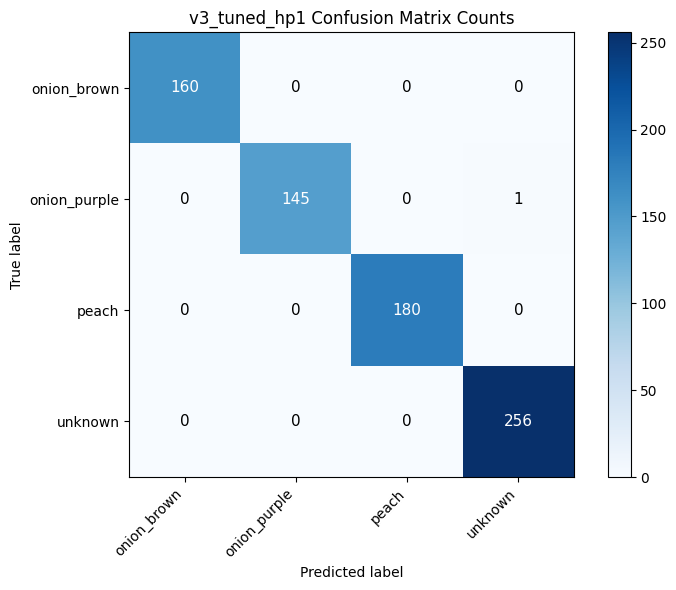

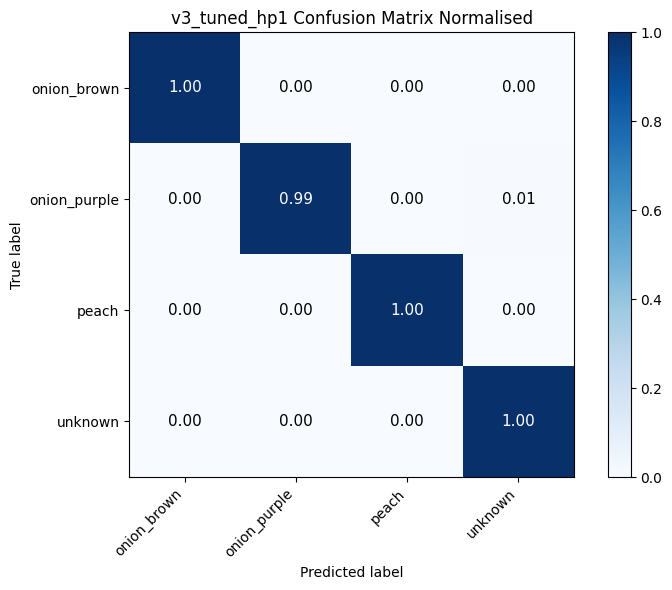

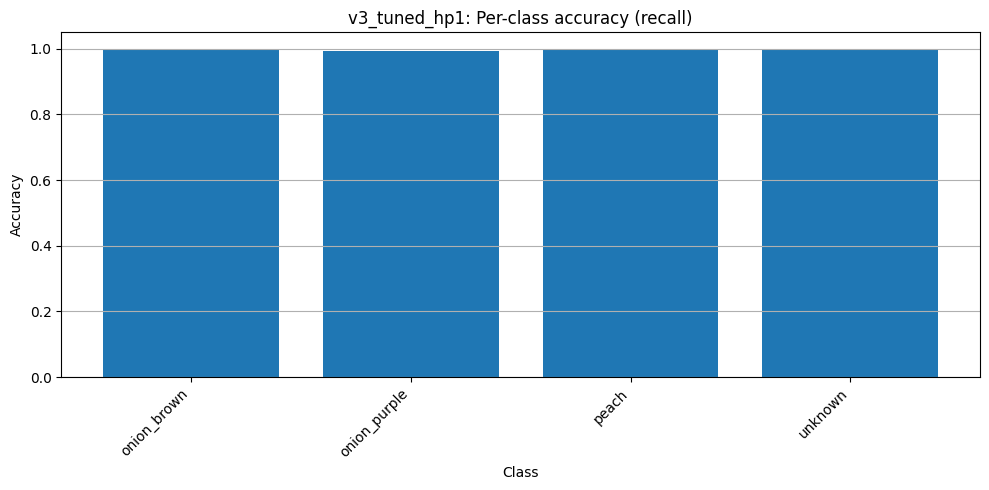

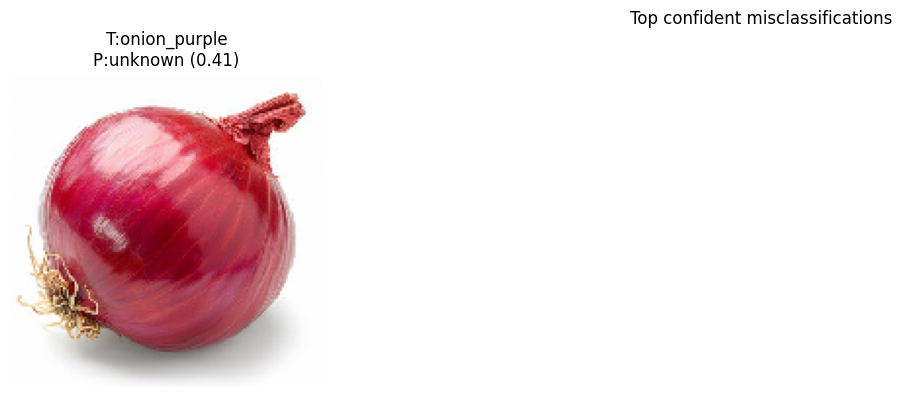

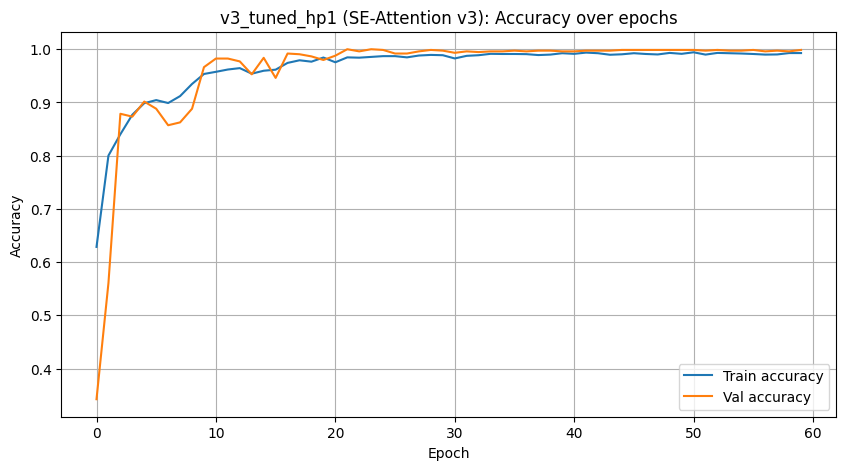

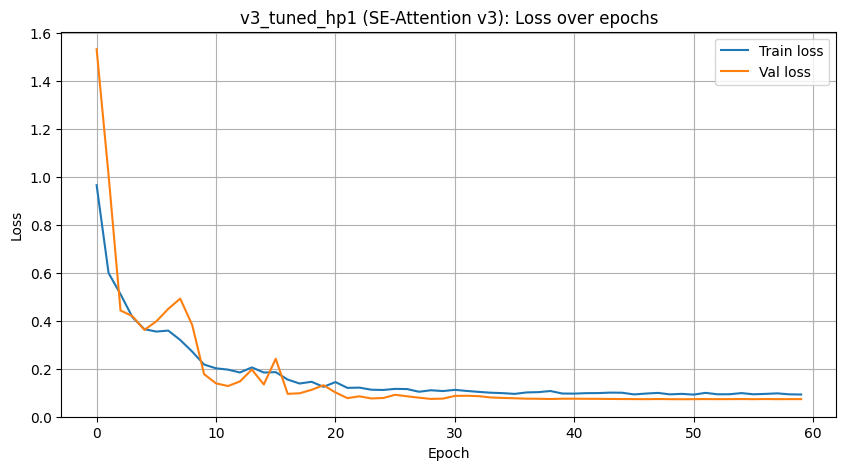

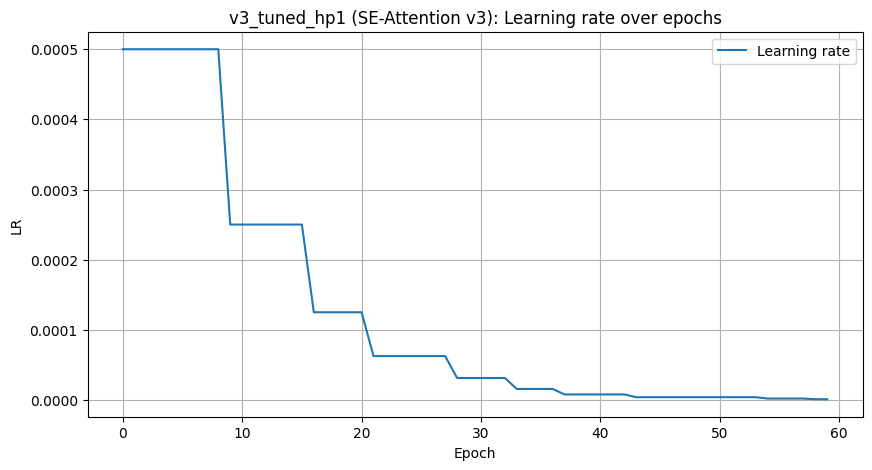

In [28]:
# ==========================================
# EVALUATION + VISUALISATION FOR v3_tuned_hp1 (SE-Attention v3, cross-entropy)
# Uses:
# - history_v3_tuned_hp1
# - val_gen_v3_tuned_hp1 / test_gen_v3_tuned_hp1
# - FINAL_PATH (../models/model_custom_cnn_v3_tuned_hp1_final.h5)
# ==========================================

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# ---------- helpers (same logic as our previous evals) ----------

def get_class_names_from_gen(gen):
    if hasattr(gen, "class_indices") and isinstance(gen.class_indices, dict):
        inv = {v: k for k, v in gen.class_indices.items()}
        return [inv[i] for i in range(len(inv))]
    return [f"class_{i}" for i in range(getattr(gen, "num_classes", 0) or 0)]

def collect_preds_and_labels(model, gen, steps=None):
    gen.reset()
    if steps is None:
        steps = int(np.ceil(gen.samples / gen.batch_size))

    y_prob = model.predict(gen, steps=steps, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    if hasattr(gen, "classes"):
        y_true = gen.classes[: len(y_pred)]
    else:
        y_true_list = []
        gen.reset()
        for _ in range(steps):
            _, y = next(gen)
            y_true_list.append(np.argmax(y, axis=1))
        y_true = np.concatenate(y_true_list, axis=0)[: len(y_pred)]

    return y_true, y_pred, y_prob

def plot_training_curves(history, title_prefix="v3_tuned_hp1"):
    h = history.history

    plt.figure(figsize=(10, 5))
    if "accuracy" in h: plt.plot(h["accuracy"], label="Train accuracy")
    if "val_accuracy" in h: plt.plot(h["val_accuracy"], label="Val accuracy")
    plt.title(f"{title_prefix}: Accuracy over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    if "loss" in h: plt.plot(h["loss"], label="Train loss")
    if "val_loss" in h: plt.plot(h["val_loss"], label="Val loss")
    plt.title(f"{title_prefix}: Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    # LR if logged (sometimes shows as "lr", "learning_rate", or "optimizer_learning_rate")
    lr_key = next((k for k in ["lr", "learning_rate", "optimizer_learning_rate"] if k in h), None)
    if lr_key:
        plt.figure(figsize=(10, 5))
        plt.plot(h[lr_key], label="Learning rate")
        plt.title(f"{title_prefix}: Learning rate over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("LR")
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", normalise=False):
    cm_plot = cm.astype(np.float64)
    if normalise:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        cm_plot = np.divide(cm_plot, row_sums, out=np.zeros_like(cm_plot), where=row_sums != 0)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm_plot, interpolation="nearest", cmap="Blues")
    plt.grid(False)
    plt.title(title + (" Normalised" if normalise else " Counts"))
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)

    fmt = ".2f" if normalise else ".0f"
    thresh = cm_plot.max() / 2.0 if cm_plot.size else 0.0
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = cm_plot[i, j]
            plt.text(
                j, i, format(val, fmt),
                ha="center", va="center",
                fontsize=11,
                color="white" if val > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

def per_class_accuracy(cm, class_names, title="Per-class accuracy (recall)"):
    row_sum = cm.sum(axis=1)
    diag = np.diag(cm)
    acc = np.divide(diag, row_sum, out=np.zeros_like(diag, dtype=float), where=row_sum != 0)

    plt.figure(figsize=(10, 5))
    plt.bar(class_names, acc)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

def show_top_misclassifications(gen, y_true, y_pred, y_prob, class_names, top_k=100):
    if not hasattr(gen, "filepaths"):
        print("Misclassification preview skipped, no filepaths in generator.")
        return

    wrong = np.where(y_true != y_pred)[0]
    if wrong.size == 0:
        print("No misclassifications found.")
        return

    conf = y_prob[wrong, y_pred[wrong]]
    order = wrong[np.argsort(-conf)][:top_k]

    cols = 4
    rows = int(np.ceil(len(order) / cols))
    plt.figure(figsize=(4 * cols, 4 * rows))
    plt.suptitle("Top confident misclassifications")

    for idx, i in enumerate(order, start=1):
        path = gen.filepaths[i]
        img = tf.keras.utils.load_img(path, target_size=gen.target_size)
        plt.subplot(rows, cols, idx)
        plt.imshow(img)
        t = class_names[y_true[i]]
        p = class_names[y_pred[i]]
        c = float(y_prob[i, y_pred[i]])
        plt.title(f"T:{t}\nP:{p} ({c:.2f})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---------- run evaluation on v3_tuned_hp1 generators + saved model ----------

# Pick split to evaluate:
eval_gen = val_gen_v3_tuned_hp1      # swap to test_gen_v3_tuned_hp1 for final test results
class_names = get_class_names_from_gen(eval_gen)

# Load FINAL model (cross-entropy, so no custom_objects needed)
model_v3_tuned_hp1_final = tf.keras.models.load_model(FINAL_PATH)

y_true, y_pred, y_prob = collect_preds_and_labels(model_v3_tuned_hp1_final, eval_gen)
cm = confusion_matrix(y_true, y_pred)

print("\n=== v3_tuned_hp1 FINAL MODEL RESULTS ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

plot_confusion_matrix(cm, class_names, title="v3_tuned_hp1 Confusion Matrix", normalise=False)
plot_confusion_matrix(cm, class_names, title="v3_tuned_hp1 Confusion Matrix", normalise=True)
per_class_accuracy(cm, class_names, title="v3_tuned_hp1: Per-class accuracy (recall)")
show_top_misclassifications(eval_gen, y_true, y_pred, y_prob, class_names, top_k=100)

# Training curves from the v3_tuned_hp1 training run
plot_training_curves(history_v3_tuned_hp1, title_prefix="v3_tuned_hp1 (SE-Attention v3)")


## 11.2. Final Model Training (Optimised Configuration – v2 Hyperparameter Tuning)

In this phase, the model is retrained using the **best-performing hyperparameter configuration obtained from the v2 Hyperparameter Tuning process**, which represents an improved and more targeted optimisation strategy compared to v1. The updated hyperparameters are applied directly in the following code cell, while the underlying model architecture remains unchanged.

This step evaluates whether the refined v2 tuning results translate into improved convergence behaviour and generalisation performance during full-length final training.



In [22]:
# ==========================================
# CUSTOM CNN v3_TUNED_HP2: SE-Attention v3 Architecture
# Hyperparameters:
# FIXED ARCH: IMG=176x176, batch=16, filters=[48, 96, 192, 384], LR=0.0001
# TUNED:      dense=384, dropout=0.3, L2=0.001
# Loss: categorical_crossentropy
# ==========================================

K.clear_session()

# ==========================================
# 1. HYPERPARAMETERS & CONSTANTS (v3_tuned_hp2)
# ==========================================
IMG_SIZE_V3_TUNED_HP2 = (176, 176)
BATCH_SIZE_V3_TUNED_HP2 = 16

FILTERS_V3_TUNED_HP2 = [48, 96, 192, 384]
DENSE_UNITS_V3_TUNED_HP2 = 384
DROPOUT_HEAD_V3_TUNED_HP2 = 0.3
L2_REG_V3_TUNED_HP2 = 0.001
LR_V3_TUNED_HP2 = 0.0001

MODEL_TAG = "v3_tuned_hp2"

# ==========================================
# 2. DATA GENERATORS (reuse our tuned aug)
# ==========================================
AUG_V3_TUNED_HP2 = dict(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_datagen_v3_tuned_hp2 = ImageDataGenerator(
    rescale=1./255,
    **AUG_V3_TUNED_HP2
)

val_datagen_v3_tuned_hp2 = ImageDataGenerator(rescale=1./255)
test_datagen_v3_tuned_hp2 = ImageDataGenerator(rescale=1./255)

print(f"--- Loading {MODEL_TAG} Training Data (176x176, batch=16) ---")
train_gen_v3_tuned_hp2 = train_datagen_v3_tuned_hp2.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_V3_TUNED_HP2,
    batch_size=BATCH_SIZE_V3_TUNED_HP2,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

print(f"\n--- Loading {MODEL_TAG} Validation Data (176x176, batch=16) ---")
val_gen_v3_tuned_hp2 = val_datagen_v3_tuned_hp2.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE_V3_TUNED_HP2,
    batch_size=BATCH_SIZE_V3_TUNED_HP2,
    class_mode="categorical",
    shuffle=False
)

print(f"\n--- Loading {MODEL_TAG} Test Data (176x176, batch=16) ---")
test_gen_v3_tuned_hp2 = test_datagen_v3_tuned_hp2.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE_V3_TUNED_HP2,
    batch_size=BATCH_SIZE_V3_TUNED_HP2,
    class_mode="categorical",
    shuffle=False
)

# ==========================================
# 3. HELPER: SE BLOCK
# ==========================================
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return Multiply()([input_tensor, se])

# ==========================================
# 4. MODEL: v3 SE-ATTENTION ARCHITECTURE (with HP2)
# ==========================================
def build_attention_cnn_v3_tuned_hp2():
    print(
        f"\n--- Building Custom CNN {MODEL_TAG} (SE-Attention v3) ---\n"
        f"IMG=176, batch=16, filters={FILTERS_V3_TUNED_HP2}, dense={DENSE_UNITS_V3_TUNED_HP2}, "
        f"drop={DROPOUT_HEAD_V3_TUNED_HP2}, l2={L2_REG_V3_TUNED_HP2}, lr={LR_V3_TUNED_HP2}"
    )

    f1, f2, f3, f4 = FILTERS_V3_TUNED_HP2
    inputs = Input(shape=IMG_SIZE_V3_TUNED_HP2 + (3,))

    # --- Block 1 (f1) ---
    x = Conv2D(f1, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP2))(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv2D(f1, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP2))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)

    # --- Block 2 (f2) ---
    x = Conv2D(f2, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP2))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv2D(f2, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP2))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.2)(x)

    # --- Block 3 (f3) ---
    x = Conv2D(f3, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP2))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv2D(f3, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP2))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.3)(x)

    # --- Block 4 (f4) ---
    x = Conv2D(f4, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP2))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.3)(x)

    # --- Head (Dense 384, Drop 0.3) ---
    x = GlobalAveragePooling2D()(x)

    x = Dense(
        DENSE_UNITS_V3_TUNED_HP2,
        use_bias=False,
        kernel_regularizer=l2(L2_REG_V3_TUNED_HP2)
    )(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(DROPOUT_HEAD_V3_TUNED_HP2)(x)

    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs, name=f"model_custom_cnn_{MODEL_TAG}")

    model.compile(
        optimizer=Adam(learning_rate=LR_V3_TUNED_HP2),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ==========================================
# 5. CLASS WEIGHTS (same pattern)
# ==========================================
try:
    y_train_labels = train_gen_v3_tuned_hp2.classes
    class_weights_array = class_weight.compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train_labels),
        y=y_train_labels
    )
    class_weights_dict = dict(enumerate(class_weights_array))
    print(f"Computed Class Weights ({MODEL_TAG}): {class_weights_dict}")
except Exception as e:
    print("Could not compute class weights automatically. Using None.")
    class_weights_dict = None

# ==========================================
# 6. BUILD MODEL
# ==========================================
model_v3_tuned_hp2 = build_attention_cnn_v3_tuned_hp2()

# ==========================================
# 7. CALLBACKS (separate names)
# ==========================================
os.makedirs("../models", exist_ok=True)

BEST_PATH  = f"../models/model_custom_cnn_{MODEL_TAG}_best.h5"
FINAL_PATH = f"../models/model_custom_cnn_{MODEL_TAG}_final.h5"

v3_tuned_hp2_callbacks = [
    ModelCheckpoint(
        BEST_PATH,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        mode="min",
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
]

# ==========================================
# 8. TRAIN
# ==========================================
print(f"Starting training for {MODEL_TAG} (SE-Attention v3 architecture)...")
start_time = time.time()

history_v3_tuned_hp2 = model_v3_tuned_hp2.fit(
    train_gen_v3_tuned_hp2,
    validation_data=val_gen_v3_tuned_hp2,
    steps_per_epoch=len(train_gen_v3_tuned_hp2),
    validation_steps=len(val_gen_v3_tuned_hp2),
    epochs=100,
    callbacks=v3_tuned_hp2_callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

duration_v3_tuned_hp2 = time.time() - start_time

# ==========================================
# 9. SAVE BEST + FINAL
# ==========================================
best_model_v3_tuned_hp2 = tf.keras.models.load_model(BEST_PATH)
best_model_v3_tuned_hp2.save(FINAL_PATH)

print(f"Model {MODEL_TAG} saved. Training time: {duration_v3_tuned_hp2:.2f}s")
print(f"Best:  {BEST_PATH}")
print(f"Final: {FINAL_PATH}")


--- Loading v3_tuned_hp2 Training Data (176x176, batch=16) ---
Found 3462 images belonging to 4 classes.

--- Loading v3_tuned_hp2 Validation Data (176x176, batch=16) ---
Found 742 images belonging to 4 classes.

--- Loading v3_tuned_hp2 Test Data (176x176, batch=16) ---
Found 742 images belonging to 4 classes.
Computed Class Weights (v3_tuned_hp2): {0: 1.1555407209612818, 1: 1.2727941176470587, 2: 1.0303571428571427, 3: 0.7254819782062029}

--- Building Custom CNN v3_tuned_hp2 (SE-Attention v3) ---
IMG=176, batch=16, filters=[48, 96, 192, 384], dense=384, drop=0.3, l2=0.001, lr=0.0001
Starting training for v3_tuned_hp2 (SE-Attention v3 architecture)...
Epoch 1/100
217/217 [==============================] - ETA: 0s - loss: 2.0930 - accuracy: 0.6020
Epoch 1: val_loss improved from inf to 2.62125, saving model to ../models\model_custom_cnn_v3_tuned_hp2_best.h5
217/217 [==============================] - 33s 126ms/step - loss: 2.0930 - accuracy: 0.6020 - val_loss: 2.6212 - val_accuracy: 0.

47/47 [==============================] - 2s 23ms/step

=== FINAL MODEL (v3_tuned_hp2) RESULTS ===
              precision    recall  f1-score   support

 onion_brown     1.0000    1.0000    1.0000       160
onion_purple     1.0000    1.0000    1.0000       146
       peach     1.0000    0.9944    0.9972       180
     unknown     0.9961    1.0000    0.9981       256

    accuracy                         0.9987       742
   macro avg     0.9990    0.9986    0.9988       742
weighted avg     0.9987    0.9987    0.9987       742



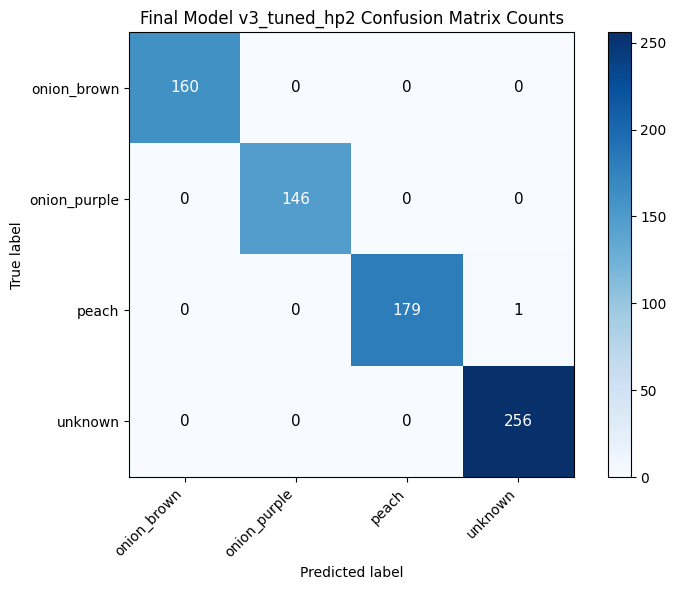

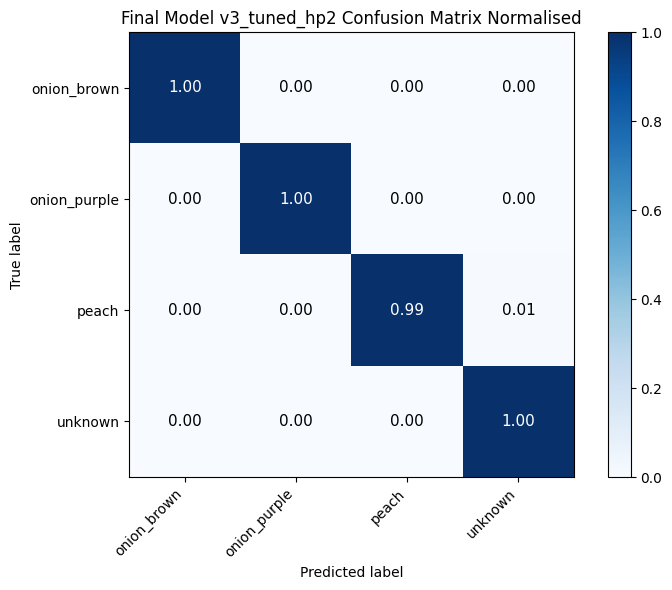

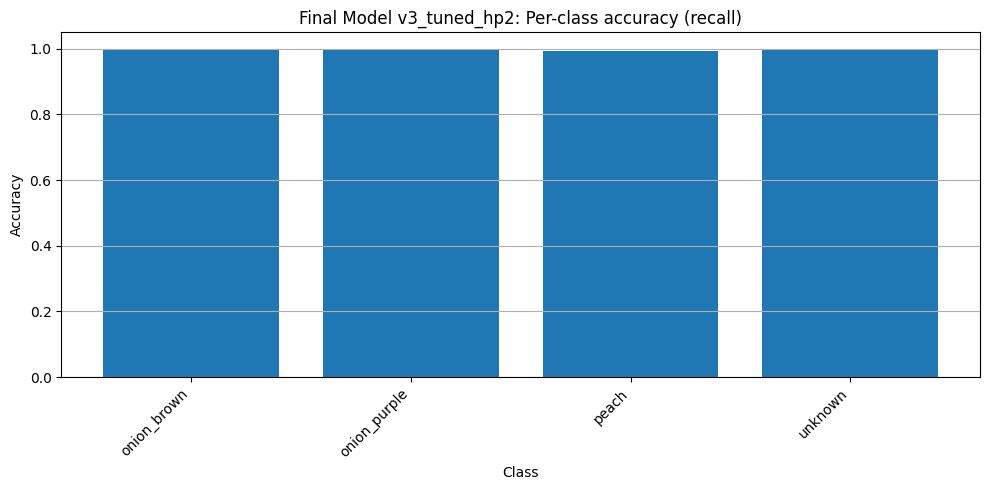

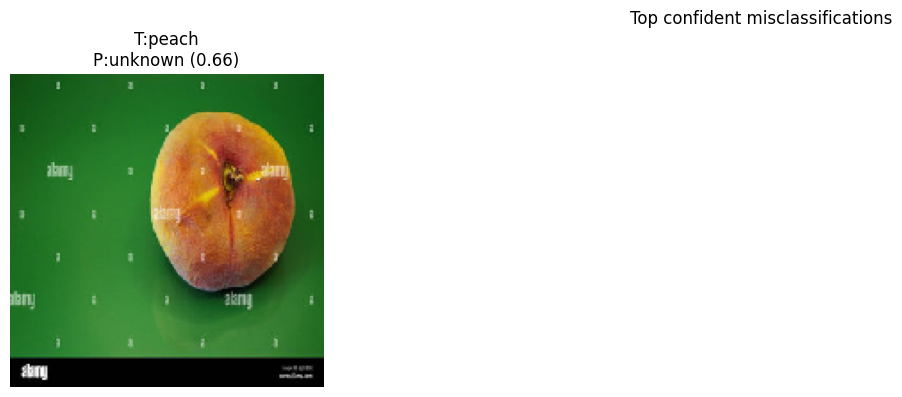

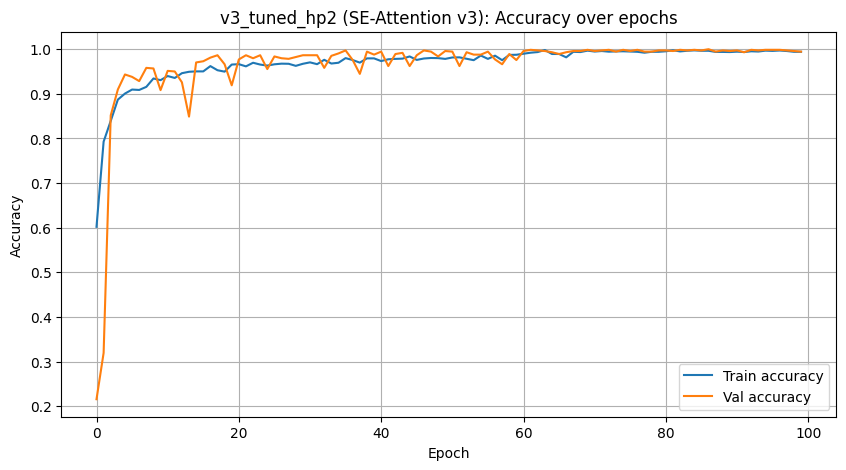

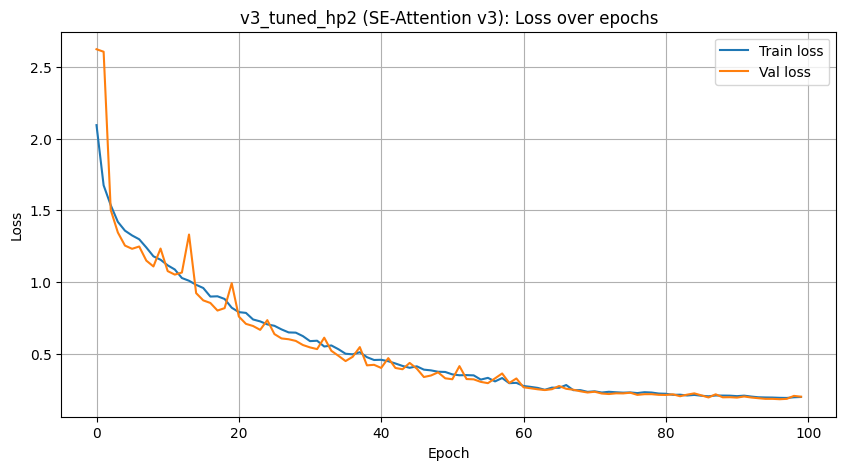

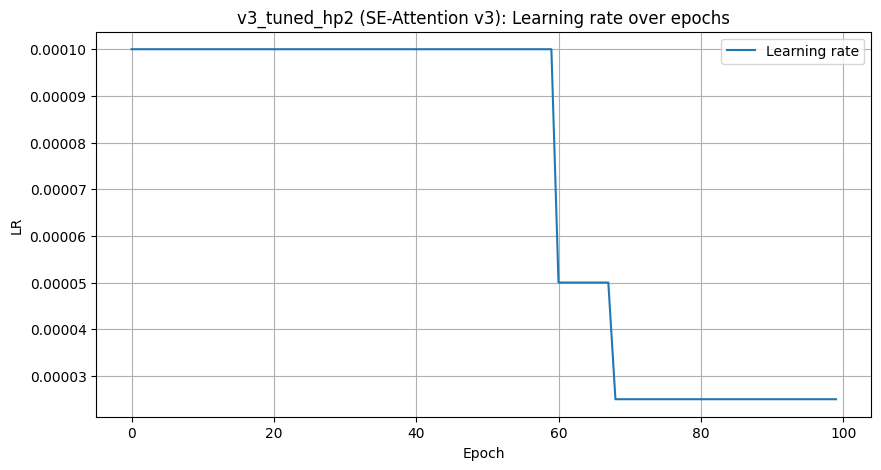

In [ ]:
# ---------- helpers (same logic as our previous evals) ----------
def get_class_names_from_gen(gen):
    if hasattr(gen, "class_indices") and isinstance(gen.class_indices, dict):
        inv = {v: k for k, v in gen.class_indices.items()}
        return [inv[i] for i in range(len(inv))]
    return [f"class_{i}" for i in range(getattr(gen, "num_classes", 0) or 0)]

def collect_preds_and_labels(model, gen, steps=None):
    gen.reset()
    if steps is None:
        steps = int(np.ceil(gen.samples / gen.batch_size))

    y_prob = model.predict(gen, steps=steps, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    if hasattr(gen, "classes"):
        y_true = gen.classes[: len(y_pred)]
    else:
        y_true_list = []
        gen.reset()
        for _ in range(steps):
            _, y = next(gen)
            y_true_list.append(np.argmax(y, axis=1))
        y_true = np.concatenate(y_true_list, axis=0)[: len(y_pred)]

    return y_true, y_pred, y_prob

def plot_training_curves(history, title_prefix="v3_tuned_hp2"):
    h = history.history

    plt.figure(figsize=(10, 5))
    if "accuracy" in h:
        plt.plot(h["accuracy"], label="Train accuracy")
    if "val_accuracy" in h:
        plt.plot(h["val_accuracy"], label="Val accuracy")
    plt.title(f"{title_prefix}: Accuracy over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    if "loss" in h:
        plt.plot(h["loss"], label="Train loss")
    if "val_loss" in h:
        plt.plot(h["val_loss"], label="Val loss")
    plt.title(f"{title_prefix}: Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    # LR if logged
    lr_key = next((k for k in ["lr", "learning_rate"] if k in h), None)
    if lr_key:
        plt.figure(figsize=(10, 5))
        plt.plot(h[lr_key], label="Learning rate")
        plt.title(f"{title_prefix}: Learning rate over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("LR")
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", normalise=False):
    cm_plot = cm.astype(np.float64)
    if normalise:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        cm_plot = np.divide(cm_plot, row_sums, out=np.zeros_like(cm_plot), where=row_sums != 0)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm_plot, interpolation="nearest", cmap="Blues")
    plt.grid(False)
    plt.title(title + (" Normalised" if normalise else " Counts"))
    plt.colorbar()

    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)

    fmt = ".2f" if normalise else ".0f"
    thresh = cm_plot.max() / 2.0 if cm_plot.size else 0.0
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = cm_plot[i, j]
            plt.text(
                j, i, format(val, fmt),
                ha="center", va="center", fontsize=11,
                color="white" if val > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

def per_class_accuracy(cm, class_names, title="Per-class accuracy (recall)"):
    row_sum = cm.sum(axis=1)
    diag = np.diag(cm)
    acc = np.divide(diag, row_sum, out=np.zeros_like(diag, dtype=float), where=row_sum != 0)

    plt.figure(figsize=(10, 5))
    plt.bar(class_names, acc)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

def show_top_misclassifications(gen, y_true, y_pred, y_prob, class_names, top_k=100):
    if not hasattr(gen, "filepaths"):
        print("Misclassification preview skipped, no filepaths in generator.")
        return

    wrong = np.where(y_true != y_pred)[0]
    if wrong.size == 0:
        print("No misclassifications found.")
        return

    conf = y_prob[wrong, y_pred[wrong]]
    order = wrong[np.argsort(-conf)][:top_k]

    cols = 4
    rows = int(np.ceil(len(order) / cols))
    plt.figure(figsize=(4 * cols, 4 * rows))
    plt.suptitle("Top confident misclassifications")

    for idx, i in enumerate(order, start=1):
        path = gen.filepaths[i]
        img = tf.keras.utils.load_img(path, target_size=gen.target_size)

        plt.subplot(rows, cols, idx)
        plt.imshow(img)
        t = class_names[y_true[i]]
        p = class_names[y_pred[i]]
        c = float(y_prob[i, y_pred[i]])
        plt.title(f"T:{t}\nP:{p} ({c:.2f})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# ==========================================
# RUN EVALUATION (v3_tuned_hp2)
# ==========================================

eval_gen = val_gen_v3_tuned_hp2

class_names = get_class_names_from_gen(eval_gen)

# Load FINAL model (categorical_crossentropy, no custom_objects needed)
# Uses our training code's FINAL_PATH, which should be:
# FINAL_PATH = "../models/model_custom_cnn_v3_tuned_hp2_final.h5"
model_final_v3_tuned_hp2 = tf.keras.models.load_model(FINAL_PATH)

y_true, y_pred, y_prob = collect_preds_and_labels(model_final_v3_tuned_hp2, eval_gen)
cm = confusion_matrix(y_true, y_pred)

print(f"\n=== FINAL MODEL ({MODEL_TAG}) RESULTS ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

plot_confusion_matrix(cm, class_names, title=f"Final Model {MODEL_TAG} Confusion Matrix", normalise=False)
plot_confusion_matrix(cm, class_names, title=f"Final Model {MODEL_TAG} Confusion Matrix", normalise=True)
per_class_accuracy(cm, class_names, title=f"Final Model {MODEL_TAG}: Per-class accuracy (recall)")
show_top_misclassifications(eval_gen, y_true, y_pred, y_prob, class_names, top_k=100)

# Training curves from the training run
plot_training_curves(history_v3_tuned_hp2, title_prefix=f"{MODEL_TAG} (SE-Attention v3)")


## 12. Test-Set Evaluation of v3 Variants

This evaluation compares **three variants of the same v3 SE-Attention architecture**. The model design and loss (**categorical cross-entropy**, not focal loss) are the same, the main differences are the **hyperparameter sets** used and the **test generator** each model is evaluated on.

### Models Compared

* **v3 (untuned, SE-Attention)**
  Saved as `model_custom_cnn_v3_final.h5`, evaluated on `test_gen_base`.

* **v3 tuned (HP1)**
  Saved as `model_custom_cnn_v3_tuned_hp1_final.h5`, evaluated on `test_gen_v3_tuned_hp1`.

* **v3 tuned (HP2)**
  Saved as `model_custom_cnn_v3_tuned_hp2_final.h5`, evaluated on `test_gen_v3_tuned_hp2`.

All three are final models and are evaluated **only on their respective test sets**. Validation data is not used for comparison at this stage.

### Evaluation Protocol

* **Metrics reported:**
  **Accuracy**, **Balanced Accuracy**, **Macro F1**, **Weighted F1**, **Cohen’s Kappa**, **per-class Precision/Recall/F1**, and **inference speed (ms/image)**.

* **Fair comparison across generators:**
  Class index mappings are **aligned by class names**, then remapped into a single **reference ordering** (taken from `test_gen_base`) before computing metrics.

* **Primary selection criteria:**
  **Balanced Accuracy** and **Macro F1** are prioritised, as they are more robust than raw accuracy when class frequencies are uneven.

### Purpose and Justification

This comparison isolates the **impact of hyperparameter choices** while holding the v3 architecture constant. Therefore, performance differences on the test set are attributed primarily to **hyperparameter configuration**, not changes in the network design.

The top-performing variant on the test set is the strongest candidate for deployment or for use as the baseline in further optimisation.


Reference class order (from test_gen_base): ['onion_brown', 'onion_purple', 'peach', 'unknown']

=== V3 VARIANTS: TEST METRICS (sorted by Balanced Acc, then Macro F1) ===



Model           Evaluated On   Params  \
1              V3 tuned (HP1)  test_gen_v3_tuned_hp1   676548   
2              V3 tuned (HP2)  test_gen_v3_tuned_hp2  1486900   
0  V3 (untuned, SE-Attention)          test_gen_base   662756   

   Accuracy (test)  Balanced Acc (test)  F1 Macro (test)  F1 Weighted (test)  \
1         0.994609             0.993439         0.994375            0.994600   
2         0.993261             0.992462         0.993193            0.993253   
0         0.991914             0.991322         0.992223            0.991910   

   Kappa (test)  Pred Time (s)    ms/img  Train Time (s)  \
1      0.992679       1.245425  1.678471     1149.902945   
2      0.990850       1.424282  1.919517     2323.047521   
0      0.989019       1.410342  1.900731      687.952584   

   Best Epoch (history)  Hist Best Val Acc  Hist Final Val Acc  
1                    22           1.000000            0.998652  
2                    87           1.000000            0.994609  
0                    29           0.998652            0.995957


=== V3 VARIANTS: PER-CLASS TEST METRICS (ref order from test_gen_base) ===



Model           Evaluated On   Class (ref)  \
0   V3 (untuned, SE-Attention)          test_gen_base   onion_brown   
1   V3 (untuned, SE-Attention)          test_gen_base  onion_purple   
2   V3 (untuned, SE-Attention)          test_gen_base         peach   
3   V3 (untuned, SE-Attention)          test_gen_base       unknown   
4               V3 tuned (HP1)  test_gen_v3_tuned_hp1   onion_brown   
5               V3 tuned (HP1)  test_gen_v3_tuned_hp1  onion_purple   
6               V3 tuned (HP1)  test_gen_v3_tuned_hp1         peach   
7               V3 tuned (HP1)  test_gen_v3_tuned_hp1       unknown   
8               V3 tuned (HP2)  test_gen_v3_tuned_hp2   onion_brown   
9               V3 tuned (HP2)  test_gen_v3_tuned_hp2  onion_purple   
10              V3 tuned (HP2)  test_gen_v3_tuned_hp2         peach   
11              V3 tuned (HP2)  test_gen_v3_tuned_hp2       unknown   

    Precision    Recall        F1  Support  
0    0.993789  0.993789  0.993789      161  
1    1.000000  0.979310  0.989547      145  
2    0.994475  1.000000  0.997230      180  
3    0.984496  0.992188  0.988327      256  
4    1.000000  1.000000  1.000000      161  
5    0.993007  0.979310  0.986111      145  
6    1.000000  0.994444  0.997214      180  
7    0.988417  1.000000  0.994175      256  
8    1.000000  1.000000  1.000000      161  
9    0.993007  0.979310  0.986111      145  
10   0.994444  0.994444  0.994444      180  
11   0.988372  0.996094  0.992218      256

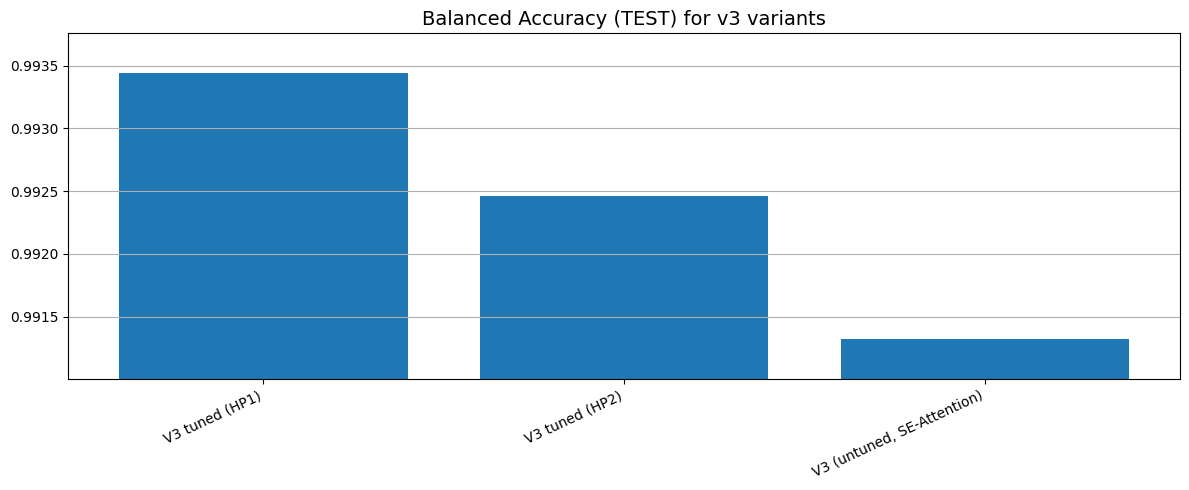

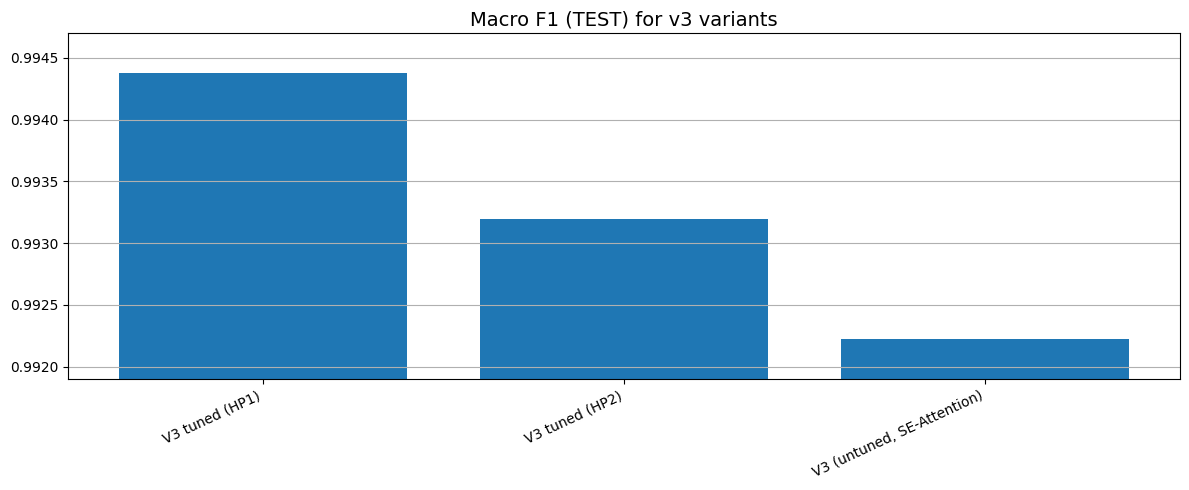

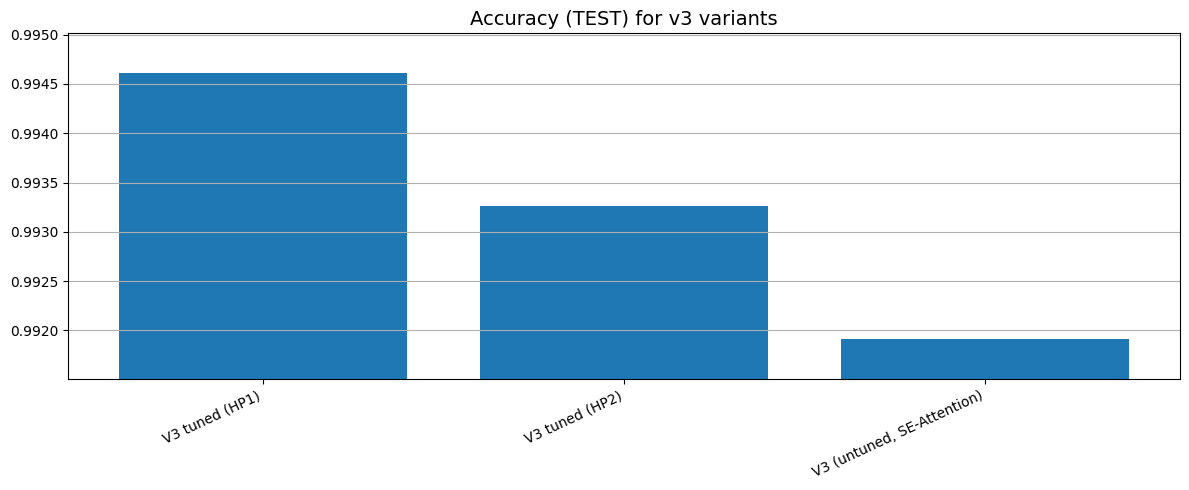

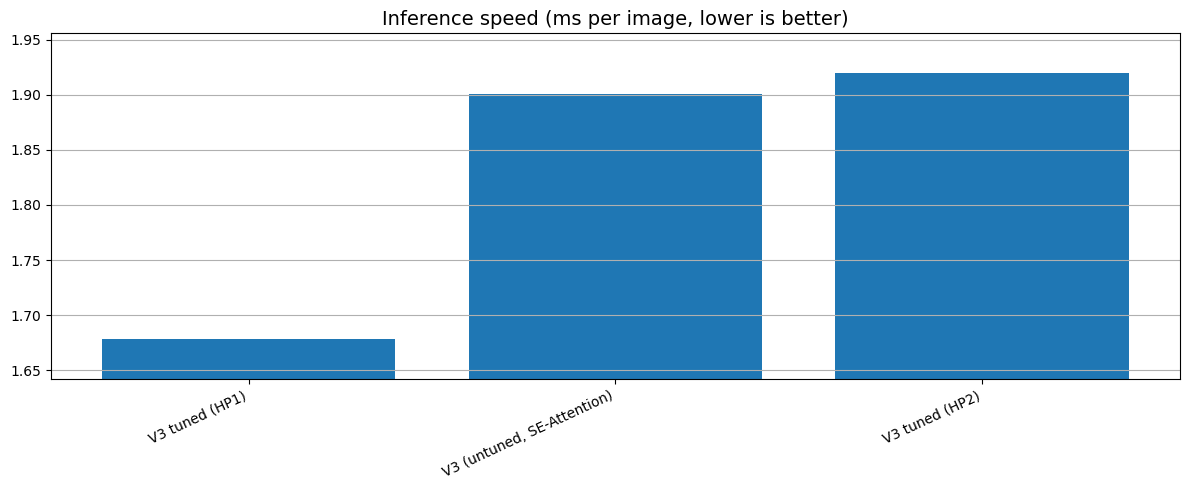

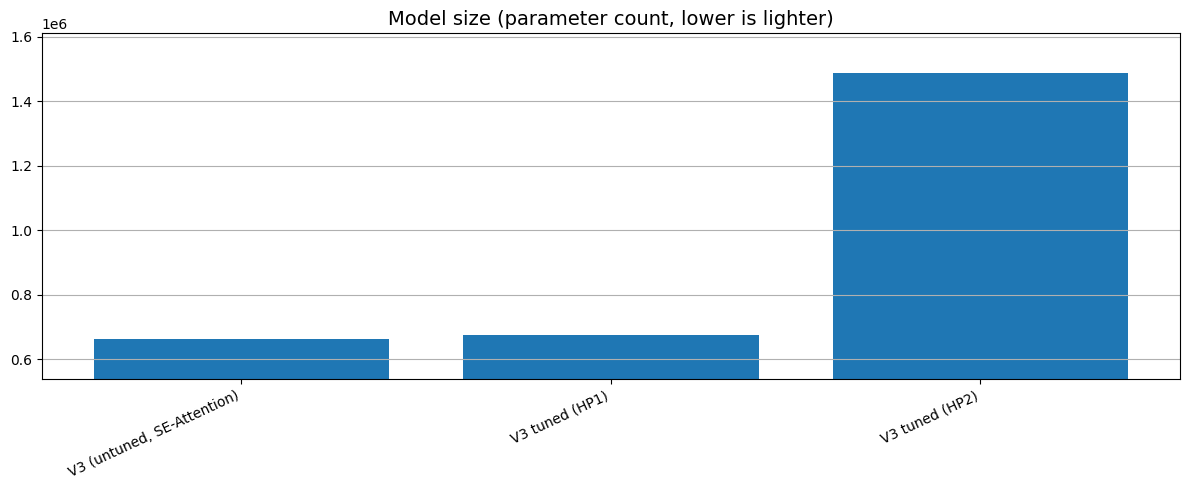

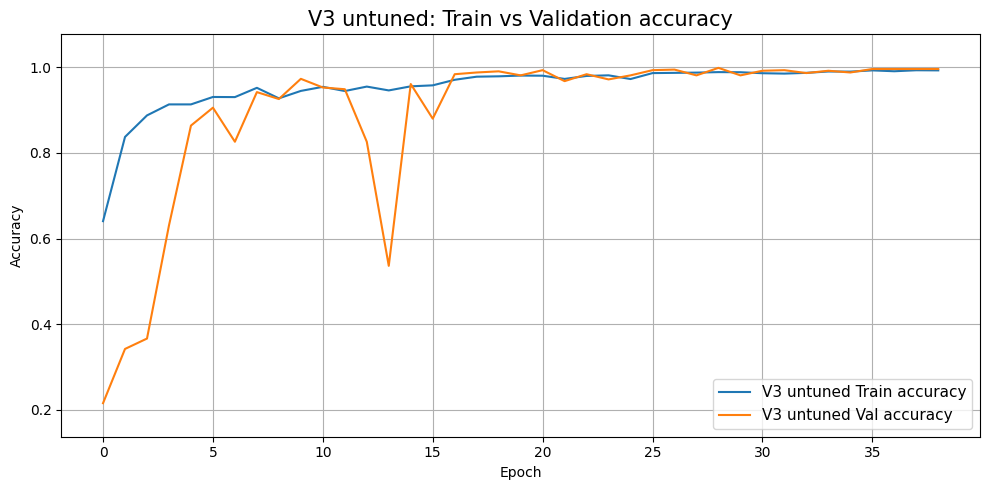

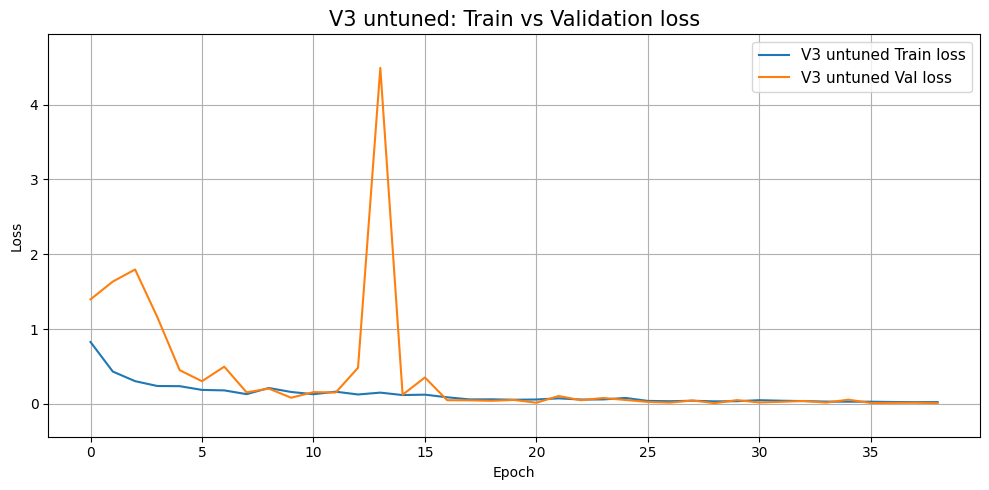

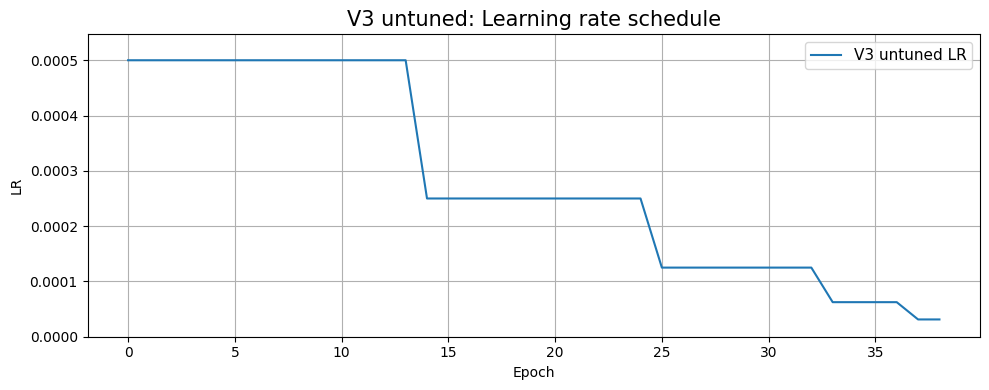

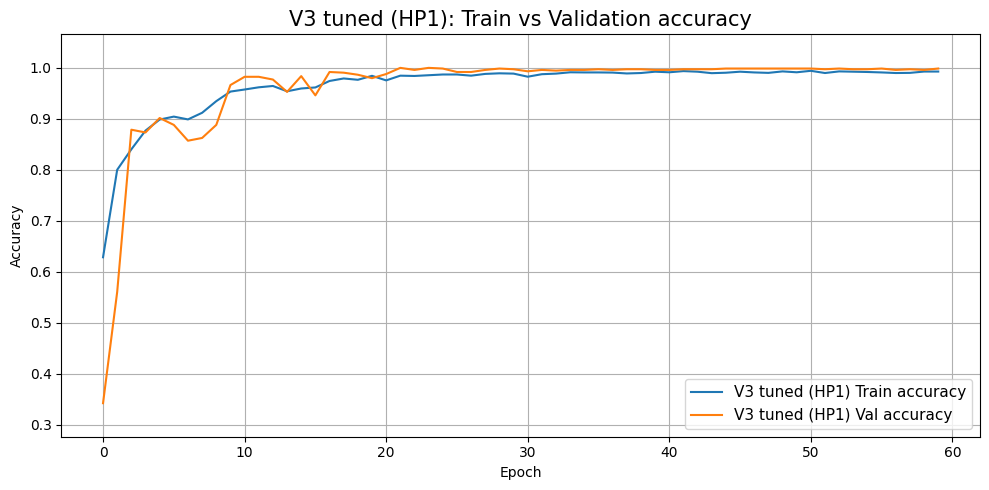

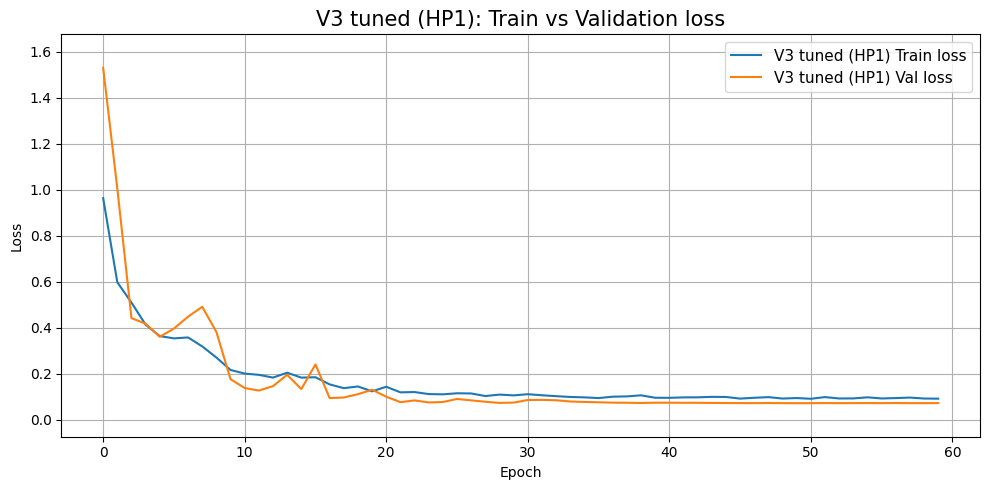

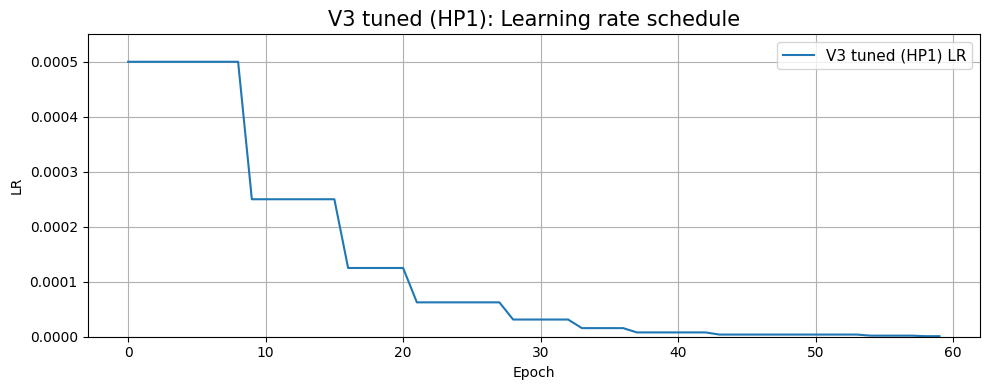

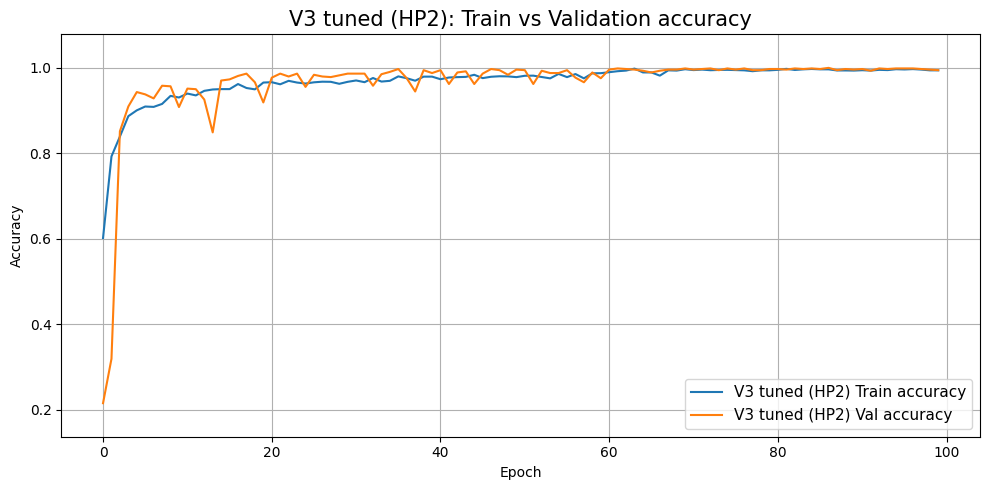

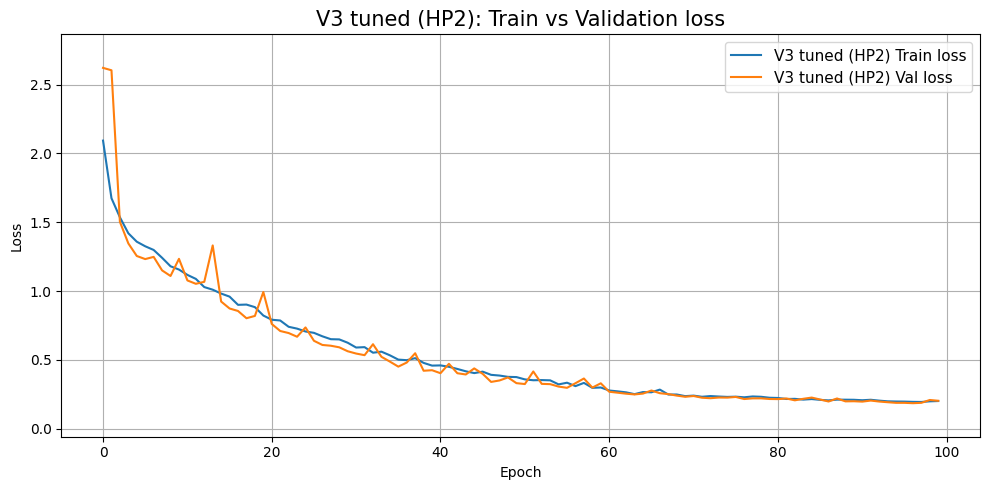

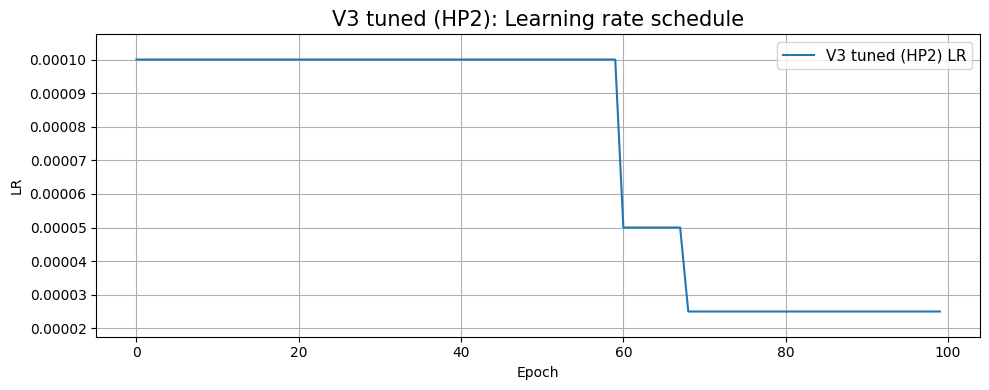


=== V3 VARIANTS: TEST SUMMARY (ALL MODELS, sorted by Balanced Acc then Macro F1) ===

Model: V3 tuned (HP1)
  Balanced Acc (test): 0.9934 | Macro F1 (test): 0.9944 | Acc (test): 0.9946 | Kappa (test): 0.9927
  Params: 676,548 | Speed: 1.678 ms/img
  Train Time (s): 1149.90
  Best Epoch (history): 22 | Hist Best Val Acc: 1.0000 | Hist Final Val Acc: 0.9987

Model: V3 tuned (HP2)
  Balanced Acc (test): 0.9925 | Macro F1 (test): 0.9932 | Acc (test): 0.9933 | Kappa (test): 0.9908
  Params: 1,486,900 | Speed: 1.920 ms/img
  Train Time (s): 2323.05
  Best Epoch (history): 87 | Hist Best Val Acc: 1.0000 | Hist Final Val Acc: 0.9946

Model: V3 (untuned, SE-Attention)
  Balanced Acc (test): 0.9913 | Macro F1 (test): 0.9922 | Acc (test): 0.9919 | Kappa (test): 0.9890
  Params: 662,756 | Speed: 1.901 ms/img
  Train Time (s): 687.95
  Best Epoch (history): 29 | Hist Best Val Acc: 0.9987 | Hist Final Val Acc: 0.9960

=== WINNER (by Balanced Acc, then Macro F1) ===
Model: V3 tuned (HP1)
Balanced Ac

In [29]:
# =========================================================
# 0) Custom objects
#    These 3 models are v3-style (categorical_crossentropy), so NO focal-loss custom objects.
#    Also, prediction does not need compile, so we load with compile=False for maximum safety.
# =========================================================
CUSTOM_OBJECTS_V3 = {}  # empty on purpose

def load_model_safely(path):
    # compile=False avoids issues if optimiser config differs across saves
    return tf.keras.models.load_model(path, custom_objects=CUSTOM_OBJECTS_V3, compile=False)

# =========================================================
# 1) Helpers
# =========================================================
def get_class_names_from_gen(gen):
    if hasattr(gen, "class_indices") and isinstance(gen.class_indices, dict):
        inv = {v: k for k, v in gen.class_indices.items()}
        return [inv[i] for i in range(len(inv))]
    return [f"class_{i}" for i in range(getattr(gen, "num_classes", 0) or 0)]

def steps_ceil(gen):
    return int(np.ceil(gen.samples / gen.batch_size))

def collect_preds_and_labels(model, gen, steps=None):
    gen.reset()
    if steps is None:
        steps = steps_ceil(gen)

    t0 = time.time()
    y_prob = model.predict(gen, steps=steps, verbose=0)
    pred_time = time.time() - t0

    y_pred = np.argmax(y_prob, axis=1a

    if hasattr(gen, "classes"):
        y_true = gen.classes[:len(y_pred)]
    else:
        y_true_list = []
        gen.reset()
        for _ in range(steps):
            _, y = next(gen)
            y_true_list.append(np.argmax(y, axis=1))
        y_true = np.concatenate(y_true_list, axis=0)[:len(y_pred)]

    return y_true, y_pred, y_prob, pred_time

def best_epoch_from_history(history):
    if history is None:
        return None
    h = history.history
    if "val_accuracy" in h:
        return int(np.argmax(h["val_accuracy"]) + 1)
    if "val_loss" in h:
        return int(np.argmin(h["val_loss"]) + 1)
    return None

def best_val_acc_from_history(history):
    if history is None:
        return None
    h = history.history
    if "val_accuracy" in h:
        return float(np.max(h["val_accuracy"]))
    return None

def final_val_acc_from_history(history):
    if history is None:
        return None
    h = history.history
    if "val_accuracy" in h:
        return float(h["val_accuracy"][-1])
    return None

def remap_indices_to_ref(y_idx, src_names, ref_names):
    """
    Remap class indices from src ordering to ref ordering using class names.
    Keeps metrics comparable even if generators were created separately.
    """
    src_to_ref = {
        src_i: ref_names.index(src_name)
        for src_i, src_name in enumerate(src_names)
        if src_name in ref_names
    }
    return np.array([src_to_ref.get(int(i), int(i)) for i in y_idx], dtype=np.int64)

# =========================================================
# 2) Compare THESE 3 v3 variants (our codes above):
#      - v3_untuned      -> ../models/model_custom_cnn_v3_final.h5      , eval on test_gen_base
#      - v3_tuned_hp1    -> ../models/model_custom_cnn_v3_tuned_hp1_final.h5 , eval on test_gen_v3_tuned_hp1
#      - v3_tuned_hp2    -> ../models/model_custom_cnn_v3_tuned_hp2_final.h5 , eval on test_gen_v3_tuned_hp2
# =========================================================

# Reference order for reporting per-class metrics
# (use base generator mapping as the reference)
ref_gen = test_gen_base
REF_CLASS_NAMES = get_class_names_from_gen(ref_gen)
print("Reference class order (from test_gen_base):", REF_CLASS_NAMES)

models_to_compare = [
    ("V3 (untuned, SE-Attention)", "../models/model_custom_cnn_v3_final.h5",            test_gen_base,           "test_gen_base"),
    ("V3 tuned (HP1)",             "../models/model_custom_cnn_v3_tuned_hp1_final.h5", test_gen_v3_tuned_hp1,   "test_gen_v3_tuned_hp1"),
    ("V3 tuned (HP2)",             "../models/model_custom_cnn_v3_tuned_hp2_final.h5", test_gen_v3_tuned_hp2,   "test_gen_v3_tuned_hp2"),
]

# training info if histories exist in this session
TRAIN_INFO = {
    "V3_UNTUNED": {"history": globals().get("history_v3", None),              "train_time_s": globals().get("duration_v3", None)},
    "V3_HP1":     {"history": globals().get("history_v3_tuned_hp1", None),    "train_time_s": globals().get("duration_v3_tuned_hp1", None)},
    "V3_HP2":     {"history": globals().get("history_v3_tuned_hp2", None),    "train_time_s": globals().get("duration_v3_tuned_hp2", None)},
}

def pick_train_info(model_tag):
    if "HP1" in model_tag:
        return TRAIN_INFO["V3_HP1"]["history"], TRAIN_INFO["V3_HP1"]["train_time_s"]
    if "HP2" in model_tag:
        return TRAIN_INFO["V3_HP2"]["history"], TRAIN_INFO["V3_HP2"]["train_time_s"]
    return TRAIN_INFO["V3_UNTUNED"]["history"], TRAIN_INFO["V3_UNTUNED"]["train_time_s"]

# =========================================================
# 3) Run TEST evaluation
# =========================================================
rows = []
per_class_rows = []

for tag, path, eval_gen, eval_gen_name in models_to_compare:
    if not os.path.exists(path):
        print(f"Missing file, skipping: {path}")
        continue

    model = load_model_safely(path)
    params = model.count_params()

    src_class_names = get_class_names_from_gen(eval_gen)

    y_true, y_pred, y_prob, pred_time = collect_preds_and_labels(model, eval_gen, steps=steps_ceil(eval_gen))
    n = len(y_pred)
    ms_per_img = (pred_time / max(n, 1)) * 1000.0

    # Remap to reference class ordering so metrics align across different generators
    y_true_ref = remap_indices_to_ref(y_true, src_class_names, REF_CLASS_NAMES)
    y_pred_ref = remap_indices_to_ref(y_pred, src_class_names, REF_CLASS_NAMES)

    acc = accuracy_score(y_true_ref, y_pred_ref)
    bal_acc = balanced_accuracy_score(y_true_ref, y_pred_ref)
    f1_macro = f1_score(y_true_ref, y_pred_ref, average="macro")
    f1_weighted = f1_score(y_true_ref, y_pred_ref, average="weighted")
    kappa = cohen_kappa_score(y_true_ref, y_pred_ref)

    prec, rec, f1, sup = precision_recall_fscore_support(
        y_true_ref,
        y_pred_ref,
        labels=list(range(len(REF_CLASS_NAMES))),
        zero_division=0
    )

    for i, cname in enumerate(REF_CLASS_NAMES):
        per_class_rows.append({
            "Model": tag,
            "Evaluated On": eval_gen_name,
            "Class (ref)": cname,
            "Precision": prec[i],
            "Recall": rec[i],
            "F1": f1[i],
            "Support": int(sup[i]),
        })

    hist, train_time_s = pick_train_info(tag)

    rows.append({
        "Model": tag,
        "Evaluated On": eval_gen_name,
        "Params": params,
        "Accuracy (test)": acc,
        "Balanced Acc (test)": bal_acc,
        "F1 Macro (test)": f1_macro,
        "F1 Weighted (test)": f1_weighted,
        "Kappa (test)": kappa,
        "Pred Time (s)": pred_time,
        "ms/img": ms_per_img,
        "Train Time (s)": train_time_s,
        "Best Epoch (history)": best_epoch_from_history(hist),
        "Hist Best Val Acc": best_val_acc_from_history(hist),
        "Hist Final Val Acc": final_val_acc_from_history(hist),
    })

df = pd.DataFrame(rows)
df_per_class = pd.DataFrame(per_class_rows)

df_sorted = df.sort_values(["Balanced Acc (test)", "F1 Macro (test)", "Accuracy (test)"], ascending=False)

print("\n=== V3 VARIANTS: TEST METRICS (sorted by Balanced Acc, then Macro F1) ===\n")
display(df_sorted)

print("\n=== V3 VARIANTS: PER-CLASS TEST METRICS (ref order from test_gen_base) ===\n")
display(df_per_class.sort_values(["Model", "Class (ref)"]))

# =========================================================
# 4) Comparison plots (TEST metrics)
# =========================================================
def barplot_metric(df_in, metric, title, higher_is_better=True):
    dfp = df_in.sort_values(metric, ascending=not higher_is_better)
    plt.figure(figsize=(12, 5))
    plt.bar(dfp["Model"], dfp[metric])
    plt.title(title, fontsize=14)
    plt.xticks(rotation=25, ha="right")
    plt.grid(True, axis="y")

    vals = dfp[metric].dropna().values
    if len(vals) > 0:
        vmin, vmax = vals.min(), vals.max()
        pad = (vmax - vmin) * 0.15 if vmax != vmin else 0.1
        plt.ylim(max(0, vmin - pad), vmax + pad)

    plt.tight_layout()
    plt.show()

if not df.empty:
    barplot_metric(df, "Balanced Acc (test)", "Balanced Accuracy (TEST) for v3 variants", higher_is_better=True)
    barplot_metric(df, "F1 Macro (test)", "Macro F1 (TEST) for v3 variants", higher_is_better=True)
    barplot_metric(df, "Accuracy (test)", "Accuracy (TEST) for v3 variants", higher_is_better=True)
    barplot_metric(df, "ms/img", "Inference speed (ms per image, lower is better)", higher_is_better=False)
    barplot_metric(df, "Params", "Model size (parameter count, lower is lighter)", higher_is_better=False)

# =========================================================
# 5) Training curves
# =========================================================
def plot_training_curves(history, version_label):
    if history is None:
        print(f"No history for {version_label}, skipping.")
        return
    h = history.history

    plt.figure(figsize=(10, 5))
    if "accuracy" in h:
        plt.plot(h["accuracy"], label=f"{version_label} Train accuracy")
    if "val_accuracy" in h:
        plt.plot(h["val_accuracy"], label=f"{version_label} Val accuracy")
    plt.title(f"{version_label}: Train vs Validation accuracy", fontsize=15)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend(fontsize=11)

    if "val_accuracy" in h and len(h["val_accuracy"]) > 1:
        vmin, vmax = min(h["val_accuracy"]), max(h["val_accuracy"])
        pad = (vmax - vmin) * 0.1 if vmax != vmin else 0.05
        plt.ylim(max(0, vmin - pad), vmax + pad)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    if "loss" in h:
        plt.plot(h["loss"], label=f"{version_label} Train loss")
    if "val_loss" in h:
        plt.plot(h["val_loss"], label=f"{version_label} Val loss")
    plt.title(f"{version_label}: Train vs Validation loss", fontsize=15)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend(fontsize=11)

    if "val_loss" in h and len(h["val_loss"]) > 1:
        vmin, vmax = min(h["val_loss"]), max(h["val_loss"])
        pad = (vmax - vmin) * 0.1 if vmax != vmin else 0.05
        plt.ylim(vmin - pad, vmax + pad)

    plt.tight_layout()
    plt.show()

    lr_key = "lr" if "lr" in h else ("learning_rate" if "learning_rate" in h else None)
    if lr_key:
        plt.figure(figsize=(10, 4))
        plt.plot(h[lr_key], label=f"{version_label} LR")
        plt.title(f"{version_label}: Learning rate schedule", fontsize=15)
        plt.xlabel("Epoch")
        plt.ylabel("LR")
        plt.grid(True)
        plt.legend(fontsize=11)

        vmin, vmax = min(h[lr_key]), max(h[lr_key])
        pad = (vmax - vmin) * 0.1 if vmax != vmin else 0.05
        plt.ylim(max(0, vmin - pad), vmax + pad)

        plt.tight_layout()
        plt.show()

plot_training_curves(TRAIN_INFO["V3_UNTUNED"]["history"], "V3 untuned")
plot_training_curves(TRAIN_INFO["V3_HP1"]["history"], "V3 tuned (HP1)")
plot_training_curves(TRAIN_INFO["V3_HP2"]["history"], "V3 tuned (HP2)")

# =========================================================
# 6) Summary lines for ALL models
# =========================================================
if df_sorted.empty:
    print("\nNo models were evaluated (df_sorted is empty).")
else:
    print("\n=== V3 VARIANTS: TEST SUMMARY (ALL MODELS, sorted by Balanced Acc then Macro F1) ===")
    for _, row in df_sorted.iterrows():
        model_name = row["Model"]
        bal = row["Balanced Acc (test)"]
        f1m = row["F1 Macro (test)"]
        acc = row["Accuracy (test)"]
        kap = row["Kappa (test)"]
        ms = row["ms/img"]
        params = row["Params"]

        train_time = row["Train Time (s)"]
        best_ep = row["Best Epoch (history)"]
        best_val = row["Hist Best Val Acc"]
        final_val = row["Hist Final Val Acc"]

        print(f"\nModel: {model_name}")
        print(f"  Balanced Acc (test): {bal:.4f} | Macro F1 (test): {f1m:.4f} | Acc (test): {acc:.4f} | Kappa (test): {kap:.4f}")
        print(f"  Params: {params:,} | Speed: {ms:.3f} ms/img")

        if train_time is not None:
            print(f"  Train Time (s): {float(train_time):.2f}")
        else:
            print("  Train Time (s): None (not available in this session)")

        if best_ep is not None:
            print(f"  Best Epoch (history): {int(best_ep)} | Hist Best Val Acc: {best_val:.4f} | Hist Final Val Acc: {final_val:.4f}")
        else:
            print("  History metrics: None (history not available in this session)")

    top = df_sorted.iloc[0]
    print("\n=== WINNER (by Balanced Acc, then Macro F1) ===")
    print(f"Model: {top['Model']}")
    print(f"Balanced Acc (test): {top['Balanced Acc (test)']:.4f} | Macro F1 (test): {top['F1 Macro (test)']:.4f} | Acc (test): {top['Accuracy (test)']:.4f}")


## 13. Project Conclusion: Finding the Best CNN

### 1. Optimisation Overview

This project aimed to design and optimise a custom **V3 CNN with SE-Attention** for a **4-class image classification task**, evaluated using **Balanced Accuracy** and **Macro F1** to ensure class-balanced generalisation.

All V3 variants were evaluated under a consistent reference class order from `test_gen_base`:

```
['onion_brown', 'onion_purple', 'peach', 'unknown']
```

Three V3 variants were compared:

* **V3 (untuned, SE-Attention)**
* **V3 tuned (HP1)** using **single-pass Hyperband tuning (v1)**
* **V3 tuned (HP2)** using **two-stage tuning (v2)**

---

### 2. Test-Set Performance Summary

The models were ranked by **Balanced Accuracy**, then **Macro F1**:

* **V3 tuned (HP1)** achieved the best overall performance:

  * **Balanced Acc:** 99.34%
  * **Macro F1:** 99.44%
  * **Accuracy:** 99.46%
  * **Parameters:** 676k
  * **Inference:** 1.68 ms per image

* **V3 tuned (HP2)** showed no improvement despite higher capacity:

  * **Balanced Acc:** 99.25%
  * **Macro F1:** 99.32%
  * **Parameters:** 1.49M
  * **Training time:** ~2× longer than HP1

* **V3 (untuned)** provided a strong baseline but was consistently outperformed.

---

### 3. Why the Results Are Unexpected

Intuitively, **HP2** should have performed best due to:

* Higher parameter count
* Longer training duration
* More extensive hyperparameter exploration

However, **HP1 consistently outperformed HP2** on all key test metrics.

This outcome highlights that:

* **Early convergence with good hyperparameters** mattered more than extended training.
* **SE-Attention already provided strong representational power**, reducing the benefit of extra capacity.
* HP2 likely **over-specialised** to the training distribution, harming balanced generalisation.
* Smaller models acted as an **implicit regulariser**, especially under limited dataset size.

---

### 4. Hyperparameter Tuning Strategies: v1 vs v2

#### v1: Single-Pass Hyperband Tuning (HP1)

**Pros**

* Captures **interactions between many hyperparameters** simultaneously.
* Efficient early stopping favours fast-generalising configurations.
* Simpler workflow and easier to scale.
* Naturally discourages over-complex models.

**Cons**

* Noisy and less interpretable.
* Harder to explain which hyperparameter caused improvements.
* Can miss fine-grained regularisation tuning.

**Observed effect:**
Produced a **compact, well-regularised model** that generalised best on unseen data.

---

#### v2: Two-Stage Tuning (HP2)

**Pros**

* Structured and explainable (macro → micro decisions).
* Explicit tuning of **L2 regularisation, dropout, and dense size**.
* More stable within each stage.

**Cons**

* Can miss cross-stage interactions.
* Early macro decisions constrain later optimisation.
* Higher risk of over-capacity once architecture is fixed.
* Longer training and higher computational cost.

**Observed effect:**
Led to a **larger but over-constrained model** that failed to improve test-set generalisation.

---

### 5. Final Verdict

The **V3 tuned (HP1)** model is the optimal solution for this task.

* Highest **Balanced Accuracy** and **Macro F1**
* Near-perfect per-class recall, including the ambiguous *unknown* class
* Fewer parameters, faster inference, shorter training time

This demonstrates that **hyperparameter quality and optimisation strategy outweighed raw model capacity**.

---

### 6. Key Takeaway

For attention-based CNNs on moderate-scale datasets, **single-pass hyperparameter tuning can outperform more complex staged approaches**. Careful early optimisation, strong architectural priors, and balanced evaluation metrics are often more effective than increased depth or training time.

---


## 14. Converting the Trained Model for Mobile Detection (Android)

This code prepares the final trained CNN model for **on-device image detection on Android** by converting it into a **TensorFlow Lite (.tflite) format**.

The process:

* Forces safe float32 operations for mobile compatibility
* Rebuilds the model architecture and reuses the trained weights
* Disables advanced optimisations that are unsupported on mobile
* Converts the model using only native TensorFlow Lite operations

The resulting `.tflite` file can be embedded directly into an Android app, enabling **real-time camera-based classification without internet access**.


In [7]:
# Force float32 everywhere for conversion
tf.keras.mixed_precision.set_global_policy("float32")

# Disable XLA / jit to avoid jit-compiled paths in the graph
tf.config.optimizer.set_jit(False)


H5_PATH = r"C:/Users/Terry/Downloads/MLAI/ET0732_LAB3_Peach_Onion/models/model_custom_cnn_v3_tuned_hp1_final.h5"

# 1) Load the saved model just to extract weights
loaded = tf.keras.models.load_model(H5_PATH, compile=False)

# 2) Rebuild the model from our code (this must create the same architecture)
model = build_attention_cnn_v3_tuned_hp1()

# 3) Copy weights
model.set_weights(loaded.get_weights())

# sanity checks
print("Input:", model.input_shape)
print("Output:", model.output_shape)

TFLITE_PATH = r"C:/Users/Terry/Downloads/MLAI/ET0732_LAB3_Peach_Onion/models/v3_hp1_fp32.tflite"

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Keep it strict: only native TFLite ops
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# Do not enable optimisations yet
converter.optimizations = []

tflite_model = converter.convert()

os.makedirs(os.path.dirname(TFLITE_PATH), exist_ok=True)
with open(TFLITE_PATH, "wb") as f:
    f.write(tflite_model)

print("Saved:", TFLITE_PATH)


--- Building Custom CNN v3_tuned_hp1 (SE-Attention v3) ---
IMG=160, batch=16, filters=[64, 64, 128, 256], dense=128, drop=0.4, l2=0.0001, lr=0.0005
Input: (None, 160, 160, 3)
Output: (None, 4)


INFO:tensorflow:Assets written to: C:\Users\Terry\AppData\Local\Temp\tmpw08v9dso\assets


INFO:tensorflow:Assets written to: C:\Users\Terry\AppData\Local\Temp\tmpw08v9dso\assets


Saved: C:/Users/Terry/Downloads/MLAI/ET0732_LAB3_Peach_Onion/models/v3_hp1_fp32.tflite


## 15. Post-Conclusion Note: Dataset Split Comparison

To assess whether the model generalises beyond familiar images, two different dataset splitting strategies were employed. All experiments use **CNN v3 with v1 Hyperparameter Tuning**, which was identified as the best-performing model.

### Split A: Automatic Split

This split was generated automatically using a stratified random approach, ensuring that each class was evenly represented across the training, validation, and test sets. Stratified splits are widely used during model development as they provide stable class distributions and support efficient training and hyperparameter optimisation (Kohavi, 1995; Géron, 2022).

### Split B: Manual Split

This split was constructed manually by grouping images based on acquisition context, such as background and capture location. Test images originate from different backgrounds than those used during training, providing a more realistic evaluation of model behaviour under deployment-like conditions. Such splits are recommended to reduce the risk of overestimating performance due to shared visual artefacts between training and test data (Torralba and Efros, 2011).

### Why Both Splits Were Used

Using both splitting strategies helps verify that the model is not merely memorising superficial cues, such as background or lighting, but instead learning semantically meaningful visual features. Consistent performance across both splits increases confidence that the dataset is well constructed, that dataset bias is limited, and that the evaluation results reflect genuine generalisation rather than artefact exploitation (Goodfellow et al., 2016; Torralba and Efros, 2011).

This note is included to clarify how the results should be interpreted and to reinforce the overall quality of the dataset and evaluation methodology.

---


In [31]:
K.clear_session()

# ==========================================
# 0. MANUAL-SPLIT DIRECTORIES (NEW)
# ==========================================
BASE_DIR_MANUAL = r"C:/Users/Terry/Downloads/MLAI/ET0732_LAB3_Peach_Onion/dataset_manual_split"
TRAIN_DIR_MANUAL = os.path.join(BASE_DIR_MANUAL, "train")
VAL_DIR_MANUAL   = os.path.join(BASE_DIR_MANUAL, "val")
TEST_DIR_MANUAL  = os.path.join(BASE_DIR_MANUAL, "test")

print("Manual-split configuration loaded.")
print("TRAIN_DIR_MANUAL:", TRAIN_DIR_MANUAL)
print("VAL_DIR_MANUAL:", VAL_DIR_MANUAL)
print("TEST_DIR_MANUAL:", TEST_DIR_MANUAL)

# ==========================================
# 1. HYPERPARAMETERS & CONSTANTS (v3_tuned_hp1_manual)
# ==========================================
IMG_SIZE_V3_TUNED_HP1_MANUAL = (160, 160)
BATCH_SIZE_V3_TUNED_HP1_MANUAL = 16

FILTERS_V3_TUNED_HP1_MANUAL = [64, 64, 128, 256]
DENSE_UNITS_V3_TUNED_HP1_MANUAL = 128
DROPOUT_HEAD_V3_TUNED_HP1_MANUAL = 0.4
L2_REG_V3_TUNED_HP1_MANUAL = 0.0001
LR_V3_TUNED_HP1_MANUAL = 0.0005

MODEL_TAG_MANUAL = "v3_tuned_hp1_manual"

# ==========================================
# 2. DATA GENERATORS (reuse our tuned_v1 AUG)
# ==========================================
AUG_V3_TUNED_HP1_MANUAL = dict(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

train_datagen_v3_tuned_hp1_manual = ImageDataGenerator(
    rescale=1.0 / 255,
    **AUG_V3_TUNED_HP1_MANUAL
)

val_datagen_v3_tuned_hp1_manual = ImageDataGenerator(rescale=1.0 / 255)
test_datagen_v3_tuned_hp1_manual = ImageDataGenerator(rescale=1.0 / 255)

print(f"--- Loading {MODEL_TAG_MANUAL} Training Data (160x160, batch=16) ---")
train_gen_v3_tuned_hp1_manual = train_datagen_v3_tuned_hp1_manual.flow_from_directory(
    TRAIN_DIR_MANUAL,
    target_size=IMG_SIZE_V3_TUNED_HP1_MANUAL,
    batch_size=BATCH_SIZE_V3_TUNED_HP1_MANUAL,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

print(f"\n--- Loading {MODEL_TAG_MANUAL} Validation Data (160x160, batch=16) ---")
val_gen_v3_tuned_hp1_manual = val_datagen_v3_tuned_hp1_manual.flow_from_directory(
    VAL_DIR_MANUAL,
    target_size=IMG_SIZE_V3_TUNED_HP1_MANUAL,
    batch_size=BATCH_SIZE_V3_TUNED_HP1_MANUAL,
    class_mode="categorical",
    shuffle=False
)

print(f"\n--- Loading {MODEL_TAG_MANUAL} Test Data (160x160, batch=16) ---")
test_gen_v3_tuned_hp1_manual = test_datagen_v3_tuned_hp1_manual.flow_from_directory(
    TEST_DIR_MANUAL,
    target_size=IMG_SIZE_V3_TUNED_HP1_MANUAL,
    batch_size=BATCH_SIZE_V3_TUNED_HP1_MANUAL,
    class_mode="categorical",
    shuffle=False
)

# ==========================================
# 3. HELPER: SE BLOCK
# ==========================================
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation="relu", kernel_initializer="he_normal", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid", kernel_initializer="he_normal", use_bias=False)(se)
    return Multiply()([input_tensor, se])

# ==========================================
# 4. MODEL: v3 SE-ATTENTION ARCHITECTURE (with our HPs)
# ==========================================
def build_attention_cnn_v3_tuned_hp1_manual():
    print(
        f"\n--- Building Custom CNN {MODEL_TAG_MANUAL} (SE-Attention v3) ---\n"
        f"IMG=160, batch=16, filters={FILTERS_V3_TUNED_HP1_MANUAL}, dense={DENSE_UNITS_V3_TUNED_HP1_MANUAL}, "
        f"drop={DROPOUT_HEAD_V3_TUNED_HP1_MANUAL}, l2={L2_REG_V3_TUNED_HP1_MANUAL}, lr={LR_V3_TUNED_HP1_MANUAL}"
    )

    f1, f2, f3, f4 = FILTERS_V3_TUNED_HP1_MANUAL
    inputs = Input(shape=IMG_SIZE_V3_TUNED_HP1_MANUAL + (3,))

    # --- Block 1 (f1) ---
    x = Conv2D(f1, (3, 3), padding="same", use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP1_MANUAL))(inputs)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = Conv2D(f1, (3, 3), padding="same", use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP1_MANUAL))(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)

    # --- Block 2 (f2) ---
    x = Conv2D(f2, (3, 3), padding="same", use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP1_MANUAL))(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = Conv2D(f2, (3, 3), padding="same", use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP1_MANUAL))(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.2)(x)

    # --- Block 3 (f3) ---
    x = Conv2D(f3, (3, 3), padding="same", use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP1_MANUAL))(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = Conv2D(f3, (3, 3), padding="same", use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP1_MANUAL))(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.3)(x)

    # --- Block 4 (f4) ---
    x = Conv2D(f4, (3, 3), padding="same", use_bias=False, kernel_regularizer=l2(L2_REG_V3_TUNED_HP1_MANUAL))(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = squeeze_excite_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = Dropout(0.3)(x)

    # --- Head (Dense 128, Drop 0.4) ---
    x = GlobalAveragePooling2D()(x)

    x = Dense(
        DENSE_UNITS_V3_TUNED_HP1_MANUAL,
        use_bias=False,
        kernel_regularizer=l2(L2_REG_V3_TUNED_HP1_MANUAL)
    )(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)
    x = Dropout(DROPOUT_HEAD_V3_TUNED_HP1_MANUAL)(x)

    outputs = Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs, outputs, name=f"model_custom_cnn_{MODEL_TAG_MANUAL}")

    model.compile(
        optimizer=Adam(learning_rate=LR_V3_TUNED_HP1_MANUAL),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ==========================================
# 5. CLASS WEIGHTS
# ==========================================
try:
    y_train_labels_manual = train_gen_v3_tuned_hp1_manual.classes
    class_weights_array_manual = class_weight.compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train_labels_manual),
        y=y_train_labels_manual
    )
    class_weights_dict_manual = dict(enumerate(class_weights_array_manual))
    print(f"Computed Class Weights ({MODEL_TAG_MANUAL}): {class_weights_dict_manual}")
except Exception as e:
    print("Could not compute class weights automatically. Using None.")
    class_weights_dict_manual = None

# ==========================================
# 6. BUILD MODEL
# ==========================================
model_v3_tuned_hp1_manual = build_attention_cnn_v3_tuned_hp1_manual()

# ==========================================
# 7. CALLBACKS (separate names)
# ==========================================
os.makedirs("../models", exist_ok=True)

BEST_PATH_MANUAL  = f"../models/model_custom_cnn_{MODEL_TAG_MANUAL}_best.h5"
FINAL_PATH_MANUAL = f"../models/model_custom_cnn_{MODEL_TAG_MANUAL}_final.h5"

v3_tuned_hp1_callbacks_manual = [
    ModelCheckpoint(
        BEST_PATH_MANUAL,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        mode="min",
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
]

# ==========================================
# 8. TRAIN
# ==========================================
print(f"Starting training for {MODEL_TAG_MANUAL} (SE-Attention v3 architecture)...")
start_time_manual = time.time()

history_v3_tuned_hp1_manual = model_v3_tuned_hp1_manual.fit(
    train_gen_v3_tuned_hp1_manual,
    validation_data=val_gen_v3_tuned_hp1_manual,
    steps_per_epoch=len(train_gen_v3_tuned_hp1_manual),
    validation_steps=len(val_gen_v3_tuned_hp1_manual),
    epochs=100,
    callbacks=v3_tuned_hp1_callbacks_manual,
    class_weight=class_weights_dict_manual,
    verbose=1
)

duration_v3_tuned_hp1_manual = time.time() - start_time_manual

# ==========================================
# 9. SAVE BEST + FINAL
# ==========================================
best_model_v3_tuned_hp1_manual = tf.keras.models.load_model(BEST_PATH_MANUAL)
best_model_v3_tuned_hp1_manual.save(FINAL_PATH_MANUAL)

print(f"Model {MODEL_TAG_MANUAL} saved. Training time: {duration_v3_tuned_hp1_manual:.2f}s")
print(f"Best:  {BEST_PATH_MANUAL}")
print(f"Final: {FINAL_PATH_MANUAL}")


Manual-split configuration loaded.
TRAIN_DIR_MANUAL: C:/Users/Terry/Downloads/MLAI/ET0732_LAB3_Peach_Onion/dataset_manual_split\train
VAL_DIR_MANUAL: C:/Users/Terry/Downloads/MLAI/ET0732_LAB3_Peach_Onion/dataset_manual_split\val
TEST_DIR_MANUAL: C:/Users/Terry/Downloads/MLAI/ET0732_LAB3_Peach_Onion/dataset_manual_split\test
--- Loading v3_tuned_hp1_manual Training Data (160x160, batch=16) ---
Found 3397 images belonging to 4 classes.

--- Loading v3_tuned_hp1_manual Validation Data (160x160, batch=16) ---
Found 839 images belonging to 4 classes.

--- Loading v3_tuned_hp1_manual Test Data (160x160, batch=16) ---
Found 741 images belonging to 4 classes.
Computed Class Weights (v3_tuned_hp1_manual): {0: 1.1353609625668448, 1: 1.4249161073825503, 2: 1.0901797175866494, 3: 0.6666012558869702}

--- Building Custom CNN v3_tuned_hp1_manual (SE-Attention v3) ---
IMG=160, batch=16, filters=[64, 64, 128, 256], dense=128, drop=0.4, l2=0.0001, lr=0.0005
Starting training for v3_tuned_hp1_manual (SE

In [33]:
# ============================================================
# QUICK COMPARISON: Stratified split vs Manual split (evidence)
# What this does:
# 1) Loads BOTH final models
# 2) Evaluates BOTH models on BOTH test sets
# 3) Prints a small results table + 2 confusion matrices
# ============================================================

# ----------------------------
# 0) Safety checks
# ----------------------------
print("Stratified TEST samples:", getattr(test_gen_v3_tuned_hp1, "samples", "N/A"))
print("Manual TEST samples:", getattr(test_gen_v3_tuned_hp1_manual, "samples", "N/A"))

# Ensure both test generators are not shuffled
assert test_gen_v3_tuned_hp1.shuffle is False, "Set shuffle=False for stratified test generator"
assert test_gen_v3_tuned_hp1_manual.shuffle is False, "Set shuffle=False for manual test generator"

# Class name order (important for fair comparison)
# Prefer generator indices so our labels match what the generator uses
def class_names_from_generator(gen):
    # class_indices is a dict: {"class_name": index}
    # We need list where index order is correct
    inv = {v: k for k, v in gen.class_indices.items()}
    return [inv[i] for i in range(len(inv))]

CLASS_NAMES_STRAT = class_names_from_generator(test_gen_v3_tuned_hp1)
CLASS_NAMES_MANUAL = class_names_from_generator(test_gen_v3_tuned_hp1_manual)

print("Stratified classes:", CLASS_NAMES_STRAT)
print("Manual classes:", CLASS_NAMES_MANUAL)

# If these differ, our folders might be named differently or missing classes
if CLASS_NAMES_STRAT != CLASS_NAMES_MANUAL:
    print("\nWARNING: Class order differs between splits.")
    print("This usually means class folder names differ or one split is missing a class.")
    print("Fix this first before claiming a fair comparison.\n")

# Use one shared class list for reporting if they match
CLASS_NAMES = CLASS_NAMES_STRAT

# ----------------------------
# 1) Load final models
# ----------------------------
# Uses our existing paths from earlier cells:
# FINAL_PATH (stratified final), FINAL_PATH_MANUAL (manual final)

model_strat_final = tf.keras.models.load_model(FINAL_PATH)
model_manual_final = tf.keras.models.load_model(FINAL_PATH_MANUAL)

print("\nLoaded models:")
print("Stratified model:", FINAL_PATH)
print("Manual model:", FINAL_PATH_MANUAL)

# ----------------------------
# 2) Evaluation helper
# ----------------------------
def eval_model_on_gen(model, gen, class_names, tag):
    # reset ensures predict starts from first batch
    gen.reset()

    y_true = gen.classes
    probs = model.predict(gen, steps=len(gen), verbose=0)
    y_pred = np.argmax(probs, axis=1)

    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    f1w = f1_score(y_true, y_pred, average="weighted")
    cm = confusion_matrix(y_true, y_pred)

    return {
        "Run": tag,
        "Accuracy": acc,
        "Balanced Acc": bacc,
        "F1 Macro": f1m,
        "F1 Weighted": f1w,
        "Confusion Matrix": cm,
        "y_true": y_true,
        "y_pred": y_pred
    }

# ----------------------------
# 3) Run the 2x2 comparison
# ----------------------------
results = []

# A) Stratified-trained model
results.append(eval_model_on_gen(
    model_strat_final, test_gen_v3_tuned_hp1, CLASS_NAMES, "Strat-trained on Strat-test"
))
results.append(eval_model_on_gen(
    model_strat_final, test_gen_v3_tuned_hp1_manual, CLASS_NAMES, "Strat-trained on Manual-test"
))

# B) Manual-trained model
results.append(eval_model_on_gen(
    model_manual_final, test_gen_v3_tuned_hp1_manual, CLASS_NAMES, "Manual-trained on Manual-test"
))
results.append(eval_model_on_gen(
    model_manual_final, test_gen_v3_tuned_hp1, CLASS_NAMES, "Manual-trained on Strat-test"
))

# ----------------------------
# 4) Print a clean table (this is our "proof" section)
# ----------------------------
df = pd.DataFrame([{
    "Run": r["Run"],
    "Accuracy": round(r["Accuracy"], 6),
    "Balanced Acc": round(r["Balanced Acc"], 6),
    "F1 Macro": round(r["F1 Macro"], 6),
    "F1 Weighted": round(r["F1 Weighted"], 6),
} for r in results])

print("\n=== Split Robustness Comparison (2x2) ===")
print(df.to_string(index=False))

# ----------------------------
# 5) Confusion matrices (minimal, but convincing)
# ----------------------------
def print_cm(cm, class_names, title):
    print(f"\n{title}")
    cm_df = pd.DataFrame(cm, index=[f"true:{c}" for c in class_names],
                            columns=[f"pred:{c}" for c in class_names])
    print(cm_df)

for r in results:
    print_cm(r["Confusion Matrix"], CLASS_NAMES, f"Confusion Matrix: {r['Run']}")

# ----------------------------
# 6) tiny, auto-generated statement
# ----------------------------
best_row = df.sort_values(["Balanced Acc", "F1 Macro"], ascending=False).iloc[0]


Stratified TEST samples: 742
Manual TEST samples: 741
Stratified classes: ['onion_brown', 'onion_purple', 'peach', 'unknown']
Manual classes: ['onion_brown', 'onion_purple', 'peach', 'unknown']

Loaded models:
Stratified model: ../models/model_custom_cnn_v3_tuned_hp1_final.h5
Manual model: ../models/model_custom_cnn_v3_tuned_hp1_manual_final.h5

=== Split Robustness Comparison (2x2) ===
                          Run  Accuracy  Balanced Acc  F1 Macro  F1 Weighted
  Strat-trained on Strat-test  0.994609      0.993439  0.994375     0.994600
 Strat-trained on Manual-test  1.000000      1.000000  1.000000     1.000000
Manual-trained on Manual-test  0.960864      0.960919  0.961619     0.960841
 Manual-trained on Strat-test  0.986523      0.984527  0.986147     0.986506

Confusion Matrix: Strat-trained on Strat-test
                   pred:onion_brown  pred:onion_purple  pred:peach  \
true:onion_brown                161                  0           0   
true:onion_purple                 0   

## Conclusion on Dataset Split Comparison

The stratified-trained model achieved **99.46% accuracy** on its own test set and **100% accuracy** on the manual test set, with a **balanced accuracy of 1.00**. This shows strong generalisation to images captured under different backgrounds and conditions.

The manual-trained model achieved **96.09% accuracy** on the manual test set and **98.65% accuracy** on the stratified test set. The slightly lower performance on the manual test set reflects the higher difficulty of this split, which was intentionally designed to reduce background similarity.

Overall, high and consistent performance across both dataset splits confirms that the dataset is well constructed and that the models learn meaningful visual features rather than relying on split-specific patterns or background cues.

---


## References

Bergstra, J., Bardenet, R., Bengio, Y. and Kégl, B. (2011) ‘Algorithms for hyper-parameter optimisation’, *Advances in Neural Information Processing Systems*, 24. Available at: [https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf) (Accessed: 31 December 2025).

Chollet, F. (2017) *Deep Learning with Python*. Shelter Island, NY: Manning Publications. Available at: [https://www.manning.com/books/deep-learning-with-python](https://www.manning.com/books/deep-learning-with-python) (Accessed: 31 December 2025).

Feurer, M. and Hutter, F. (2019) ‘Hyperparameter Optimisation’, in *Automated Machine Learning*, The Springer Series on Challenges in Machine Learning, pp. 3–33. Available at: [https://link.springer.com/chapter/10.1007/978-3-030-05318-5_1](https://link.springer.com/chapter/10.1007/978-3-030-05318-5_1) (Accessed: 31 December 2025).

Géron, A. (2022) *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* (3rd ed.). Sebastopol, CA: O’Reilly Media. Available at: [https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/) (Accessed: 31 December 2025).

Goodfellow, I., Bengio, Y. and Courville, A. (2016) *Deep Learning*. Cambridge, MA: MIT Press. Available at: [https://www.deeplearningbook.org](https://www.deeplearningbook.org) (Accessed: 31 December 2025).

Ioffe, S. and Szegedy, C. (2015) *Batch Normalisation: Accelerating Deep Network Training by Reducing Internal Covariate Shift*. Available at: [https://arxiv.org/abs/1502.03167](https://arxiv.org/abs/1502.03167) (Accessed: 31 December 2025).

Keras (2025a) *EarlyStopping*. Available at: [https://keras.io/api/callbacks/early_stopping/](https://keras.io/api/callbacks/early_stopping/) (Accessed: 31 December 2025).

Keras (2025b) *ReduceLROnPlateau*. Available at: [https://keras.io/api/callbacks/reduce_lr_on_plateau/](https://keras.io/api/callbacks/reduce_lr_on_plateau/) (Accessed: 31 December 2025).

Keras (2025c) *HyperbandOracle / Hyperband*. Available at: [https://keras.io/keras_tuner/api/oracles/hyperband/](https://keras.io/keras_tuner/api/oracles/hyperband/) (Accessed: 31 December 2025).

King, G. and Zeng, L. (2001) ‘Logistic Regression in Rare Events Data’, *Political Analysis*, 9(2), pp. 137–163. Available at: [https://gking.harvard.edu/files/0s.pdf](https://gking.harvard.edu/files/0s.pdf) (Accessed: 31 December 2025).

Kingma, D.P. and Ba, J. (2015) ‘Adam: A method for stochastic optimisation’, *International Conference on Learning Representations (ICLR)*. Available at: [https://arxiv.org/abs/1412.6980](https://arxiv.org/abs/1412.6980) (Accessed: 31 December 2025).

Kohavi, R. (1995) ‘A study of cross-validation and bootstrap for accuracy estimation and model selection’, *Proceedings of the 14th International Joint Conference on Artificial Intelligence (IJCAI)*. Available at: [https://www.cs.cmu.edu/~schneide/tut5/node42.html](https://www.cs.cmu.edu/~schneide/tut5/node42.html) (Accessed: 31 December 2025).

Kukačka, J., Golkov, V. and Cremers, D. (2017) *Regularisation for Deep Learning: A Taxonomy*. Available at: [https://arxiv.org/abs/1710.10686](https://arxiv.org/abs/1710.10686) (Accessed: 31 December 2025).

Li, L., Jamieson, K., DeSalvo, G., Rostamizadeh, A. and Talwalkar, A. (2018) ‘Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimisation’, *Journal of Machine Learning Research*, 18(185), pp. 1–52. Available at: [https://jmlr.org/papers/v18/16-558.html](https://jmlr.org/papers/v18/16-558.html) (Accessed: 31 December 2025).

Lin, M., Chen, Q. and Yan, S. (2013) *Network In Network*. Available at: [https://arxiv.org/abs/1312.4400](https://arxiv.org/abs/1312.4400) (Accessed: 31 December 2025).

Lin, T.Y., Goyal, P., Girshick, R., He, K. and Dollár, P. (2017) *Focal Loss for Dense Object Detection*, in *Proceedings of the IEEE International Conference on Computer Vision (ICCV)*. Available at: [https://openaccess.thecvf.com/content_ICCV_2017/html/Lin_Focal_Loss_for_ICCV_2017_paper.html](https://openaccess.thecvf.com/content_ICCV_2017/html/Lin_Focal_Loss_for_ICCV_2017_paper.html) (Accessed: 31 December 2025).

Masters, D. and Luschi, C. (2018) *Revisiting small batch training for deep neural networks*. arXiv preprint arXiv:1804.07612. Available at: [https://arxiv.org/abs/1804.07612](https://arxiv.org/abs/1804.07612) (Accessed: 31 December 2025).

Shorten, C. and Khoshgoftaar, T.M. (2019) ‘A survey on Image Data Augmentation for Deep Learning’, *Journal of Big Data*, 6(60). Available at: [https://link.springer.com/article/10.1186/s40537-019-0197-0](https://link.springer.com/article/10.1186/s40537-019-0197-0) (Accessed: 31 December 2025).

Simonyan, K. and Zisserman, A. (2014) *Very Deep Convolutional Networks for Large-Scale Image Recognition*. arXiv preprint arXiv:1409.1556. Available at: [https://arxiv.org/abs/1409.1556](https://arxiv.org/abs/1409.1556) (Accessed: 31 December 2025).

Smith, L.N. (2017) ‘Cyclical Learning Rates for Training Neural Networks’, in *2017 IEEE Winter Conference on Applications of Computer Vision (WACV)*, pp. 464–472. Available at: [https://doi.org/10.1109/WACV.2017.58](https://doi.org/10.1109/WACV.2017.58) (Accessed: 31 December 2025).

Snoek, J., Larochelle, H. and Adams, R.P. (2012) ‘Practical Bayesian optimisation of machine learning algorithms’, *Advances in Neural Information Processing Systems*, 25. Available at: [https://arxiv.org/abs/1206.2944](https://arxiv.org/abs/1206.2944) (Accessed: 31 December 2025).

Tompson, J., Goroshin, R., Jain, A., LeCun, Y. and Bregler, C. (2015) ‘Efficient Object Localisation Using Convolutional Networks’, *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*. Available at: [https://openaccess.thecvf.com/content_cvpr_2015/html/Tompson_Efficient_Object_Localization_2015_CVPR_paper.html](https://openaccess.thecvf.com/content_cvpr_2015/html/Tompson_Efficient_Object_Localization_2015_CVPR_paper.html) (Accessed: 31 December 2025).

Torralba, A. and Efros, A.A. (2011) ‘Unbiased look at dataset bias’, *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*. Available at: [https://people.csail.mit.edu/torralba/publications/datasets_cvpr11.pdf](https://people.csail.mit.edu/torralba/publications/datasets_cvpr11.pdf) (Accessed: 31 December 2025).

Yang, L. and Shami, A. (2020) ‘On hyperparameter optimisation of machine learning algorithms: Theory and practice’, *Neurocomputing*, 415, pp. 295–316. Available at: [https://www.eng.uwo.ca/oc2/publications/thepublicationpdfs/2020_YangShami_NeuroComputing.pdf](https://www.eng.uwo.ca/oc2/publications/thepublicationpdfs/2020_YangShami_NeuroComputing.pdf) (Accessed: 31 December 2025).